<a href="https://colab.research.google.com/github/thomaszilliox1/Site-test/blob/main/Projet_5_Segmentez_des_clients_d'un_site_e_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet 5 : Segmentez des clients d'un site e-commerce

Bienvenue au sein de ce Jupyter Notebook dédié au projet numéro 5 du parcours de Data Scientist, nommé "Segmentez des clients d'un site e-commerce". Ce notebook sera segmenté en plusieurs parties :

- Requêtes SQL demandées par Olist
- Transformation des données
- Elaboration d'un modèle de clustering
- Simulation d'un contrat de maintenance

## Requêtes SQL demandées par Olist

Au sein de cette première étape, je vais vous présenter les requêtes SQL demandées par le client pour ce projet :    
Liste de requêtes SQL pour le dashboard :

● En excluant les commandes annulées, quelles sont les commandes
récentes de moins de 3 mois que les clients ont reçues avec au moins 3
jours de retard ?

● Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100
000 Real sur des commandes livrées via Olist ?

● Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
produits) ?

● Question : Quels sont les 5 codes postaux, enregistrant plus de 30
reviews, avec le pire review score moyen sur les 12 derniers mois ?

### Import des données et création des dataframes

In [1]:
import pandas as pd
df_customer = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_customers_dataset.csv')
df_geo = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_geolocation_dataset.csv')
df_order_item = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_order_items_dataset.csv')
df_order_payment = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_order_payments_dataset.csv')
df_order_review = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_orders_dataset.csv')
df_products = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_products_dataset.csv')
df_sellers = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/olist_sellers_dataset.csv')
df_product_category = pd.read_csv('/content/drive/MyDrive/Projet 5 : Segmentez des clients dun site e-commerce/archive (42)/product_category_name_translation.csv')


**///// Tableau récapitulatif de toutes les colonnes provenant de tous les jeux de données/////**

In [2]:
from scipy import stats


# Merge data stored in various tables
full_df = df_orders.merge(df_order_review, on='order_id')\
                   .merge(df_order_payment, on='order_id')\
                   .merge(df_customer, on='customer_id')\
                   .merge(df_order_item, on='order_id')\
                   .merge(df_products, on='product_id')\
                   .merge(df_sellers, on='seller_id')
# Drop duplicates
full_df = full_df.drop_duplicates()

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)

    return summary

df_summary(full_df)

Dataset Shape: (117329, 39)


Column   dtypes  # Missing  # Unique  \
0                        order_id   object          0     97916   
1                     customer_id   object          0     97916   
2                    order_status   object          0         7   
3        order_purchase_timestamp   object          0     97370   
4               order_approved_at   object         15     89533   
5    order_delivered_carrier_date   object       1235     80449   
6   order_delivered_customer_date   object       2471     95021   
7   order_estimated_delivery_date   object          0       449   
8                       review_id   object          0     97708   
9                    review_score    int64          0         5   
10           review_comment_title   object     103437      4497   
11         review_comment_message   object      67650     35691   
12           review_creation_date   object          0       632   
13        review_answer_timestamp   object          0     97546   
14             payment_sequential    int64          0        29   
15                   payment_type   object          0         4   
16           payment_installments    int64          0        24   
17                  payment_value  float64          0     28831   
18             customer_unique_id   object          0     94720   
19       customer_zip_code_prefix    int64          0     14955   
20                  customer_city   object          0      4108   
21                 customer_state   object          0        27   
22                  order_item_id    int64          0        21   
23                     product_id   object          0     32789   
24                      seller_id   object          0      3090   
25            shipping_limit_date   object          0     92642   
26                          price  float64          0      5948   
27                  freight_value  float64          0      6976   
28          product_category_name   object       1695        73   
29            product_name_lenght  float64       1695        66   
30     product_description_lenght  float64       1695      2958   
31             product_photos_qty  float64       1695        19   
32               product_weight_g  float64         20      2200   
33              product_length_cm  float64         20        99   
34              product_height_cm  float64         20       102   
35               product_width_cm  float64         20        95   
36         seller_zip_code_prefix    int64          0      2245   
37                    seller_city   object          0       611   
38                   seller_state   object          0        23   

                                              Example  Entropy  
0                    e481f51cbdc54678b7cc49136f2d6af7    16.43  
1                    9ef432eb6251297304e76186b10a928d    16.43  
2                                           delivered     0.19  
3                                 2017-10-02 10:56:33    16.42  
4                                 2017-10-02 11:07:15    16.26  
5                                 2017-10-04 19:55:00    16.02  
6                                 2017-10-10 21:25:13    16.39  
7                                 2017-10-18 00:00:00     8.47  
8                    a54f0611adc9ed256b57ede6b6eb5114    16.43  
9                                                   4     1.77  
10                                                NaN     9.95  
11  Não testei o produto ainda, mas ele veio corre...    14.67  
12                                2017-10-11 00:00:00     8.77  
13                                2017-10-12 03:43:48    16.43  
14                                                  1     0.34  
15                                        credit_card     1.10  
16                                                  1     2.47  
17                                              18.12    13.97  
18                   7c396fd4830fd04220f754e42b4e5bff    16.36  
19                                            

In [3]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [4]:
df_customer['customer_unique_id'].value_counts()

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
081f07439678af2da7755a0aa572154d     1
9c57789a6a587f4efcfb01e36c106014     1
9e4c21635f640562de1a6976374fba03     1
06c0ea6ee892364d1608ee47aa9f56a0     1
84732c5050c01db9b23e19ba39899398     1
Name: count, Length: 96096, dtype: int64

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [6]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
#Première fusion détaillée des deux premiers datasets df_customer et df_orders
df_merged_1=pd.merge(df_customer,df_orders,on='customer_id')
df_merged_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   customer_id                    99441 non-null  object
 1   customer_unique_id             99441 non-null  object
 2   customer_zip_code_prefix       99441 non-null  int64 
 3   customer_city                  99441 non-null  object
 4   customer_state                 99441 non-null  object
 5   order_id                       99441 non-null  object
 6   order_status                   99441 non-null  object
 7   order_purchase_timestamp       99441 non-null  object
 8   order_approved_at              99281 non-null  object
 9   order_delivered_carrier_date   97658 non-null  object
 10  order_delivered_customer_date  96476 non-null  object
 11  order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.1+ MB


In [8]:
#Ajout du dataset df_order_item au jeu de données précedemmant créé

df_merged_2=pd.merge(df_merged_1,df_order_item,on='order_id')
df_merged_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   customer_city                  112650 non-null  object 
 4   customer_state                 112650 non-null  object 
 5   order_id                       112650 non-null  object 
 6   order_status                   112650 non-null  object 
 7   order_purchase_timestamp       112650 non-null  object 
 8   order_approved_at              112635 non-null  object 
 9   order_delivered_carrier_date   111456 non-null  object 
 10  order_delivered_customer_date  110196 non-null  object 
 11  order_estimated_delivery_date  112650 non-null  object 
 12  order_item_id                 

In [9]:
#Ajout du dataset df_sellers au jeu de données précedemmant créé

df_merged_3=pd.merge(df_merged_2,df_sellers,on='seller_id')
df_merged_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   customer_city                  112650 non-null  object 
 4   customer_state                 112650 non-null  object 
 5   order_id                       112650 non-null  object 
 6   order_status                   112650 non-null  object 
 7   order_purchase_timestamp       112650 non-null  object 
 8   order_approved_at              112635 non-null  object 
 9   order_delivered_carrier_date   111456 non-null  object 
 10  order_delivered_customer_date  110196 non-null  object 
 11  order_estimated_delivery_date  112650 non-null  object 
 12  order_item_id                 

### Création des requêtes demandées par la cliente

La base de données relationnelle regroupant les datasets Olist est représentée par le schéma ci-dessous. Il met en évidence les relations entre les différentes tables.

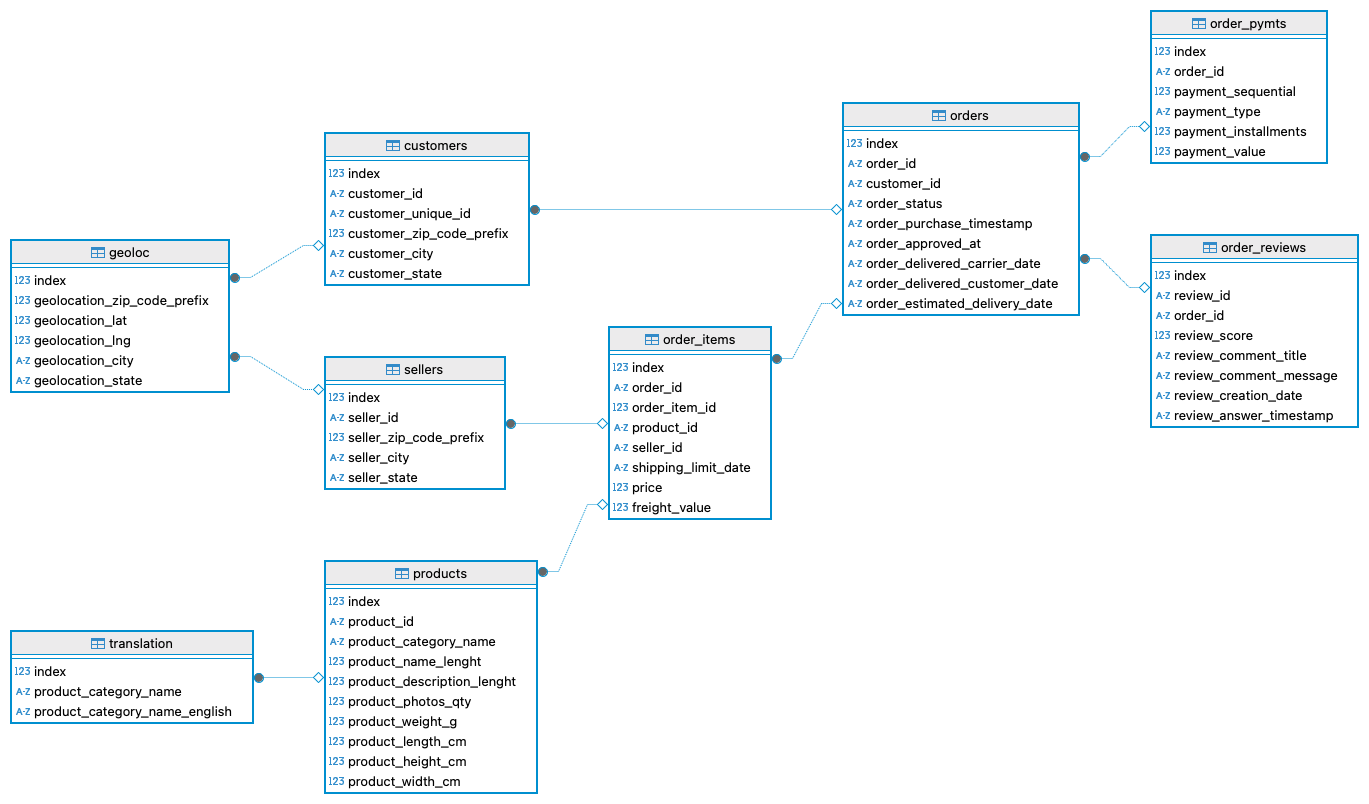

Installation du module permettant de réaliser du code SQL

In [10]:
!pip install pandasql


  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=b846dd28165b969a7a55677ba0e5d58b5df78c5b73578d2c4dbaf83cf625d6cc
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


///////

**Requête numéro 1 :**

///////

En excluant les commandes annulées, quelles sont les commandes récentes de moins de 3 mois que les clients ont reçues avec au moins 3 jours de retard ?

In [11]:
from pandasql import sqldf

query_1 = """WITH latest_order as(
select max(order_purchase_timestamp)
from df_orders
)
SELECT *, JULIANDAY(order_delivered_customer_date) -
JULIANDAY(order_estimated_delivery_date) as delta
FROM df_orders
WHERE order_purchase_timestamp >= DATE((SELECT * from latest_order),
'-3 months')
AND delta >= 3
AND order_status <> 'canceled'"""
result_1= sqldf(query_1,locals())
print(result_1)

                             order_id                       customer_id  \
0    cfa4fa27b417971e86d8127cb688712f  7093250e1741ebbed41f0cc552025fd6   
1    234c056c50619f48da64f731c48242b4  44e460a655f7154ccd9faa4dbbbaf68a   
2    8ad3f1d0f96992e43566c4c82c9f6c58  948b29e24216a05fea13a18d8db45ea5   
3    7f579e203c931f3e8410103359c6d523  d665be250d1c687c58fdea61a9b55a58   
4    cb6e441ff2ef574ce08d3709426f88ec  4fb843d304c57182d4aa27bb39ca592b   
..                                ...                               ...   
317  874a7690bc049bd4ce210d195bdfff7b  f6b2c83ea477af36f44a1e2df7320036   
318  587e32dd528769d669d539531d32aeb5  0af8a25fb0b6f833724bb5818275807b   
319  3adb141ba4bd69dd7fe8d3fb733c6b74  c0539d5c87fc7c97a8418adffe4b45f0   
320  4cf09d9e5ebbe0f91ddd7bf9aae891cd  07b6b4fe5fefb948fc76b6d2bdba77d8   
321  b3112ca67f3afd4e20cf2ee91fc4f804  6f83c71b6c044fb156d697d4130fe9b5   

    order_status order_purchase_timestamp    order_approved_at  \
0      delivered      2018-08-16 

///////

**Requête numéro 2 :**

///////

Qui sont les vendeurs ayant généré un chiffre d'affaires de plus de 100 000 Real sur des commandes livrées via Olist ?



In [12]:
# query_sellers_revenue = """
# SELECT
#     s.seller_id,
#     s.seller_city,
#     s.seller_state,
#     SUM(oi.price + oi.freight_value) AS total_revenue
# FROM df_sellers s
# JOIN df_order_item oi ON s.seller_id = oi.seller_id
# JOIN df_orders o ON oi.order_id = o.order_id
# WHERE o.order_status = 'delivered'
# GROUP BY s.seller_id, s.seller_city, s.seller_state
# HAVING total_revenue > 100000
# ORDER BY total_revenue DESC;
# """

# result_sellers_revenue = sqldf(query_sellers_revenue, locals())
# print(result_sellers_revenue)

In [13]:
query_sellers_revenue = """
SELECT
    s.seller_id,
    s.seller_city,
    s.seller_state,
    SUM(oi.price) AS total_revenue
FROM df_sellers s
JOIN df_order_item oi ON s.seller_id = oi.seller_id
JOIN df_orders o ON oi.order_id = o.order_id
WHERE o.order_status = 'delivered'
GROUP BY s.seller_id, s.seller_city, s.seller_state
HAVING total_revenue > 100000
ORDER BY total_revenue DESC;
"""

result_sellers_revenue = sqldf(query_sellers_revenue, locals())
print(result_sellers_revenue)

                           seller_id            seller_city seller_state  \
0   4869f7a5dfa277a7dca6462dcf3b52b2                guariba           SP   
1   53243585a1d6dc2643021fd1853d8905       lauro de freitas           BA   
2   4a3ca9315b744ce9f8e9374361493884               ibitinga           SP   
3   fa1c13f2614d7b5c4749cbc52fecda94                 sumare           SP   
4   7c67e1448b00f6e969d365cea6b010ab        itaquaquecetuba           SP   
5   7e93a43ef30c4f03f38b393420bc753a                barueri           SP   
6   da8622b14eb17ae2831f4ac5b9dab84a             piracicaba           SP   
7   7a67c85e85bb2ce8582c35f2203ad736              sao paulo           SP   
8   1025f0e2d44d7041d6cf58b6550e0bfa              sao paulo           SP   
9   955fee9216a65b617aa5c0531780ce60              sao paulo           SP   
10  46dc3b2cc0980fb8ec44634e21d2718e         rio de janeiro           RJ   
11  6560211a19b47992c3666cc44a7e94c0              sao paulo           SP   
12  620c87c1

In [14]:
query_sellers_revenue = """WITH orders_joined as (
SELECT i.seller_id,
i.order_id,
i.price,
o.order_purchase_timestamp

from df_order_item as i
INNER JOIN df_orders as o
on o.order_id = i.order_id
where o.order_status = 'delivered'
order by seller_id, order_purchase_timestamp
),
aggregation as (
SELECT seller_id, sum(price) as total_amount_sold,
count(order_id) as total_items_sold

FROM orders_joined
group by seller_id
)
select * from aggregation
where total_amount_sold > 100000
order by total_amount_sold desc"""

result_sellers_revenue = sqldf(query_sellers_revenue, locals())
print(result_sellers_revenue)

                           seller_id  total_amount_sold  total_items_sold
0   4869f7a5dfa277a7dca6462dcf3b52b2          226987.93              1148
1   53243585a1d6dc2643021fd1853d8905          217940.44               400
2   4a3ca9315b744ce9f8e9374361493884          196882.12              1949
3   fa1c13f2614d7b5c4749cbc52fecda94          190917.14               579
4   7c67e1448b00f6e969d365cea6b010ab          186570.05              1355
5   7e93a43ef30c4f03f38b393420bc753a          165981.49               322
6   da8622b14eb17ae2831f4ac5b9dab84a          159816.87              1548
7   7a67c85e85bb2ce8582c35f2203ad736          139658.69              1155
8   1025f0e2d44d7041d6cf58b6550e0bfa          138208.56              1420
9   955fee9216a65b617aa5c0531780ce60          131836.71              1472
10  46dc3b2cc0980fb8ec44634e21d2718e          122811.38               523
11  6560211a19b47992c3666cc44a7e94c0          120702.83              1996
12  620c87c171fb2a6dd6e8bb4dec959fc6  

///////

**Requête numéro 3 :**    

///////

Qui sont les nouveaux vendeurs (moins de 3 mois d'ancienneté) qui
sont déjà très engagés avec la plateforme (ayant déjà vendu plus de 30
produits) ?

In [15]:
query_new_engaged_sellers = """
WITH latest_order AS(
SELECT MAX(order_purchase_timestamp)
from df_orders
),
orders_joined AS (
SELECT DISTINCT i.seller_id,
i.order_id,
i.price,
o.order_purchase_timestamp

from df_order_item as i
INNER JOIN df_orders as o
on o.order_id = i.order_id
where o.order_status = 'delivered'
order by seller_id, order_purchase_timestamp
),
aggregation as (
SELECT seller_id, sum(price) as total_amount_sold,
count(order_id) as total_items_sold

FROM orders_joined
group by seller_id
HAVING MIN(order_purchase_timestamp) > DATE((SELECT * FROM latest_order),'-3 months')
)
select * from aggregation
where total_items_sold > 30

"""

result_new_engaged_sellers = sqldf(query_new_engaged_sellers, locals())
print(result_new_engaged_sellers)

                          seller_id  total_amount_sold  total_items_sold
0  240b9776d844d37535668549a396af32           13332.09                35
1  81f89e42267213cb94da7ddc301651da            3522.00                46
2  d13e50eaa47b4cbe9eb81465865d8cfc            6987.15                67


In [16]:
query_new_engaged_sellers = """
WITH latest_order AS(
SELECT MAX(order_purchase_timestamp)
from df_orders
),
orders_joined AS (
SELECT DISTINCT oi.seller_id,
oi.order_id,
oi.price,
o.order_purchase_timestamp

FROM df_order_item as oi
INNER JOIN df_orders as o
ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
ORDER BY seller_id, order_purchase_timestamp
),
aggregation AS (
SELECT seller_id, SUM(price) as total_amount_sold,
COUNT(order_id) as total_items_sold

FROM orders_joined
GROUP BY seller_id
HAVING MIN(order_purchase_timestamp) > DATE((SELECT * FROM latest_order),'-3 months')
)
SELECT * from aggregation
WHERE total_items_sold > 30

"""

result_new_engaged_sellers = sqldf(query_new_engaged_sellers, locals())
print(result_new_engaged_sellers)

                          seller_id  total_amount_sold  total_items_sold
0  240b9776d844d37535668549a396af32           13332.09                35
1  81f89e42267213cb94da7ddc301651da            3522.00                46
2  d13e50eaa47b4cbe9eb81465865d8cfc            6987.15                67


///////

**Question : Quels sont les 5 codes postaux, enregistrant plus de 30 reviews, avec le pire review score moyen sur les 12 derniers mois ?**

///////



In [17]:
query_worst_review_score = """
SELECT
    AVG(dr.review_score) as mean_review_score,
    c.customer_zip_code_prefix as code_postal,
    COUNT(dr.review_id) as review_count
FROM df_order_review dr
JOIN df_orders o ON o.order_id=dr.order_id
JOIN df_customer c ON c.customer_id=o.customer_id
WHERE o.order_purchase_timestamp >= strftime('%Y-%m-%d %H:%M:%S', (SELECT MAX(order_purchase_timestamp) FROM df_orders), '-12 months')
GROUP BY code_postal
HAVING review_count > 30
ORDER BY mean_review_score ASC
LIMIT 5
"""

worst_review_score = sqldf(query_worst_review_score, locals())
print(worst_review_score)

   mean_review_score  code_postal  review_count
0           2.808511        22753            47
1           3.135135        22770            37
2           3.233333        22793            90
3           3.277778        21321            36
4           3.351351        22780            37


## Transformation des données et Première segmentation RFM

In [18]:
#Premier aperçu du dataframe précédemment créé, regroupant les jeux de données
#df_customer,df_orders,df_order_item et df_sellers
df_merged_3.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  ...  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57  ...   
1  2018-01-12 20:58:32          2018-01-15 17:14:59  ...   
2  2018-05-20 16:19:10          2018-06-11 14:31:00  ...   
3  2018-03-13 17:29:19          2018-03-27 23:22:42  ...   
4  2018-07-29 10:10:09          2018-07-30 15:16:00  ...   

  order_estimated_delivery_date order_item_id  \
0           2017-06-05 00:00:00             1   
1           2018-02-06 00:00:00             1   
2           2018-06-13 00:00:00             1   
3           2018-04-10 00:00:00             1   
4           2018-08-15 00:00:00             1   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c56e38d84d7d5b3b  4a3ca9315b744ce9f8e9374361493884   

   shipping_limit_date   price  freight_value  seller_zip_code_prefix  \
0  2017-05-22 15:22:12  124.99          21.88                    8577   
1  2018-01-18 20:58:32  289.00          46.48                   88303   
2  2018-06-05 16:19:10  139.94          17.79                    8577   
3  2018-03-27 16:31:16  149.94          23.36                    8577   
4  2018-07-31 10:10:09  230.00          22.25                   14940   

       seller_city seller_state  
0  itaquaquecetuba           SP  
1           itajai           SC  
2  itaquaquecetuba           SP  
3  itaquaquecetuba           SP  
4         ibitinga           SP  

[5 rows x 21 columns]

Maintenant, nous pouvons réaliser différents sous-dataframes à partir du dataframe principal df_merged_3, qui nous permettront de créer une segmentation RFM en fonction des clients de Olist (Récence/Fréquence/Montant)

**//////////////**

**Somme des achats par customer**

**/////////**

In [19]:
#df_value_per_customer
df_value_per_customer = df_merged_3.groupby(['customer_id'])['price'].sum()
df_value_per_customer.head()

customer_id
00012a2ce6f8dcda20d059ce98491703     89.80
000161a058600d5901f007fab4c27140     54.90
0001fd6190edaaf884bcaf3d49edf079    179.99
0002414f95344307404f0ace7a26f1d5    149.90
000379cdec625522490c315e70c7a9fb     93.00
Name: price, dtype: float64

In [20]:
df_value_per_customer.describe()

count    98666.000000
mean       137.754076
std        210.645145
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: price, dtype: float64

In [21]:
# Calculer les déciles
deciles = pd.qcut(df_value_per_customer, 10, labels=False, duplicates='drop')

# Afficher le résultat
print(pd.DataFrame({'Somme des achats': df_value_per_customer, 'decile_client': deciles}))

                                  Somme des achats  decile_client
customer_id                                                      
00012a2ce6f8dcda20d059ce98491703             89.80              5
000161a058600d5901f007fab4c27140             54.90              3
0001fd6190edaaf884bcaf3d49edf079            179.99              8
0002414f95344307404f0ace7a26f1d5            149.90              7
000379cdec625522490c315e70c7a9fb             93.00              5
...                                            ...            ...
fffcb937e9dd47a13f05ecb8290f4d3e             78.00              4
fffecc9f79fd8c764f843e9951b11341             54.90              3
fffeda5b6d849fbd39689bb92087f431             47.90              2
ffff42319e9b2d713724ae527742af25            199.90              8
ffffa3172527f765de70084a7e53aae8             21.80              0

[98666 rows x 2 columns]


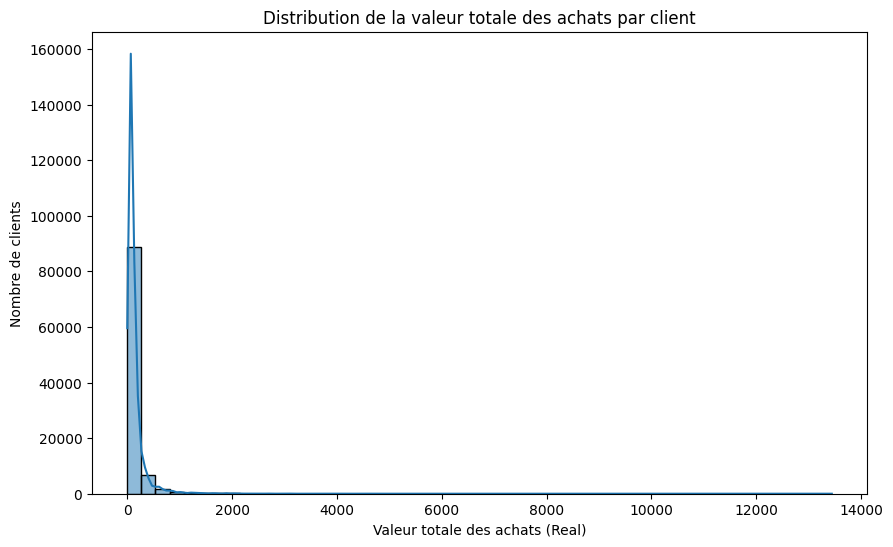

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tracer la distribution avec un histogramme et une courbe de densité
plt.figure(figsize=(10, 6))  # Ajuster la taille de la figure si nécessaire
sns.histplot(df_value_per_customer, kde=True, bins=50)  # kde=True ajoute la courbe de densité
plt.title('Distribution de la valeur totale des achats par client')
plt.xlabel('Valeur totale des achats (Real)')
plt.ylabel('Nombre de clients')
plt.show()

In [23]:
#Création du dataframe qui sera réutilisable pour la suite de nos analyses RFM

df_value_per_customer_2=pd.DataFrame({'Somme des achats': df_value_per_customer, 'decile_client': deciles}).reset_index()
df_value_per_customer_2.head()

customer_id  Somme des achats  decile_client
0  00012a2ce6f8dcda20d059ce98491703             89.80              5
1  000161a058600d5901f007fab4c27140             54.90              3
2  0001fd6190edaaf884bcaf3d49edf079            179.99              8
3  0002414f95344307404f0ace7a26f1d5            149.90              7
4  000379cdec625522490c315e70c7a9fb             93.00              5

**//////////////**

**Ventes totales par vendeur**

**//////////////**

In [24]:
df_value_per_seller = df_merged_3.groupby(['seller_id'])['price'].sum()
df_value_per_seller.head()

seller_id
0015a82c2db000af6aaaf3ae2ecb0532     2685.00
001cca7ae9ae17fb1caed9dfb1094831    25080.03
001e6ad469a905060d959994f1b41e4f      250.00
002100f778ceb8431b7a1020ff7ab48f     1234.50
003554e2dce176b5555353e4f3555ac8      120.00
Name: price, dtype: float64

In [25]:
# Calculer les déciles
deciles = pd.qcut(df_value_per_seller, 10, labels=False, duplicates='drop')

# Afficher le résultat
print(pd.DataFrame({'Ventes totales': df_value_per_seller, 'decile_vendeur': deciles}))

                                  Ventes totales  decile_vendeur
seller_id                                                       
0015a82c2db000af6aaaf3ae2ecb0532         2685.00               7
001cca7ae9ae17fb1caed9dfb1094831        25080.03               9
001e6ad469a905060d959994f1b41e4f          250.00               2
002100f778ceb8431b7a1020ff7ab48f         1234.50               5
003554e2dce176b5555353e4f3555ac8          120.00               1
...                                          ...             ...
ffcfefa19b08742c5d315f2791395ee5           69.90               0
ffdd9f82b9a447f6f8d4b91554cc7dd3         2101.20               6
ffeee66ac5d5a62fe688b9d26f83f534         1839.86               6
fffd5413c0700ac820c7069d66d98c89         9062.30               8
ffff564a4f9085cd26170f4732393726         1426.30               6

[3095 rows x 2 columns]


Text(0, 0.5, 'Nombre de vendeurs')

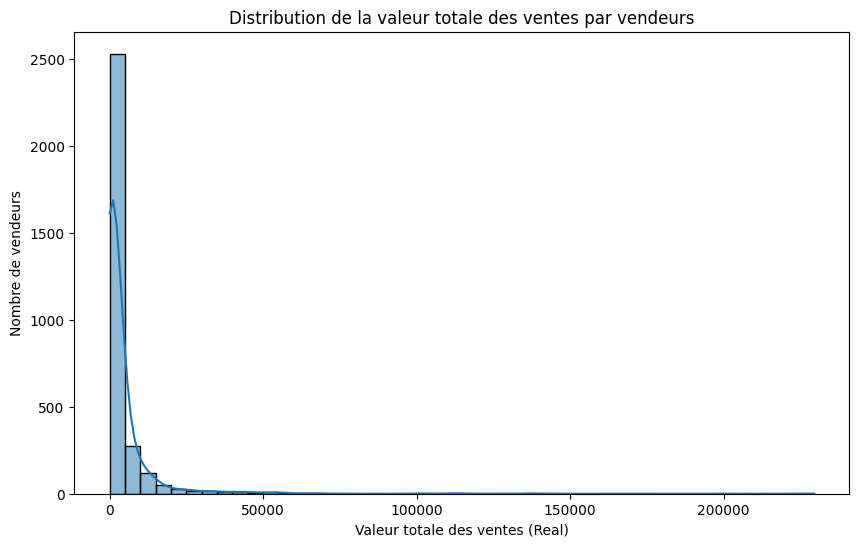

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(df_value_per_seller,kde=True,binwidth=5000)
plt.title('Distribution de la valeur totale des ventes par vendeurs')
plt.xlabel('Valeur totale des ventes (Real)')
plt.ylabel('Nombre de vendeurs')

In [27]:
df_value_per_seller_2=pd.DataFrame({'Somme des ventes': df_value_per_seller, 'decile_vendeur': deciles}).reset_index()
df_value_per_seller_2.head()

seller_id  Somme des ventes  decile_vendeur
0  0015a82c2db000af6aaaf3ae2ecb0532           2685.00               7
1  001cca7ae9ae17fb1caed9dfb1094831          25080.03               9
2  001e6ad469a905060d959994f1b41e4f            250.00               2
3  002100f778ceb8431b7a1020ff7ab48f           1234.50               5
4  003554e2dce176b5555353e4f3555ac8            120.00               1

In [28]:
df_value_per_seller_2['decile_vendeur'].value_counts()

decile_vendeur
7    310
9    310
2    310
4    310
0    310
5    309
1    309
6    309
8    309
3    309
Name: count, dtype: int64

**//////////////**

**Recence : Dernier achat par customer**

**//////////////**

In [29]:
df_merged_3['order_purchase_timestamp'].max()

'2018-09-03 09:06:57'

In [30]:
df_recence=df_merged_3.groupby(['customer_unique_id'])['order_purchase_timestamp'].max()
df_recence.head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    2018-05-10 10:56:27
0000b849f77a49e4a4ce2b2a4ca5be3f    2018-05-07 11:11:27
0000f46a3911fa3c0805444483337064    2017-03-10 21:05:03
0000f6ccb0745a6a4b88665a16c9f078    2017-10-12 20:29:41
0004aac84e0df4da2b147fca70cf8255    2017-11-14 19:45:42
Name: order_purchase_timestamp, dtype: object

In [31]:
df_recence_2=df_recence.reset_index()
df_recence_2['order_purchase_timestamp']=pd.to_datetime(df_recence_2['order_purchase_timestamp'])

# Calculer la date maximale
max_date = df_recence_2['order_purchase_timestamp'].max()

# Calculer la différence en jours
df_recence_2['days_diff'] = (max_date - df_recence_2['order_purchase_timestamp']).dt.days
df_recence_2.head()

customer_unique_id order_purchase_timestamp  days_diff
0  0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27        115
1  0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27        118
2  0000f46a3911fa3c0805444483337064      2017-03-10 21:05:03        541
3  0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41        325
4  0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42        292

In [32]:
df_recence_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95420 entries, 0 to 95419
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        95420 non-null  object        
 1   order_purchase_timestamp  95420 non-null  datetime64[ns]
 2   days_diff                 95420 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.2+ MB


In [33]:
# Calculer les déciles sur la colonne 'days_diff'
df_recence_2['decile_days_diff'] = pd.qcut(df_recence_2['days_diff'], 10, labels=False, duplicates='drop')

# Afficher le résultat
print(df_recence_2.head())

                 customer_unique_id order_purchase_timestamp  days_diff  \
0  0000366f3b9a7992bf8c76cfdf3221e2      2018-05-10 10:56:27        115   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      2018-05-07 11:11:27        118   
2  0000f46a3911fa3c0805444483337064      2017-03-10 21:05:03        541   
3  0000f6ccb0745a6a4b88665a16c9f078      2017-10-12 20:29:41        325   
4  0004aac84e0df4da2b147fca70cf8255      2017-11-14 19:45:42        292   

   decile_days_diff  
0                 2  
1                 2  
2                 9  
3                 7  
4                 6  


In [34]:
df_recence_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95420 entries, 0 to 95419
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        95420 non-null  object        
 1   order_purchase_timestamp  95420 non-null  datetime64[ns]
 2   days_diff                 95420 non-null  int64         
 3   decile_days_diff          95420 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.9+ MB


Text(0, 0.5, 'Nombre de customers')

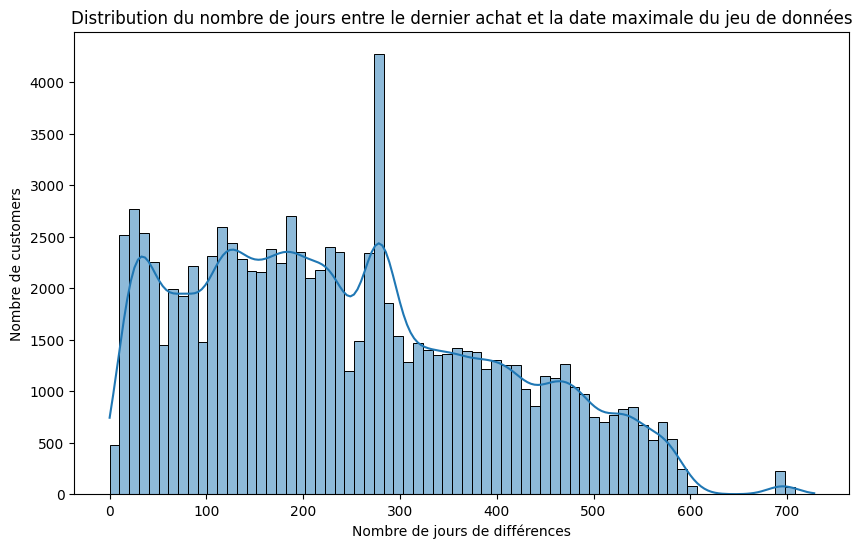

In [35]:
plt.figure(figsize=(10,6))
sns.histplot(df_recence_2['days_diff'],kde=True)
plt.title('Distribution du nombre de jours entre le dernier achat et la date maximale du jeu de données')
plt.xlabel('Nombre de jours de différences')
plt.ylabel('Nombre de customers')

In [36]:
#Renommage de la colonne 'order_purchase_timestamp' en 'date_dernier_achat'
df_recence_2.rename(columns={'order_purchase_timestamp': 'date_dernier_achat'}, inplace=True)
df_recence_2.head()

customer_unique_id  date_dernier_achat  days_diff  \
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27        115   
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27        118   
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03        541   
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41        325   
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42        292   

   decile_days_diff  
0                 2  
1                 2  
2                 9  
3                 7  
4                 6

**///////**

**Fréquence d'achats**

**/////**

In [37]:
df_frequence_unique=df_merged_3.groupby(['customer_unique_id'])['order_id'].nunique()
df_frequence_unique.head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
Name: order_id, dtype: int64

In [38]:
len(df_frequence_unique)

95420

In [39]:
df_frequence_unique_2=df_frequence_unique.reset_index()
df_frequence_unique_2

customer_unique_id  order_id
0      0000366f3b9a7992bf8c76cfdf3221e2         1
1      0000b849f77a49e4a4ce2b2a4ca5be3f         1
2      0000f46a3911fa3c0805444483337064         1
3      0000f6ccb0745a6a4b88665a16c9f078         1
4      0004aac84e0df4da2b147fca70cf8255         1
...                                 ...       ...
95415  fffcf5a5ff07b0908bd4e2dbc735a684         1
95416  fffea47cd6d3cc0a88bd621562a9d061         1
95417  ffff371b4d645b6ecea244b27531430a         1
95418  ffff5962728ec6157033ef9805bacc48         1
95419  ffffd2657e2aad2907e67c3e9daecbeb         1

[95420 rows x 2 columns]

In [40]:
df_frequence_unique_2['order_id'].value_counts()

order_id
1     92507
2      2673
3       192
4        29
5         9
6         5
7         3
9         1
16        1
Name: count, dtype: int64

In [41]:
#Renommage de la colonne 'order_id' en 'Nombre achats effectués'
df_frequence_unique_2.rename(columns={'order_id': 'Nombre achats effectués'}, inplace=True)
df_frequence_unique_2.head()

customer_unique_id  Nombre achats effectués
0  0000366f3b9a7992bf8c76cfdf3221e2                        1
1  0000b849f77a49e4a4ce2b2a4ca5be3f                        1
2  0000f46a3911fa3c0805444483337064                        1
3  0000f6ccb0745a6a4b88665a16c9f078                        1
4  0004aac84e0df4da2b147fca70cf8255                        1

**//////////////**

**Fusion de toutes les colonnes avec les déciles**

**//////////////**

Tous les sous-dataframes nécessaires étant créés, nous allons pouvoir procéder à leur fusion avec le dataframe principal. Cette étape permettra d'obtenir un dataframe unique et complet, facilitant ainsi les analyses ultérieures."

In [42]:
df_final=df_merged_3.copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   customer_city                  112650 non-null  object 
 4   customer_state                 112650 non-null  object 
 5   order_id                       112650 non-null  object 
 6   order_status                   112650 non-null  object 
 7   order_purchase_timestamp       112650 non-null  object 
 8   order_approved_at              112635 non-null  object 
 9   order_delivered_carrier_date   111456 non-null  object 
 10  order_delivered_customer_date  110196 non-null  object 
 11  order_estimated_delivery_date  112650 non-null  object 
 12  order_item_id                 

In [43]:
#Première fusion avec la somme des achats et leurs déciles
df_final_merged_1=df_final.merge(df_value_per_customer_2,on='customer_id')
df_final_merged_1.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  ...  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57  ...   
1  2018-01-12 20:58:32          2018-01-15 17:14:59  ...   
2  2018-05-20 16:19:10          2018-06-11 14:31:00  ...   
3  2018-03-13 17:29:19          2018-03-27 23:22:42  ...   
4  2018-07-29 10:10:09          2018-07-30 15:16:00  ...   

                         product_id                         seller_id  \
0  a9516a079e37a9c9c36b9b78b10169e8  7c67e1448b00f6e969d365cea6b010ab   
1  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   
2  bd07b66896d6f1494f5b86251848ced7  7c67e1448b00f6e969d365cea6b010ab   
3  a5647c44af977b148e0a3a4751a09e2e  7c67e1448b00f6e969d365cea6b010ab   
4  9391a573abe00141c56e38d84d7d5b3b  4a3ca9315b744ce9f8e9374361493884   

   shipping_limit_date   price freight_value seller_zip_code_prefix  \
0  2017-05-22 15:22:12  124.99         21.88                   8577   
1  2018-01-18 20:58:32  289.00         46.48                  88303   
2  2018-06-05 16:19:10  139.94         17.79                   8577   
3  2018-03-27 16:31:16  149.94         23.36                   8577   
4  2018-07-31 10:10:09  230.00         22.25                  14940   

       seller_city  seller_state  Somme des achats decile_client  
0  itaquaquecetuba            SP            124.99             6  
1           itajai            SC            289.00             9  
2  itaquaquecetuba            SP            139.94             7  
3  itaquaquecetuba            SP            149.94             7  
4         ibitinga            SP            230.00             8  

[5 rows x 23 columns]

In [44]:
df_value_per_seller_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seller_id         3095 non-null   object 
 1   Somme des ventes  3095 non-null   float64
 2   decile_vendeur    3095 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 72.7+ KB


In [45]:
#Deuxième fusion avec la somme des ventes et leurs déciles
df_final_merged_2=df_final_merged_1.merge(df_value_per_seller_2,on='seller_id')
df_final_merged_2.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  ...  shipping_limit_date  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57  ...  2017-05-22 15:22:12   
1  2018-01-12 20:58:32          2018-01-15 17:14:59  ...  2018-01-18 20:58:32   
2  2018-05-20 16:19:10          2018-06-11 14:31:00  ...  2018-06-05 16:19:10   
3  2018-03-13 17:29:19          2018-03-27 23:22:42  ...  2018-03-27 16:31:16   
4  2018-07-29 10:10:09          2018-07-30 15:16:00  ...  2018-07-31 10:10:09   

    price  freight_value seller_zip_code_prefix      seller_city seller_state  \
0  124.99          21.88                   8577  itaquaquecetuba           SP   
1  289.00          46.48                  88303           itajai           SC   
2  139.94          17.79                   8577  itaquaquecetuba           SP   
3  149.94          23.36                   8577  itaquaquecetuba           SP   
4  230.00          22.25                  14940         ibitinga           SP   

   Somme des achats  decile_client  Somme des ventes decile_vendeur  
0            124.99              6         187923.89              9  
1            289.00              9          13685.71              9  
2            139.94              7         187923.89              9  
3            149.94              7         187923.89              9  
4            230.00              8         200472.92              9  

[5 rows x 25 columns]

In [46]:
#Troisième fusion avec la récence des achats et leurs déciles
df_final_merged_3=df_final_merged_2.merge(df_recence_2,on='customer_unique_id')
df_final_merged_3.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  ...  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57  ...   
1  2018-01-12 20:58:32          2018-01-15 17:14:59  ...   
2  2018-05-20 16:19:10          2018-06-11 14:31:00  ...   
3  2018-03-13 17:29:19          2018-03-27 23:22:42  ...   
4  2018-07-29 10:10:09          2018-07-30 15:16:00  ...   

  seller_zip_code_prefix      seller_city  seller_state Somme des achats  \
0                   8577  itaquaquecetuba            SP           124.99   
1                  88303           itajai            SC           289.00   
2                   8577  itaquaquecetuba            SP           139.94   
3                   8577  itaquaquecetuba            SP           149.94   
4                  14940         ibitinga            SP           230.00   

  decile_client Somme des ventes  decile_vendeur  date_dernier_achat  \
0             6        187923.89               9 2017-05-16 15:05:35   
1             9         13685.71               9 2018-01-12 20:48:24   
2             7        187923.89               9 2018-05-19 16:07:45   
3             7        187923.89               9 2018-03-13 16:06:38   
4             8        200472.92               9 2018-07-29 09:51:30   

   days_diff decile_days_diff  
0        474                9  
1        233                5  
2        106                2  
3        173                3  
4         35                0  

[5 rows x 28 columns]

In [47]:
#Quatrième fusion avec la récence des achats et leurs déciles
df_final_merged_4=df_final_merged_3.merge(df_frequence_unique_2,on='customer_unique_id')
df_final_merged_4.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

     order_approved_at order_delivered_carrier_date  ...      seller_city  \
0  2017-05-16 15:22:12          2017-05-23 10:47:57  ...  itaquaquecetuba   
1  2018-01-12 20:58:32          2018-01-15 17:14:59  ...           itajai   
2  2018-05-20 16:19:10          2018-06-11 14:31:00  ...  itaquaquecetuba   
3  2018-03-13 17:29:19          2018-03-27 23:22:42  ...  itaquaquecetuba   
4  2018-07-29 10:10:09          2018-07-30 15:16:00  ...         ibitinga   

  seller_state  Somme des achats decile_client Somme des ventes  \
0           SP            124.99             6        187923.89   
1           SC            289.00             9         13685.71   
2           SP            139.94             7        187923.89   
3           SP            149.94             7        187923.89   
4           SP            230.00             8        200472.92   

  decile_vendeur  date_dernier_achat  days_diff  decile_days_diff  \
0              9 2017-05-16 15:05:35        474                 9   
1              9 2018-01-12 20:48:24        233                 5   
2              9 2018-05-19 16:07:45        106                 2   
3              9 2018-03-13 16:06:38        173                 3   
4              9 2018-07-29 09:51:30         35                 0   

  Nombre achats effectués  
0                       1  
1                       1  
2                       1  
3                       1  
4                       1  

[5 rows x 29 columns]

**////**

Création de la colonne "Number of days of delay"

**////**

In [48]:
df_final_merged_4.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'Somme des achats', 'decile_client', 'Somme des ventes',
       'decile_vendeur', 'date_dernier_achat', 'days_diff', 'decile_days_diff',
       'Nombre achats effectués'],
      dtype='object')

In [49]:
datetime_columns = ['order_purchase_timestamp', 'order_approved_at',
                    'order_delivered_carrier_date', 'order_delivered_customer_date',
                    'order_estimated_delivery_date']
df_final_merged_4[datetime_columns] = df_final_merged_4[datetime_columns].apply(pd.to_datetime)
df_final_merged_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    112650 non-null  object        
 1   customer_unique_id             112650 non-null  object        
 2   customer_zip_code_prefix       112650 non-null  int64         
 3   customer_city                  112650 non-null  object        
 4   customer_state                 112650 non-null  object        
 5   order_id                       112650 non-null  object        
 6   order_status                   112650 non-null  object        
 7   order_purchase_timestamp       112650 non-null  datetime64[ns]
 8   order_approved_at              112635 non-null  datetime64[ns]
 9   order_delivered_carrier_date   111456 non-null  datetime64[ns]
 10  order_delivered_customer_date  110196 non-null  datetime64[ns]
 11  

In [50]:
df_final_merged_4['Number_of_days_of_delay'] = (df_final_merged_4['order_delivered_customer_date'] - df_final_merged_4['order_estimated_delivery_date']).dt.days


In [51]:
df_final_merged_4.loc[:,['order_delivered_customer_date','order_estimated_delivery_date','Number_of_days_of_delay']]

order_delivered_customer_date order_estimated_delivery_date  \
0                2017-05-25 10:35:35                    2017-06-05   
1                2018-01-29 12:41:19                    2018-02-06   
2                2018-06-14 17:58:51                    2018-06-13   
3                2018-03-28 16:04:25                    2018-04-10   
4                2018-08-09 20:55:48                    2018-08-15   
...                              ...                           ...   
112645           2018-04-13 20:06:37                    2018-04-25   
112646           2018-04-11 18:54:45                    2018-04-20   
112647           2018-05-09 19:03:15                    2018-05-02   
112648           2017-11-16 19:58:39                    2017-12-05   
112649           2017-12-26 18:42:36                    2018-01-08   

        Number_of_days_of_delay  
0                         -11.0  
1                          -8.0  
2                           1.0  
3                         -13.0  
4                          -6.0  
...                         ...  
112645                    -12.0  
112646                     -9.0  
112647                      7.0  
112648                    -19.0  
112649                    -13.0  

[112650 rows x 3 columns]

In [52]:
df_final_merged_4['Number_of_days_of_delay'].value_counts().sort_index()

Number_of_days_of_delay
-147.0    2
-140.0    1
-135.0    1
-124.0    2
-109.0    1
         ..
 166.0    1
 167.0    1
 175.0    1
 181.0    1
 188.0    1
Name: count, Length: 198, dtype: int64

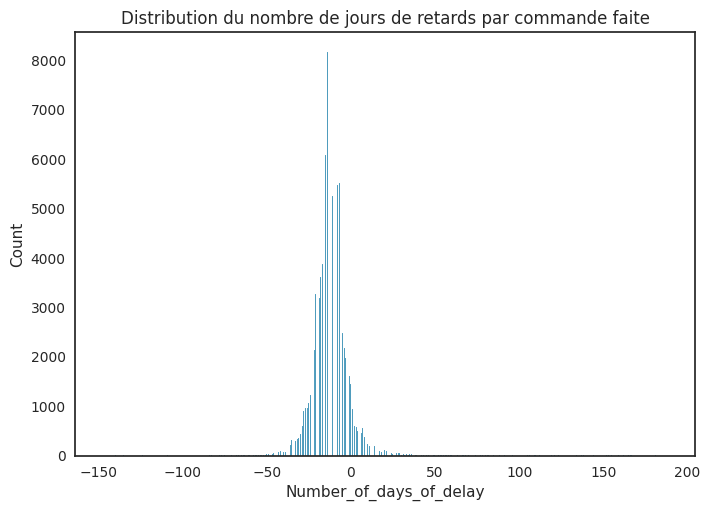

In [218]:
sns.histplot(df_final_merged_4['Number_of_days_of_delay'])
plt.title("Distribution du nombre de jours de retards par commande faite")
plt.show()

In [54]:
# df_test=df_final_merged_4.copy()
# df_test['Nombre de jours entre commande et livraison'] = -(df_final_merged_4['order_purchase_timestamp'] - df_final_merged_4['order_delivered_customer_date']).dt.days
# df_test.loc[:,['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date','Number_of_days_of_delay','Nombre de jours entre commande et livraison']]

In [55]:
# df_test['Nombre de jours entre commande et livraison'].value_counts().sort_index()

**//////////////**

**Vérifications**

**//////////////**

Des histogrammes seront utilisés pour représenter la distribution de chacunes des nouvelles colonnes que nous avons créé : decile_client, decile_vendeur, decile_days_diff et Nombre d'achats effectués.

Ces visualisations permettront d'observer la répartition des observations dans chaque décile."

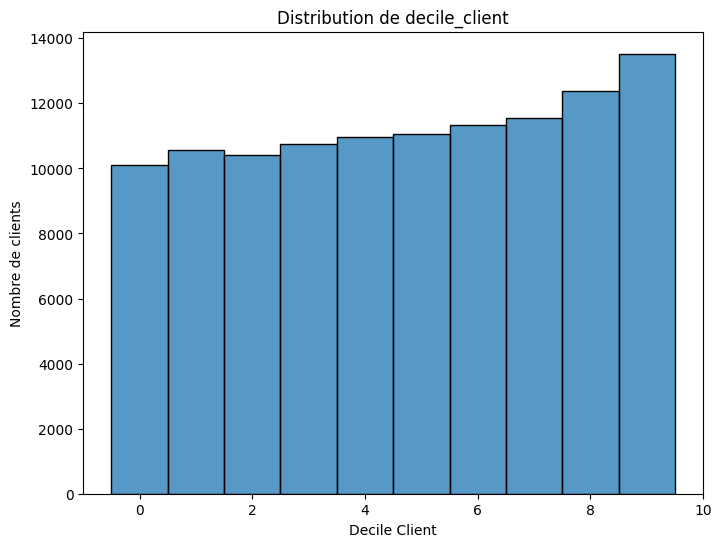

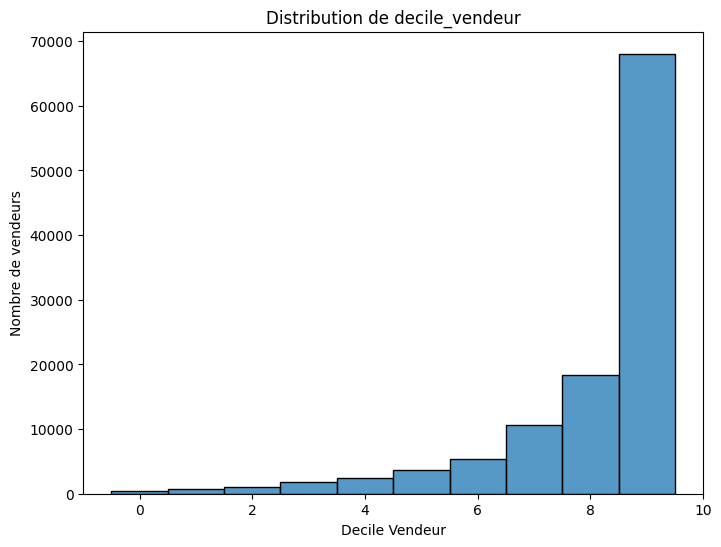

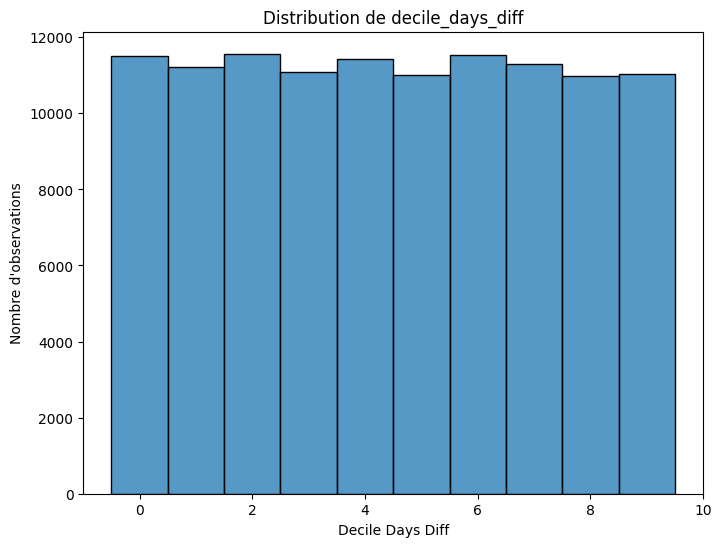

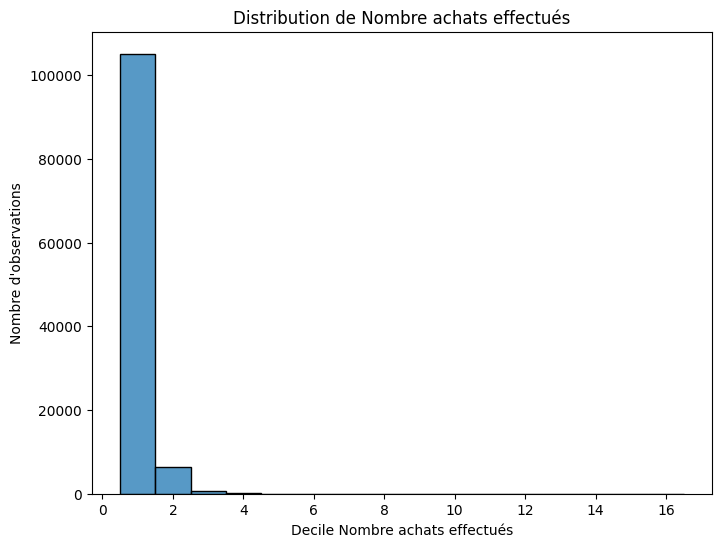

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogramme pour decile_client
plt.figure(figsize=(8, 6))
sns.histplot(df_final_merged_3['decile_client'], bins=10, discrete=True)
plt.title('Distribution de decile_client')
plt.xlabel('Decile Client')
plt.ylabel('Nombre de clients')
plt.show()

# Histogramme pour decile_vendeur
plt.figure(figsize=(8, 6))
sns.histplot(df_final_merged_3['decile_vendeur'], bins=10, discrete=True)
plt.title('Distribution de decile_vendeur')
plt.xlabel('Decile Vendeur')
plt.ylabel('Nombre de vendeurs')
plt.show()

# Histogramme pour decile_days_diff
plt.figure(figsize=(8, 6))
sns.histplot(df_final_merged_3['decile_days_diff'], bins=10, discrete=True)
plt.title('Distribution de decile_days_diff')
plt.xlabel('Decile Days Diff')
plt.ylabel('Nombre d\'observations')
plt.show()

# Histogramme pour 'Nombre achats effectués
plt.figure(figsize=(8, 6))
sns.histplot(df_final_merged_4['Nombre achats effectués'], bins=10, discrete=True)
plt.title('Distribution de Nombre achats effectués')
plt.xlabel('Decile Nombre achats effectués')
plt.ylabel('Nombre d\'observations')
plt.show()

In [57]:
# # Afficher les lignes où 'price' est différent de 'Somme des achats' pour vérifier la logique de la colonne 'Nombre d'achats effectués'
# diff_rows = df_final_merged_1[df_final_merged_1['price'] != df_final_merged_1['Somme des achats']]
# print(diff_rows)

**//////////////**


**Création des groupes RFM**


**//////////////**

Segments Clients	Score Récence	Score combinaison Fréquence + Montant

Champions	: 4-5	/ 4-5

Clients fidèles :	2-5	/ 3-5

Clients potentiellement fidèles :	3-5 /	1-3

Clients récents :	4-5	/ 0-1

Clients prometteurs :	3-4	/ 0-1

Clients qui méritent une attention :	2-3 /	2-3

Clients sur le point de s’endormir :	2-3 /	0-2

Clients à risque :	0-2 /	2-5

Clients que vous ne devez pas perdre :	0-1 /	4-5

Clients en hibernation :	1-2 /	1-2

Clients perdus :	0-2 /	0-2

In [58]:
df_final_merged_4

customer_id                customer_unique_id  \
0       06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1       18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2       4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3       b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4       4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                  ...                               ...   
112645  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
112646  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
112647  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
112648  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
112649  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

        customer_zip_code_prefix          customer_city customer_state  \
0                          14409                 franca             SP   
1                           9790  sao bernardo do campo             SP   
2                           1151              sao paulo             SP   
3                           8775        mogi das cruzes             SP   
4                          13056               campinas             SP   
...                          ...                    ...            ...   
112645                      3937              sao paulo             SP   
112646                      6764        taboao da serra             SP   
112647                     60115              fortaleza             CE   
112648                     92120                 canoas             RS   
112649                      6703                  cotia             SP   

                                order_id order_status  \
0       00e7ee1b050b8499577073aeb2a297a1    delivered   
1       29150127e6685892b6eab3eec79f59c7    delivered   
2       b2059ed67ce144a36e2aa97d2c9e9ad2    delivered   
3       951670f92359f4fe4a63112aa7306eba    delivered   
4       6b7d50bd145f6fc7f33cebabd7e49d0f    delivered   
...                                  ...          ...   
112645  6760e20addcf0121e9d58f2f1ff14298    delivered   
112646  9ec0c8947d973db4f4e8dcf1fbfa8f1b    delivered   
112647  fed4434add09a6f332ea398efd656a5c    delivered   
112648  e31ec91cea1ecf97797787471f98a8c2    delivered   
112649  28db69209a75e59f20ccbb5c36a20b90    delivered   

       order_purchase_timestamp   order_approved_at  \
0           2017-05-16 15:05:35 2017-05-16 15:22:12   
1           2018-01-12 20:48:24 2018-01-12 20:58:32   
2           2018-05-19 16:07:45 2018-05-20 16:19:10   
3           2018-03-13 16:06:38 2018-03-13 17:29:19   
4           2018-07-29 09:51:30 2018-07-29 10:10:09   
...                         ...                 ...   
112645      2018-04-07 15:48:17 2018-04-07 16:08:45   
112646      2018-04-04 08:20:22 2018-04-04 08:35:12   
112647      2018-04-08 20:11:50 2018-04-08 20:30:03   
112648      2017-11-03 21:08:33 2017-11-03 21:31:20   
112649      2017-12-19 14:27:23 2017-12-19 18:50:39   

       order_delivered_carrier_date  ... seller_state Somme des achats  \
0               2017-05-23 10:47:57  ...           SP           124.99   
1               2018-01-15 17:14:59  ...           SC           289.00   
2               2018-06-11 14:31:00  ...           SP           139.94   
3               2018-03-27 23:22:42  ...           SP           149.94   
4               2018-07-30 15:16:00  ...           SP           230.00   
...                             ...  ...          ...              ...   
112645          2018-04-11 02:08:36  ...           SP            74.90   
112646          2018-04-05 18:42:35  ...           SP           114.90   
112647          2018-04-09 17:52:17  ...           SP            37.00   
112648          2017-11-06 18:24:41  ...           SP           689.00   
112649          2017-12-21 19:17:21  ...   

La visualisation des clusters de clients en fonction de la segmentation RFM nécessite de regrouper les informations de fréquence et de montant. Pour ce faire, nous allons combiner les valeurs des variables 'decile_client' et 'Nombre d'achats par client' en une seule variable nommée 'Fréquence et Montant'. Cette nouvelle variable permettra de représenter la valeur RFM des clients sur un seul axe.

In [59]:
df_final_merged_4['Fréquence et Montant']=df_final_merged_4['decile_client'] * df_final_merged_4['Nombre achats effectués'] / 2
df_final_merged_4.loc[:,['Somme des achats','decile_client','days_diff','decile_days_diff','Nombre achats effectués','Fréquence et Montant']]

Somme des achats  decile_client  days_diff  decile_days_diff  \
0                 124.99              6        474                 9   
1                 289.00              9        233                 5   
2                 139.94              7        106                 2   
3                 149.94              7        173                 3   
4                 230.00              8         35                 0   
...                  ...            ...        ...               ...   
112645             74.90              4        148                 3   
112646            114.90              6        152                 3   
112647             37.00              1        147                 3   
112648            689.00              9        303                 6   
112649             13.99              0        257                 5   

        Nombre achats effectués  Fréquence et Montant  
0                             1                   3.0  
1                             1                   4.5  
2                             1                   3.5  
3                             1                   3.5  
4                             1                   4.0  
...                         ...                   ...  
112645                        1                   2.0  
112646                        1                   3.0  
112647                        1                   0.5  
112648                        1                   4.5  
112649                        1                   0.0  

[112650 rows x 6 columns]

In [60]:
df_final_merged_4['Fréquence et Montant'].value_counts().sort_index()

Fréquence et Montant
0.0     10113
0.5      9889
1.0     10292
1.5     10121
2.0     10804
2.5     10292
3.0     11283
3.5     10851
4.0     12191
4.5     12724
5.0       693
6.0       704
7.0       608
7.5        88
8.0       776
9.0       771
10.0        8
10.5       71
12.0      108
12.5        2
13.5      116
14.0       20
15.0        6
16.0       21
17.5        5
18.0       43
20.0        4
21.0        9
22.5       10
24.0        9
24.5        5
27.0        3
28.0        4
32.0        2
40.0        1
40.5        2
56.0        1
Name: count, dtype: int64

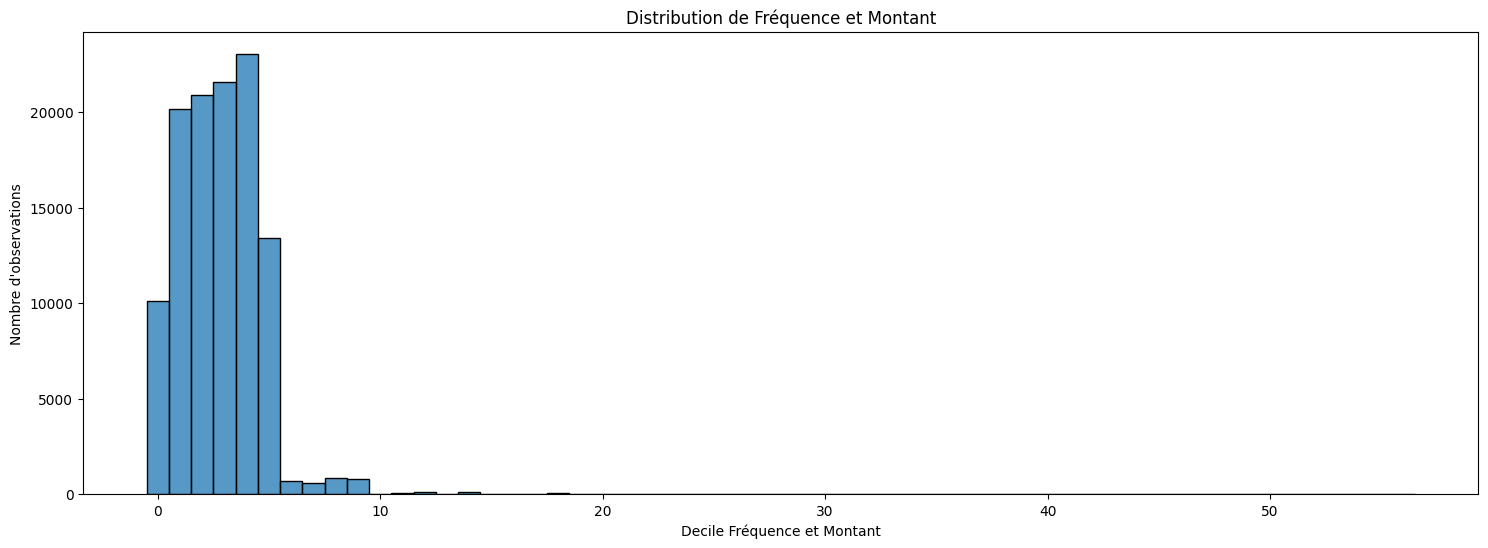

In [61]:
# Histogramme pour 'Nombre achats effectués
plt.figure(figsize=(18, 6))
sns.histplot(df_final_merged_4['Fréquence et Montant'], bins=2, discrete=True)
plt.title('Distribution de Fréquence et Montant')
plt.xlabel('Decile Fréquence et Montant')
plt.ylabel('Nombre d\'observations')
plt.show()

In [62]:
# from sklearn.preprocessing import MinMaxScaler
# # Créer un objet MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 5))  # Définir la plage souhaitée (ici 0 à 1)

# df_std=df_final_merged_4.copy()
# # Ajuster le scaler à vos données et transformer les valeurs
# df_std['Fréquence et Montant Normalisées'] = scaler.fit_transform(df_std[['Fréquence et Montant']])

# # Afficher le résultat
# print(df_std.loc[:,['Fréquence et Montant Normalisées','Fréquence et Montant']])


In [63]:
# # Histogramme pour 'Nombre achats effectués
# plt.figure(figsize=(18, 6))
# sns.histplot(df_std['Fréquence et Montant Normalisées'], bins=2, discrete=True)
# plt.title('Distribution de Fréquence et Montant Normalisées')
# plt.xlabel('Decile Fréquence et Montant')
# plt.ylabel('Nombre d\'observations')
# plt.show()

In [64]:
# # Histogramme pour 'Nombre achats effectués
# plt.figure(figsize=(18, 6))
# sns.histplot(df_std['Fréquence et Montant Normalisées'], kde=True, discrete=True)
# plt.title('Distribution de Fréquence et Montant Normalisées')
# plt.xlabel('Decile Fréquence et Montant')
# plt.ylabel('Nombre d\'observations')
# plt.show()

Text(0.5, 0, 'Récence')

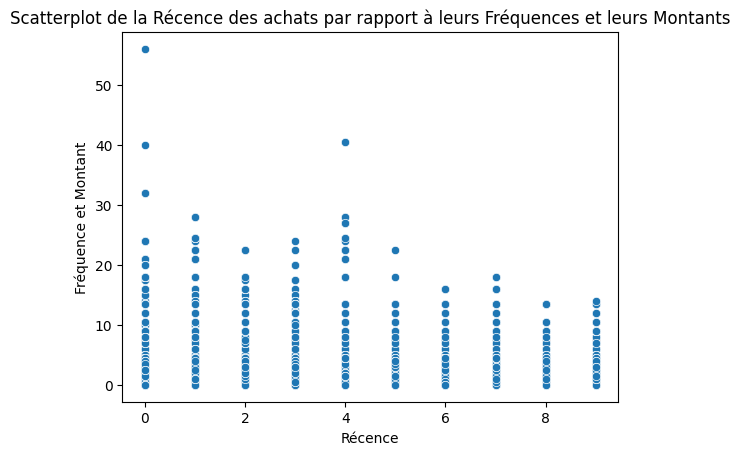

In [65]:
sns.scatterplot(df_final_merged_4,x='decile_days_diff',y='Fréquence et Montant')
plt.title('Scatterplot de la Récence des achats par rapport à leurs Fréquences et leurs Montants')
plt.xlabel('Récence')

In [66]:
# def assign_category(client):
#     if (df_final_merged_4['decile_days_diff'] >= 4) & (df_final_merged_4['Fréquence et Montant'] >= 4) & (df_final_merged_4['decile_days_diff'] <= 5) & (df_final_merged_4['Fréquence et Montant'] <= 5):
#         return 'Champions'
#     elif (df_final_merged_4['decile_days_diff'] >= 2) & (df_final_merged_4['Fréquence et Montant'] >= 3) & (df_final_merged_4['decile_days_diff'] <= 5) & (df_final_merged_4['Fréquence et Montant'] <= 5):
#         return 'Clients fidèles'
#     elif (df_final_merged_4['decile_days_diff'] >= 3) & (df_final_merged_4['Fréquence et Montant'] >= 1) & (df_final_merged_4['decile_days_diff'] <= 5) & (df_final_merged_4['Fréquence et Montant'] <= 3):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 4) & (df_final_merged_4['Fréquence et Montant'] >= 0) & (df_final_merged_4['decile_days_diff'] <= 5) & (df_final_merged_4['Fréquence et Montant'] <= 1):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 3) & (df_final_merged_4['Fréquence et Montant'] >= 0) & (df_final_merged_4['decile_days_diff'] <= 4) & (df_final_merged_4['Fréquence et Montant'] <= 1):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 2) & (df_final_merged_4['Fréquence et Montant'] >= 2) & (df_final_merged_4['decile_days_diff'] <= 3) & (df_final_merged_4['Fréquence et Montant'] <= 3):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 2) & (df_final_merged_4['Fréquence et Montant'] >= 0) & (df_final_merged_4['decile_days_diff'] <= 3) & (df_final_merged_4['Fréquence et Montant'] <= 2):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 0) & (df_final_merged_4['Fréquence et Montant'] >= 2) & (df_final_merged_4['decile_days_diff'] <= 2) & (df_final_merged_4['Fréquence et Montant'] <= 5):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 0) & (df_final_merged_4['Fréquence et Montant'] >= 4) & (df_final_merged_4['decile_days_diff'] <= 1) & (df_final_merged_4['Fréquence et Montant'] <= 5):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 1) & (df_final_merged_4['Fréquence et Montant'] >= 1) & (df_final_merged_4['decile_days_diff'] <= 2) & (df_final_merged_4['Fréquence et Montant'] <= 2):
#         return 'Hospital'
#     elif (df_final_merged_4['decile_days_diff'] >= 0) & (df_final_merged_4['Fréquence et Montant'] >= 2) & (df_final_merged_4['decile_days_diff'] <= 2) & (df_final_merged_4['Fréquence et Montant'] <= 2):
#         return 'Hospital'
#     else:
#         return 'Other'

# # Appliquer la fonction assign_category à la colonne "LargestPropertyUseType" pour créer une nouvelle colonne "Category"
# df_final_merged_4['Category'] = df_final_merged_4['decile_days_diff'].apply(assign_category)

# # Montre les nouvelles valeurs uniques au sein de la colonne Category
# print(df_final_merged_4['Category'].unique())

# df_final_merged_4.head()


In [67]:
# def assign_category(row):  # Remplacez 'client' par 'row'
#     if (row['decile_days_diff'] >= 4) & (row['Fréquence et Montant'] >= 4):
#         return 'Champions'
#     elif (row['decile_days_diff'] >= 2) & (row['Fréquence et Montant'] >= 3):
#         return 'Clients fidèles'
#     elif (row['decile_days_diff'] >= 3) & (row['Fréquence et Montant'] <= 3) :
#         return 'Clients potentiellement fidèles'
#     elif (row['decile_days_diff'] >= 4) & (row['Fréquence et Montant'] <= 1):
#         return 'Clients récents'
#     elif (row['decile_days_diff'] >= 3) & (row['Fréquence et Montant'] <= 1) :
#         return 'Clients prometteurs'
#     elif (row['decile_days_diff'] >= 2) & (row['decile_days_diff'] <= 3) & (row['Fréquence et Montant'] >= 2) & (row['Fréquence et Montant'] <= 3):
#         return 'Clients qui méritent une attention'
#     elif (row['decile_days_diff'] >= 2) & (row['decile_days_diff'] <= 3) & (row['Fréquence et Montant'] <= 2) :
#         return 'Clients sur le point de s’endormir'
#     elif (row['decile_days_diff'] <= 2) & (row['Fréquence et Montant'] >= 2):
#         return 'Clients à risque'
#     elif (row['decile_days_diff'] <= 1) & (row['Fréquence et Montant'] >= 4):
#         return 'Clients que vous ne devez pas perdre'
#     elif (row['decile_days_diff'] >= 1) & (row['decile_days_diff'] <= 2) & (row['Fréquence et Montant'] >= 1) & (row['Fréquence et Montant'] <= 2):
#         return 'Clients en hibernation'
#     elif (row['decile_days_diff'] <= 2) & (row['Fréquence et Montant'] <= 2):
#         return 'Clients perdus'
#     else:
#         return 'Other'

In [68]:
# df_final_merged_4['Category'] = df_final_merged_4.apply(assign_category, axis=1)


In [69]:
# # Montre les nouvelles valeurs uniques au sein de la colonne Category
# print(df_final_merged_4['Category'].unique())

# df_final_merged_4.head()

/////

**Correction pour Récence**

////

In [70]:
# def assign_category(row):  # Remplacez 'client' par 'row'
#     if (row['decile_days_diff'] <= 2) & (row['Fréquence et Montant'] >= 4):
#         return 'Champions'
#     elif (row['decile_days_diff'] <= 6) & (row['Fréquence et Montant'] >= 3):
#         return 'Clients fidèles'
#     elif (row['decile_days_diff'] <= 4) & (row['Fréquence et Montant'] <= 3) & (row['Fréquence et Montant'] > 1) :
#         return 'Clients potentiellement fidèles'
#     elif (row['decile_days_diff'] <= 2) & (row['Fréquence et Montant'] <= 1):
#         return 'Clients récents'
#     elif (row['decile_days_diff'] > 2) & (row['decile_days_diff'] <= 4) & (row['Fréquence et Montant'] <= 1) :
#         return 'Clients prometteurs'
#     elif (row['decile_days_diff'] >= 4) & (row['decile_days_diff'] <= 6) & (row['Fréquence et Montant'] >= 2) & (row['Fréquence et Montant'] <= 3):
#         return 'Clients qui méritent une attention'
#     elif (row['decile_days_diff'] >= 4) & (row['decile_days_diff'] <= 6) & (row['Fréquence et Montant'] <= 2) :
#         return 'Clients sur le point de s’endormir'
#     elif (row['decile_days_diff'] >= 6) & (row['Fréquence et Montant'] >= 2) & (row['Fréquence et Montant'] <= 4):
#         return 'Clients à risque'
#     elif (row['decile_days_diff'] >= 8) & (row['Fréquence et Montant'] > 4):
#         return 'Clients que vous ne devez pas perdre'
#     elif (row['decile_days_diff'] >= 6) & (row['decile_days_diff'] <= 8) & (row['Fréquence et Montant'] >= 1) & (row['Fréquence et Montant'] <= 2):
#         return 'Clients en hibernation'
#     elif (row['decile_days_diff'] >= 6) & (row['Fréquence et Montant'] <= 2):
#         return 'Clients perdus'
#     else:
#         return 'Other'

In [71]:
#Fonction pour assigner une catégorie en fonction des valeurs des colonnes 'decile_days_diff' et 'Fréquence et Montant'

def assign_category(row):
    if (row['decile_days_diff'] <= 2) & (row['Fréquence et Montant'] >= 4):
        return 'Champions'
    elif (row['decile_days_diff'] <= 6) & (row['Fréquence et Montant'] >= 3):
        return 'Clients fidèles'
    elif (row['decile_days_diff'] <= 4) & (row['Fréquence et Montant'] <= 3) & (row['Fréquence et Montant'] > 1) :
        return 'Clients potentiellement fidèles'
    elif (row['decile_days_diff'] <= 2) & (row['Fréquence et Montant'] <= 1):
        return 'Clients récents'
    elif (row['decile_days_diff'] > 2) & (row['decile_days_diff'] <= 4) & (row['Fréquence et Montant'] <= 1) :
        return 'Clients prometteurs'
    elif (row['decile_days_diff'] >= 4) & (row['decile_days_diff'] <= 6) & (row['Fréquence et Montant'] >= 2) & (row['Fréquence et Montant'] <= 3):
        return 'Clients qui méritent une attention'
    elif (row['decile_days_diff'] >= 4) & (row['decile_days_diff'] <= 6) & (row['Fréquence et Montant'] <= 2) :
        return 'Clients sur le point de s’endormir'
    elif (row['decile_days_diff'] >= 6) & (row['Fréquence et Montant'] >= 2) & (row['Fréquence et Montant'] <= 4):
        return 'Clients à risque'
    elif (row['decile_days_diff'] >= 7) & (row['Fréquence et Montant'] > 4):
        return 'Clients que vous ne devez pas perdre'
    elif (row['decile_days_diff'] >= 6) & (row['decile_days_diff'] <= 8) & (row['Fréquence et Montant'] >= 1) & (row['Fréquence et Montant'] <= 2):
        return 'Clients en hibernation'
    elif (row['decile_days_diff'] >= 6) & (row['Fréquence et Montant'] <= 2):
        return 'Clients perdus'
    else:
        return 'Other'

In [72]:
df_final_merged_4['Category 2'] = df_final_merged_4.apply(assign_category, axis=1)
# Montre les nouvelles valeurs uniques au sein de la colonne Category 2
print(df_final_merged_4['Category 2'].unique())

df_final_merged_4.head()

['Clients à risque' 'Clients fidèles' 'Champions'
 'Clients que vous ne devez pas perdre' 'Clients prometteurs'
 'Clients sur le point de s’endormir' 'Clients qui méritent une attention'
 'Clients récents' 'Clients potentiellement fidèles' 'Clients perdus'
 'Clients en hibernation']


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ... decile_client  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...             6   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...             9   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...             7   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...             7   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...             8   

  Somme des ventes  decile_vendeur  date_dernier_achat days_diff  \
0        187923.89               9 2017-05-16 15:05:35       474   
1         13685.71               9 2018-01-12 20:48:24       233   
2        187923.89               9 2018-05-19 16:07:45       106   
3        187923.89               9 2018-03-13 16:06:38       173   
4        200472.92               9 2018-07-29 09:51:30        35   

  decile_days_diff  Nombre achats effectués  Number_of_days_of_delay  \
0                9                        1                    -11.0   
1                5                        1                     -8.0   
2                2                        1                      1.0   
3                3                        1                    -13.0   
4                0                        1                     -6.0   

   Fréquence et Montant        Category 2  
0                   3.0  Clients à risque  
1                   4.5   Clients fidèles  
2                   3.5   Clients fidèles  
3                   3.5   Clients fidèles  
4                   4.0         Champions  

[5 rows x 32 columns]

In [73]:
df_final_merged_4['Category 2'].value_counts()

Category 2
Clients fidèles                         27553
Clients à risque                        15961
Clients potentiellement fidèles         15173
Champions                                9050
Clients récents                          8996
Clients perdus                           8022
Clients sur le point de s’endormir       8013
Clients prometteurs                      6211
Clients que vous ne devez pas perdre     4891
Clients en hibernation                   4435
Clients qui méritent une attention       4345
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Category 2'>

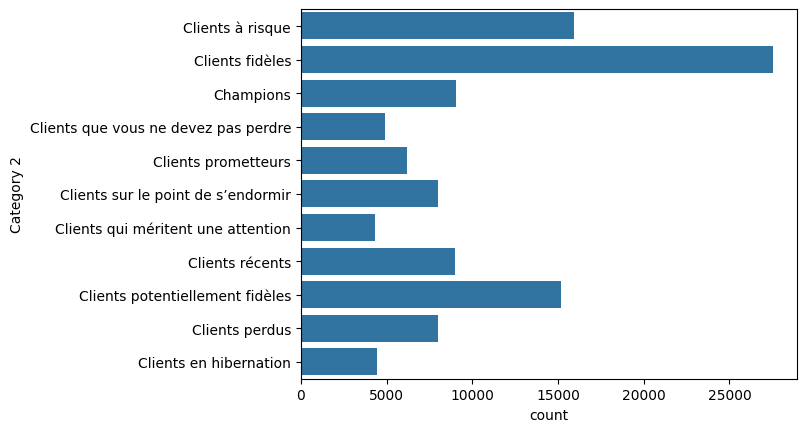

In [74]:
sns.countplot(df_final_merged_4['Category 2'])

<Axes: xlabel='count', ylabel='customer_state'>

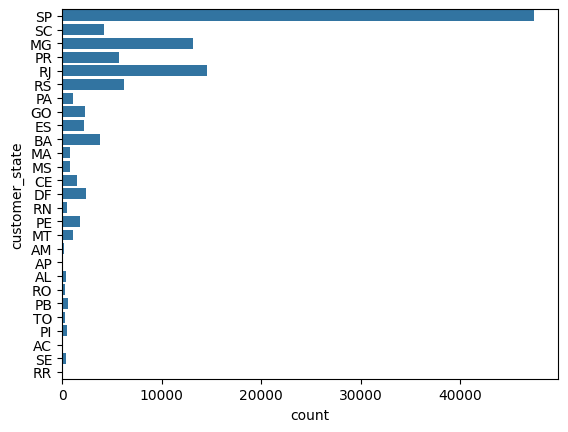

In [75]:
#Countplot du nombre de clients présents au sein de chaque État
sns.countplot(df_final_merged_4['customer_state'])

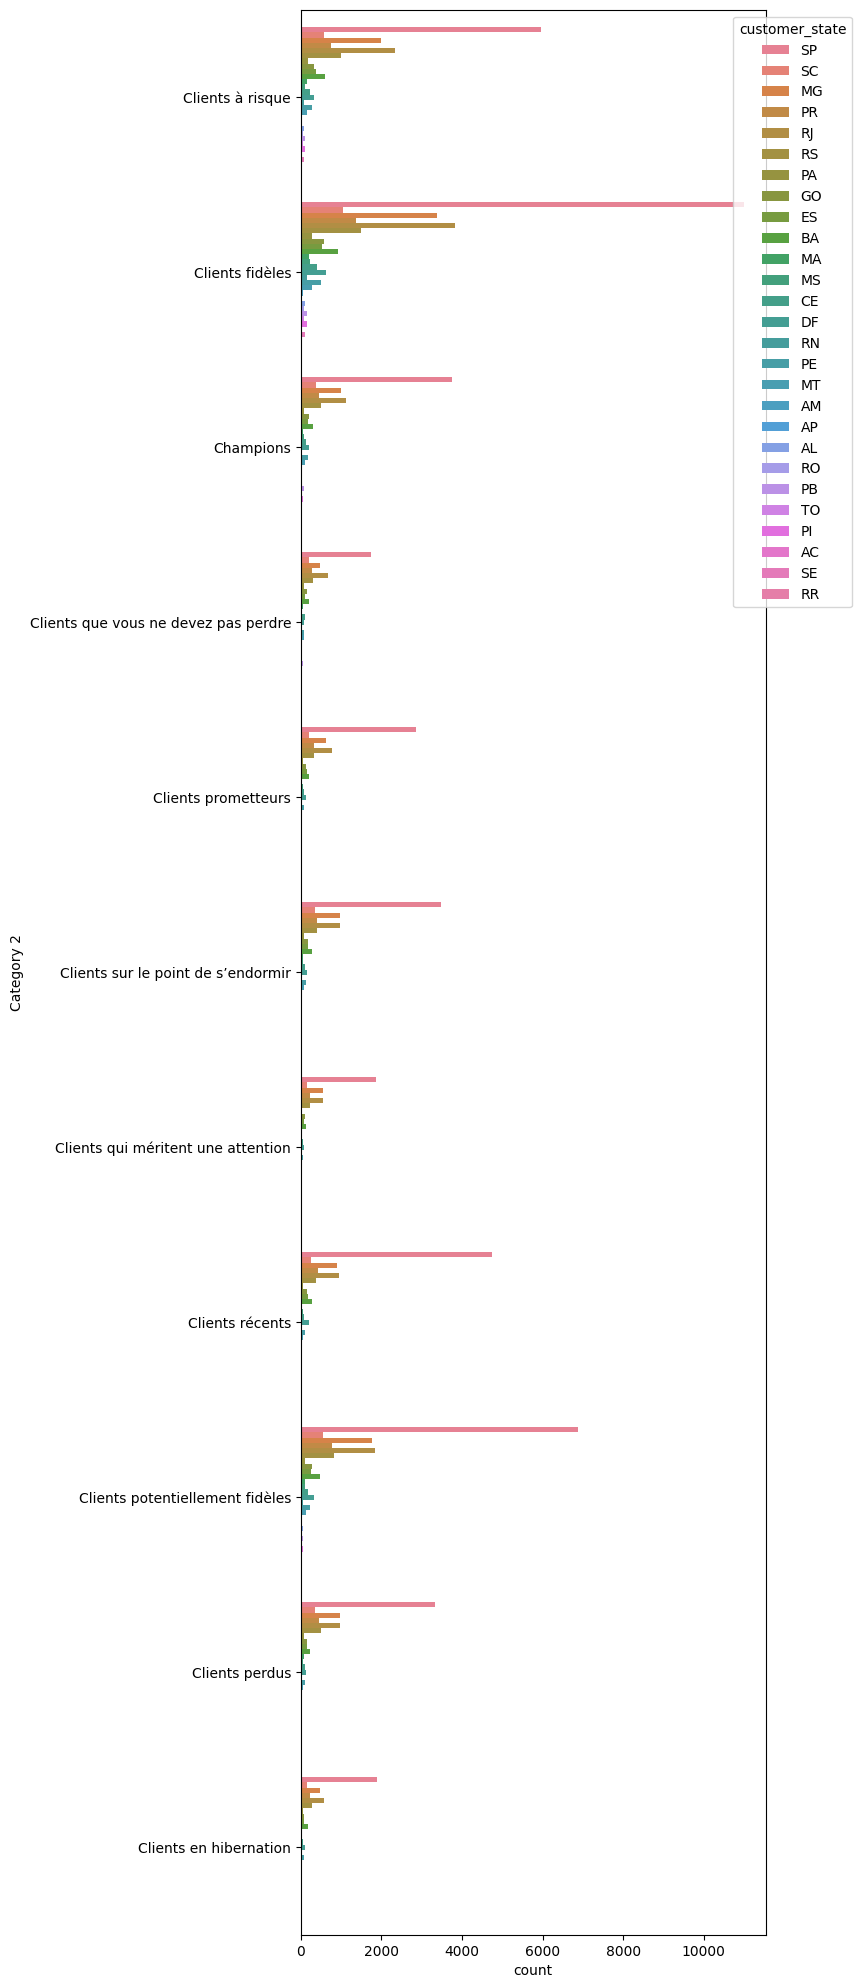

In [76]:
plt.figure(figsize=(6, 25))  # Ajustez la taille de la figure si nécessaire - j'ai inversé la largeur et la hauteur
sns.countplot(data=df_final_merged_4, y='Category 2', hue='customer_state') # Remplacez x par y
plt.yticks(rotation=0)  # Les étiquettes de l'axe y sont maintenant horizontales par défaut
plt.legend(title='customer_state', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

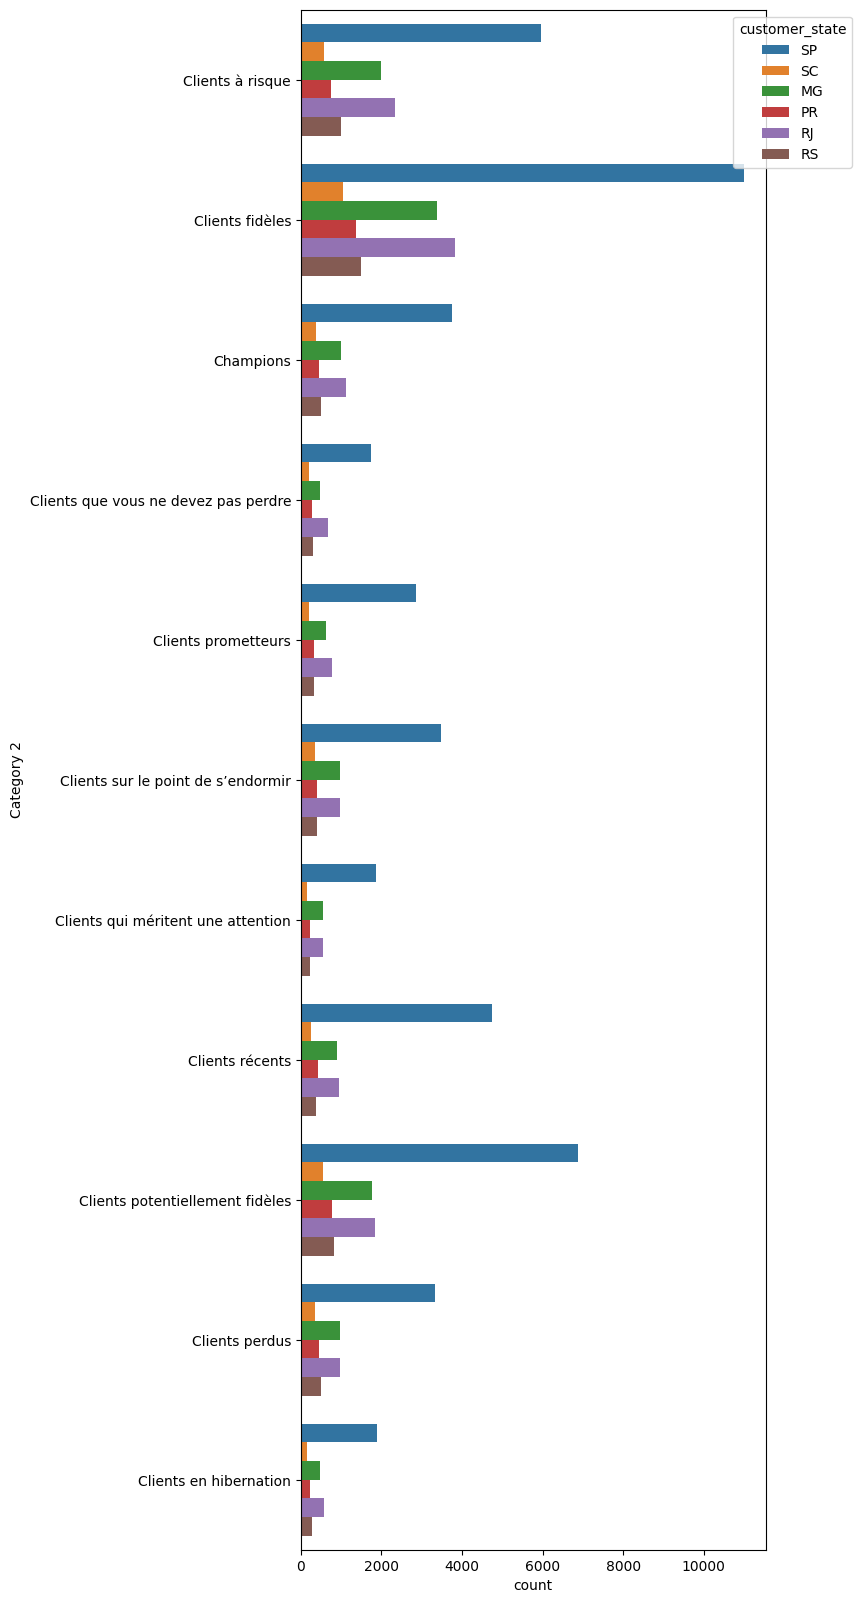

In [77]:
df_final_merged_4_filtered = df_final_merged_4[df_final_merged_4['customer_state'].isin(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS'])]
plt.figure(figsize=(6, 20))  # Ajustez la taille de la figure si nécessaire - j'ai inversé la largeur et la hauteur
sns.countplot(data=df_final_merged_4_filtered, y='Category 2', hue='customer_state') # Remplacez x par y
plt.yticks(rotation=0)  # Les étiquettes de l'axe y sont maintenant horizontales par défaut
plt.legend(title='customer_state', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

In [78]:
# top_6_cities_sp = df_final_merged_4[df_final_merged_4['customer_state'] == 'SP']['customer_city'].value_counts().head(6)
# print(top_6_cities_sp)

In [79]:
# df_final_merged_4_SP=df_final_merged_4.loc[df_final_merged_4['customer_state']=='SP']
# df_final_merged_4_SP_filtered = df_final_merged_4_SP[df_final_merged_4_SP['customer_city'].isin(top_6_cities_sp.index)]

# plt.figure(figsize=(6, 25))  # Ajustez la taille de la figure si nécessaire - j'ai inversé la largeur et la hauteur
# sns.countplot(data=df_final_merged_4_SP_filtered, y='Category 2', hue='customer_city') # Remplacez x par y
# plt.yticks(rotation=0)  # Les étiquettes de l'axe y sont maintenant horizontales par défaut
# plt.legend(title='Client Satisfaction in Sao Paulos cities', loc='upper right', bbox_to_anchor=(1.2, 1))
# plt.show()

**Scatterplot de decile_days_diff et Fréquence et Montant**

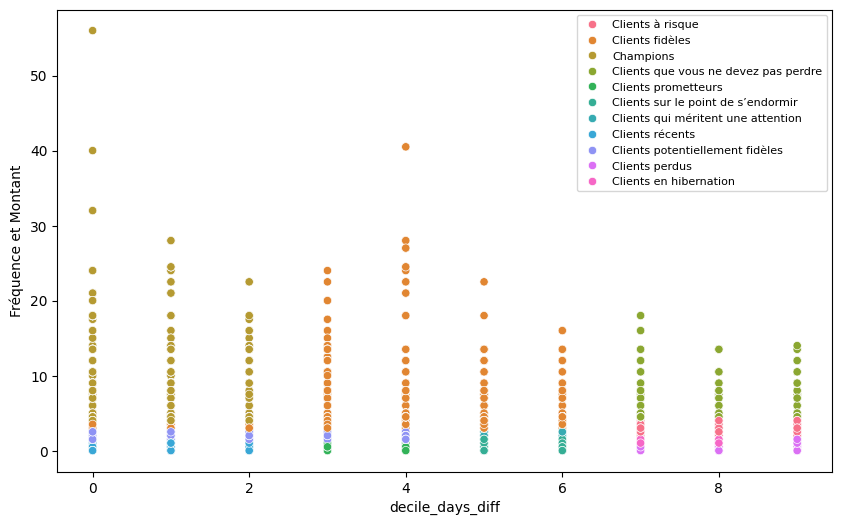

In [80]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x='decile_days_diff',y='Fréquence et Montant',data=df_final_merged_4,hue='Category 2')

plt.legend(fontsize=8)

plt.show()


In [81]:
# df_freq_mont_filtered = df_final_merged_4.loc[df_final_merged_4['Fréquence et Montant']<10]
# plt.figure(figsize=(8,4))

# sns.scatterplot(x='decile_days_diff',y='Fréquence et Montant',data=df_freq_mont_filtered,hue='Category 2')

# plt.legend(fontsize=8)

# plt.show()

In [82]:
# df_final_merged_4['Category 2'].value_counts()

In [83]:
# # 1. Obtenir les valeurs et les index de value_counts()
# values = df_final_merged_4['Category 2'].value_counts().values
# index = df_final_merged_4['Category 2'].value_counts().index

# # 2. Créer un DataFrame avec les données
# data = pd.DataFrame(values.reshape(1, -1), columns=index, index=['Count'])
# # reshape(1, -1) transforme la série en une matrice 1xN

# # 3. Créer le heatmap
# plt.figure(figsize=(10, 2))  # Ajuster la taille si besoin
# sns.heatmap(data, cmap='viridis', annot=True, fmt='d', square=True)
# plt.title('Distribution de Category 2')
# plt.ylabel('')  # Enlever le label de l'axe y
# plt.show()

In [84]:
!pip install squarify==0.4.3  # Install necessary library


In [85]:
# import squarify
# import matplotlib.pyplot as plt

# values = df_final_merged_4['Category 2'].value_counts().values
# index = df_final_merged_4['Category 2'].value_counts().index

# # Create the treemap
# plt.figure(figsize=(15,12))  # Adjust size as needed
# squarify.plot(sizes=values, label=index, alpha=.8, color=plt.cm.Spectral(values / values.max()))
# plt.title('Heatmap de la distribution des catégories de clients', fontsize=16)
# plt.axis('off')  # Remove axes
# plt.show()

In [86]:
# # Calculer la somme totale des achats
# total_clients = 112650

# # Ajouter une colonne du pourcentage
# Somme_CA_par_catégorie['Percentage'] = round(((Somme_CA_par_catégorie['Somme des achats'] / total_sales) * 100),2)


**Nombre de clients par catégorie de clients**

In [87]:
Nombre_clients_par_catégorie = df_final_merged_4.groupby('Category 2')['customer_unique_id'].nunique()
Nombre_clients_par_catégorie=Nombre_clients_par_catégorie.sort_values(ascending=False)
Nombre_clients_par_catégorie=Nombre_clients_par_catégorie.reset_index()
# Calculer la somme totale des achats
total_clients = 112650

# # Ajouter une colonne du pourcentage
Nombre_clients_par_catégorie['Percentage'] = round(((Nombre_clients_par_catégorie['customer_unique_id'] / total_clients) * 100),2)
Nombre_clients_par_catégorie

Category 2  customer_unique_id  Percentage
0                        Clients fidèles               21955       19.49
1                       Clients à risque               13765       12.22
2        Clients potentiellement fidèles               13682       12.15
3                        Clients récents                8509        7.55
4                         Clients perdus                7549        6.70
5     Clients sur le point de s’endormir                7533        6.69
6                              Champions                6349        5.64
7                    Clients prometteurs                5881        5.22
8                 Clients en hibernation                4097        3.64
9     Clients qui méritent une attention                3912        3.47
10  Clients que vous ne devez pas perdre                3427        3.04

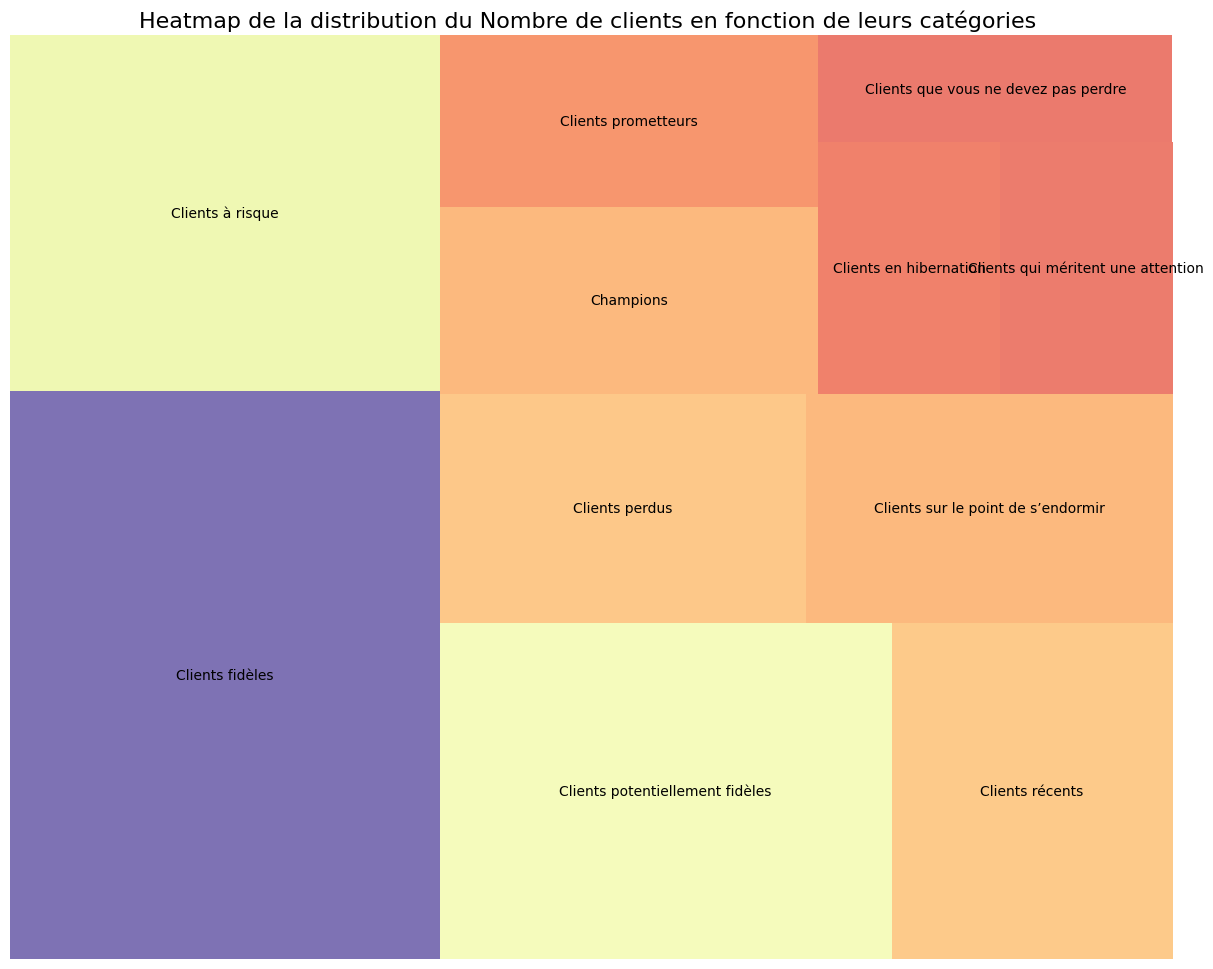

In [88]:
import squarify

# Create the treemap
values = df_final_merged_4['Category 2'].value_counts().values

plt.figure(figsize=(15,12))  # Adjust size as needed
squarify.plot(sizes=Nombre_clients_par_catégorie['Percentage'], label=Nombre_clients_par_catégorie['Category 2'], alpha=0.8, color=plt.cm.Spectral(values / values.max()))
plt.title('Heatmap de la distribution du Nombre de clients en fonction de leurs catégories ', fontsize=16)
plt.axis('off')  # Remove axes
plt.show()

**CA Total par catégorie de clients**

In [89]:
Somme_CA_par_catégorie= df_final_merged_4.groupby(['Category 2'])['Somme des achats'].sum()
Somme_CA_par_catégorie.sort_values(ascending=False)

Category 2
Clients fidèles                         6284860.33
Champions                               3408895.30
Clients que vous ne devez pas perdre    2633800.00
Clients à risque                        2085659.53
Clients potentiellement fidèles         1165512.73
Clients qui méritent une attention       369499.07
Clients sur le point de s’endormir       310791.73
Clients récents                          285435.67
Clients perdus                           255393.66
Clients en hibernation                   232270.45
Clients prometteurs                      198779.90
Name: Somme des achats, dtype: float64

In [90]:
Somme_CA_par_catégorie =Somme_CA_par_catégorie.reset_index()
Somme_CA_par_catégorie

Category 2  Somme des achats
0                              Champions        3408895.30
1                 Clients en hibernation         232270.45
2                        Clients fidèles        6284860.33
3                         Clients perdus         255393.66
4        Clients potentiellement fidèles        1165512.73
5                    Clients prometteurs         198779.90
6   Clients que vous ne devez pas perdre        2633800.00
7     Clients qui méritent une attention         369499.07
8                        Clients récents         285435.67
9     Clients sur le point de s’endormir         310791.73
10                      Clients à risque        2085659.53

In [91]:
# Calculer la somme totale des achats
total_sales = Somme_CA_par_catégorie['Somme des achats'].sum()

# Ajouter une colonne du pourcentage
Somme_CA_par_catégorie['Percentage'] = round(((Somme_CA_par_catégorie['Somme des achats'] / total_sales) * 100),2)

# Afficher le résultat
display(Somme_CA_par_catégorie.sort_values(by='Percentage',ascending=False))

Category 2  Somme des achats  Percentage
2                        Clients fidèles        6284860.33       36.47
0                              Champions        3408895.30       19.78
6   Clients que vous ne devez pas perdre        2633800.00       15.29
10                      Clients à risque        2085659.53       12.10
4        Clients potentiellement fidèles        1165512.73        6.76
7     Clients qui méritent une attention         369499.07        2.14
9     Clients sur le point de s’endormir         310791.73        1.80
8                        Clients récents         285435.67        1.66
3                         Clients perdus         255393.66        1.48
1                 Clients en hibernation         232270.45        1.35
5                    Clients prometteurs         198779.90        1.15

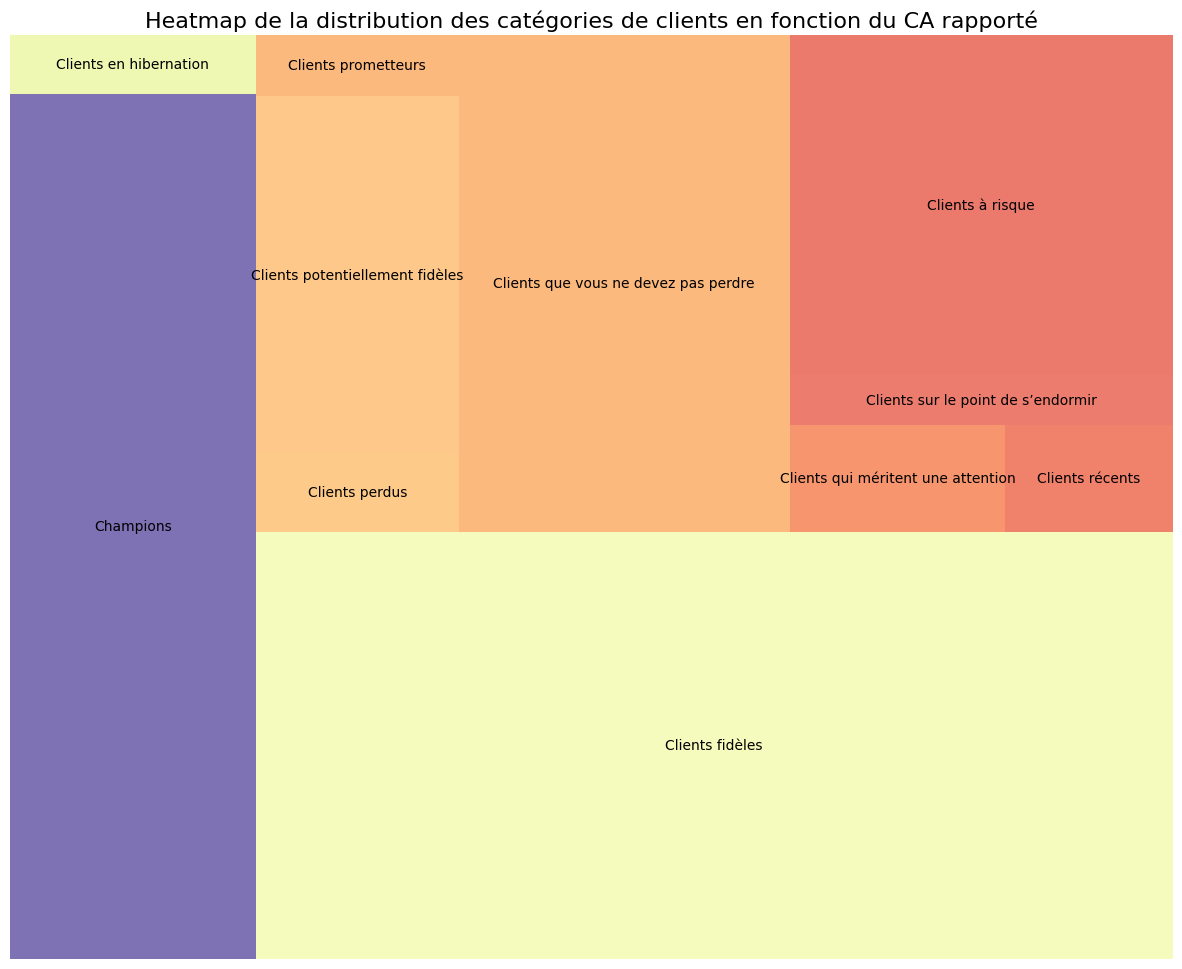

In [92]:
# Create the treemap
plt.figure(figsize=(15,12))  # Adjust size as needed
squarify.plot(sizes=Somme_CA_par_catégorie['Percentage'], label=Somme_CA_par_catégorie['Category 2'], alpha=.8, color=plt.cm.Spectral(values / values.max()))
plt.title('Heatmap de la distribution des catégories de clients en fonction du CA rapporté', fontsize=16)
plt.axis('off')  # Remove axes
plt.show()

In [93]:
Clients_all_stats = Somme_CA_par_catégorie.merge(Nombre_clients_par_catégorie,on='Category 2')
Clients_all_stats = Clients_all_stats.rename(columns={
    'Percentage_x': 'Pourcentage du CA/au CA Total',
    'customer_unique_id':'Nombre de clients',
    'Percentage_y': 'Pourcentage du nombre de clients/Nombre total de clients'
})
Clients_all_stats.sort_values('Somme des achats', ascending=False)

Category 2  Somme des achats  \
2                        Clients fidèles        6284860.33   
0                              Champions        3408895.30   
6   Clients que vous ne devez pas perdre        2633800.00   
10                      Clients à risque        2085659.53   
4        Clients potentiellement fidèles        1165512.73   
7     Clients qui méritent une attention         369499.07   
9     Clients sur le point de s’endormir         310791.73   
8                        Clients récents         285435.67   
3                         Clients perdus         255393.66   
1                 Clients en hibernation         232270.45   
5                    Clients prometteurs         198779.90   

    Pourcentage du CA/au CA Total  Nombre de clients  \
2                           36.47              21955   
0                           19.78               6349   
6                           15.29               3427   
10                          12.10              13765   
4                            6.76              13682   
7                            2.14               3912   
9                            1.80               7533   
8                            1.66               8509   
3                            1.48               7549   
1                            1.35               4097   
5                            1.15               5881   

    Pourcentage du nombre de clients/Nombre total de clients  
2                                               19.49         
0                                                5.64         
6                                                3.04         
10                                              12.22         
4                                               12.15         
7                                                3.47         
9                                                6.69         
8                                                7.55         
3                                                6.70         
1                                                3.64         
5                                                5.22

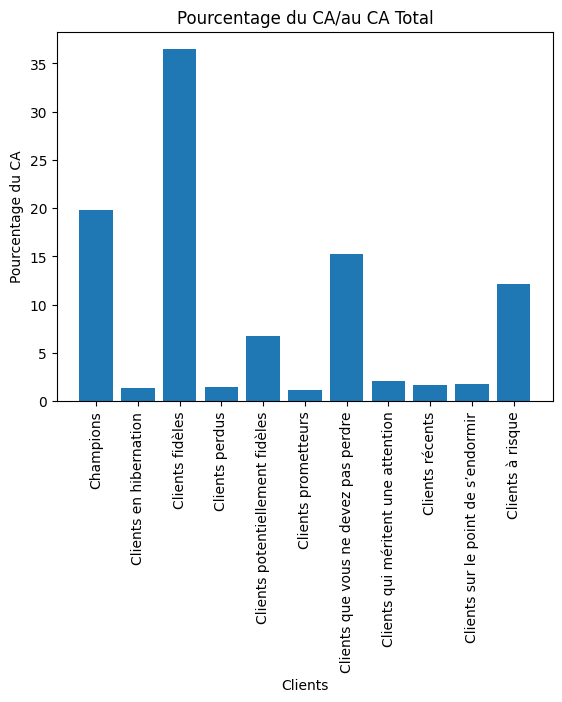

In [94]:

## Créez le diagramme à barres
plt.bar(Clients_all_stats['Category 2'], Clients_all_stats["Pourcentage du CA/au CA Total"])

# Ajoutez un titre et des étiquettes d'axe
plt.title("Pourcentage du CA/au CA Total")
plt.xlabel("Clients")
plt.ylabel("Pourcentage du CA")

# Faites pivoter les étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=90)

# Affichez le diagramme à barres
plt.show()

In [95]:
# # Triez le DataFrame par la colonne "Pourcentage du CA/au CA Total" par ordre décroissant
# df_clients_all_stats = Clients_all_stats.sort_values(by="Pourcentage du CA/au CA Total", ascending=False)

# # Créez le diagramme à barres horizontales
# plt.barh(df_clients_all_stats['Category 2'], df_clients_all_stats["Pourcentage du CA/au CA Total"])

# # Ajoutez un titre et des étiquettes d'axe
# plt.title("Pourcentage du CA/au CA Total")
# plt.ylabel("Clients")
# plt.xlabel("Pourcentage du CA")

# # Ajustez la disposition pour une meilleure lisibilité
# plt.tight_layout()

# # Affichez le diagramme à barres
# plt.show()

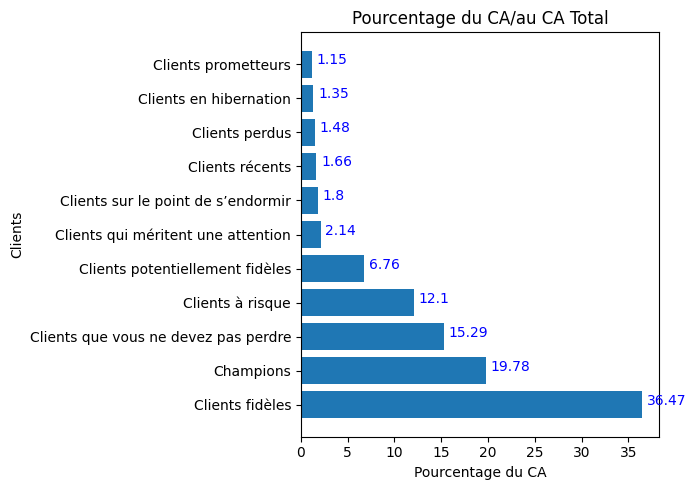

In [96]:
plt.figure(figsize=(7,5))


# Triez le DataFrame par la colonne "Pourcentage du CA/au CA Total" par ordre décroissant
df_clients_all_stats = Clients_all_stats.sort_values(by="Pourcentage du CA/au CA Total", ascending=False)

# Créez le diagramme à barres horizontales
plt.barh(df_clients_all_stats['Category 2'], df_clients_all_stats["Pourcentage du CA/au CA Total"])

# Ajoutez un titre et des étiquettes d'axe
plt.title("Pourcentage du CA/au CA Total")
plt.ylabel("Clients")
plt.xlabel("Pourcentage du CA")

# Ajoutez les labels (valeurs) sur les barres
for i, v in enumerate(df_clients_all_stats["Pourcentage du CA/au CA Total"]):
    plt.text(v + 0.5, i, str(v), color='blue', fontweight='normal') # Ajustez 0.1 pour l'espacement

# Ajustez la disposition pour une meilleure lisibilité
plt.tight_layout()

# Affichez le diagramme à barres
plt.show()

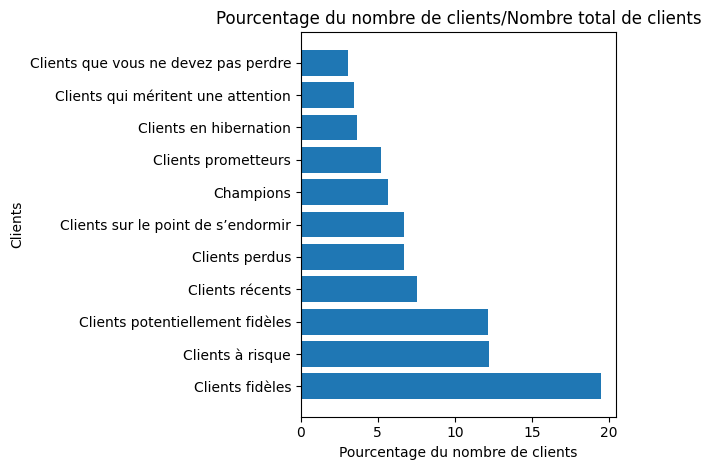

In [97]:
df_clients_all_stats_bis = Clients_all_stats.sort_values(by="Pourcentage du nombre de clients/Nombre total de clients", ascending=False)

# Créez le diagramme à barres horizontales
plt.barh(df_clients_all_stats_bis['Category 2'], df_clients_all_stats_bis["Pourcentage du nombre de clients/Nombre total de clients"])

# Ajoutez un titre et des étiquettes d'axe
plt.title("Pourcentage du nombre de clients/Nombre total de clients")
plt.ylabel("Clients")
plt.xlabel("Pourcentage du nombre de clients")

# Ajustez la disposition pour une meilleure lisibilité
plt.tight_layout()

# Affichez le diagramme à barres
plt.show()

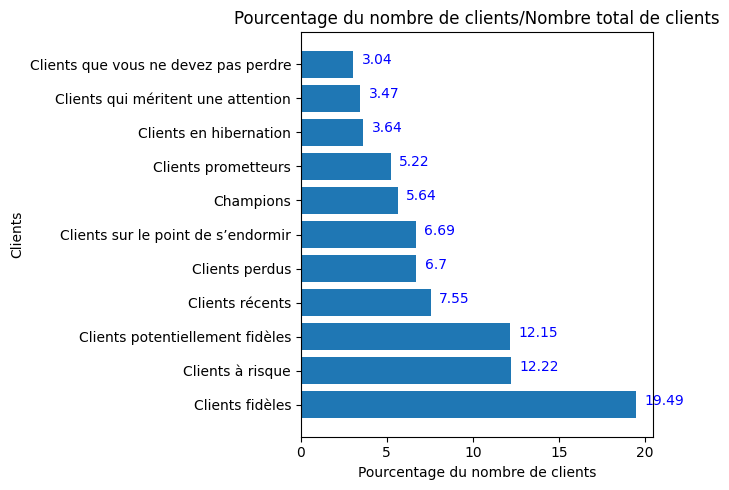

In [98]:
df_clients_all_stats_bis = Clients_all_stats.sort_values(by="Pourcentage du nombre de clients/Nombre total de clients", ascending=False)

plt.figure(figsize=(7,5))

# Créez le diagramme à barres horizontales
plt.barh(df_clients_all_stats_bis['Category 2'], df_clients_all_stats_bis["Pourcentage du nombre de clients/Nombre total de clients"])

# Ajoutez un titre et des étiquettes d'axe
plt.title("Pourcentage du nombre de clients/Nombre total de clients")
plt.ylabel("Clients")
plt.xlabel("Pourcentage du nombre de clients")

# Ajoutez les labels (valeurs) sur les barres
for i, v in enumerate(df_clients_all_stats_bis["Pourcentage du nombre de clients/Nombre total de clients"]):
    plt.text(v + 0.5, i, str(v), color='blue', fontweight='normal') # Ajustez 0.1 pour l'espacement

# Ajustez la disposition pour une meilleure lisibilité
plt.tight_layout()

# Affichez le diagramme à barres
plt.show()

In [99]:
df_final_merged_4['customer_unique_id'].nunique()


95420

**//////**

**Fusion avec les derniers dataframe df_order_review et df_product_category**

**/////**

In [100]:
print(df_final_merged_4.columns)
display(df_products.head())
display(df_product_category.head())


Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'Somme des achats', 'decile_client', 'Somme des ventes',
       'decile_vendeur', 'date_dernier_achat', 'days_diff', 'decile_days_diff',
       'Nombre achats effectués', 'Number_of_days_of_delay',
       'Fréquence et Montant', 'Category 2'],
      dtype='object')


product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [101]:
df_products_bis=df_products.loc[:,['product_id','product_category_name']]
df_final_merged_5=df_final_merged_4.merge(df_products_bis,on='product_id').merge(df_product_category,on='product_category_name')
df_final_merged_5=df_final_merged_5.drop('product_category_name',axis=1)
df_final_merged_5 = df_final_merged_5.rename(columns={'product_category_name_english': 'Catégorie de produit'})
df_final_merged_5.head()


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ... Somme des ventes  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...        187923.89   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...         13685.71   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...        187923.89   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...        187923.89   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...        200472.92   

  decile_vendeur  date_dernier_achat days_diff decile_days_diff  \
0              9 2017-05-16 15:05:35       474                9   
1              9 2018-01-12 20:48:24       233                5   
2              9 2018-05-19 16:07:45       106                2   
3              9 2018-03-13 16:06:38       173                3   
4              9 2018-07-29 09:51:30        35                0   

  Nombre achats effectués  Number_of_days_of_delay  Fréquence et Montant  \
0                       1                    -11.0                   3.0   
1                       1                     -8.0                   4.5   
2                       1                      1.0                   3.5   
3                       1                    -13.0                   3.5   
4                       1                     -6.0                   4.0   

         Category 2 Catégorie de produit  
0  Clients à risque     office_furniture  
1   Clients fidèles           housewares  
2   Clients fidèles     office_furniture  
3   Clients fidèles     office_furniture  
4         Champions         home_confort  

[5 rows x 33 columns]

In [102]:
# plt.figure(figsize=(10,10))
# sns.countplot(df_final_merged_5['Catégorie de produit'])

In [103]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Get the category counts in descending order
# category_counts = df_final_merged_5['Catégorie de produit'].value_counts().sort_values(ascending=False)

# # Create the countplot with 'y' instead of 'x' and order
# plt.figure(figsize=(12, 16))  # Adjust size as needed
# sns.countplot(y='Catégorie de produit', data=df_final_merged_5,
#               order=category_counts.index)  # Order by category_counts index
# plt.title('Distribution de la Catégorie de produit', fontsize=16)
# plt.tight_layout()  # Adjust layout for better label visibility
# plt.show()

In [104]:
df_final_merged_5['Catégorie de produit'].value_counts()

Catégorie de produit
bed_bath_table               11115
health_beauty                 9670
sports_leisure                8641
furniture_decor               8334
computers_accessories         7827
                             ...  
arts_and_craftmanship           24
la_cuisine                      14
cds_dvds_musicals               14
fashion_childrens_clothes        8
security_and_services            2
Name: count, Length: 71, dtype: int64

In [105]:
df_final_merged_6 = df_final_merged_5.merge(df_order_review,on='order_id')
df_final_merged_6.head()


customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ...  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...   

  Number_of_days_of_delay Fréquence et Montant        Category 2  \
0                   -11.0                  3.0  Clients à risque   
1                    -8.0                  4.5   Clients fidèles   
2                     1.0                  3.5   Clients fidèles   
3                   -13.0                  3.5   Clients fidèles   
4                    -6.0                  4.0         Champions   

  Catégorie de produit                         review_id review_score  \
0     office_furniture  88b8b52d46df026a9d1ad2136a59b30b            4   
1           housewares  02fc48a9efa3e3d0f1a8ea26507eeec3            5   
2     office_furniture  5ad6695d76ee186dc473c42706984d87            5   
3     office_furniture  059a801bb31f6aab2266e672cab87bc5            5   
4         home_confort  8490879d58d6c5d7773f2739a03f089a            5   

   review_comment_title                         review_comment_message  \
0                   NaN                                            NaN   
1                   NaN                                            NaN   
2                   NaN                                            NaN   
3                   NaN                                            NaN   
4         a melhor nota  O baratheon è esxelente Amo adoro o baratheon   

   review_creation_date review_answer_timestamp  
0   2017-05-26 00:00:00     2017-05-30 22:34:40  
1   2018-01-30 00:00:00     2018-02-10 22:43:29  
2   2018-06-15 00:00:00     2018-06-15 12:10:59  
3   2018-03-29 00:00:00     2018-04-02 18:36:47  
4   2018-08-10 00:00:00     2018-08-17 01:59:52  

[5 rows x 39 columns]

**//////**

**Observations de la corrélation entre le nombre de jours de retard et le review_score**

**////// **

In [106]:
df_late=df_final_merged_6.loc[df_final_merged_6['Number_of_days_of_delay']>5]
df_late['review_score'].mean()

1.7358774792869696

In [107]:
df_advanced=df_final_merged_6.loc[df_final_merged_6['Number_of_days_of_delay']<0]
df_advanced['review_score'].mean()

4.2121893680401445

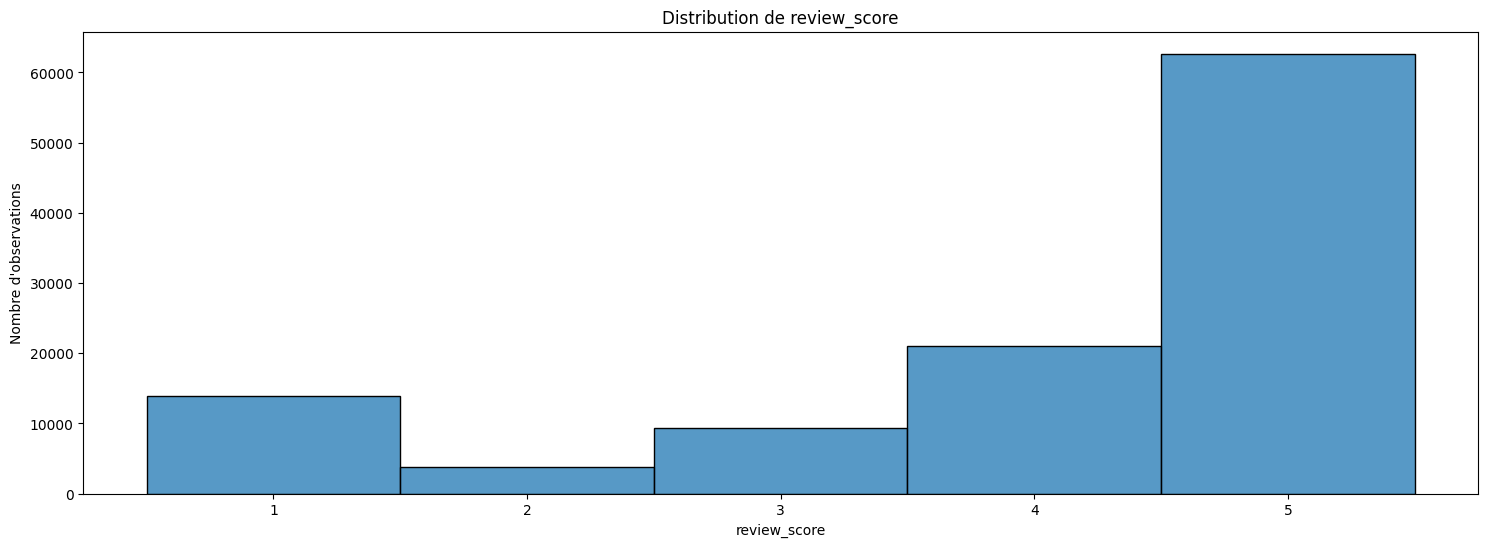

In [108]:
# Histogramme pour 'review_score'
plt.figure(figsize=(18, 6))
sns.histplot(df_final_merged_6['review_score'], bins=2, discrete=True)
plt.title('Distribution de review_score')
plt.xlabel('review_score')
plt.ylabel('Nombre d\'observations')
plt.show()

In [109]:
# df_final_merged_6_filtered = df_final_merged_6[(df_final_merged_6['Number_of_days_of_delay'] >= -50) & (df_final_merged_6['Number_of_days_of_delay'] <= 50)]
# sns.boxplot(x='review_score', y='Number_of_days_of_delay', data=df_final_merged_6_filtered)
# plt.show()

In [110]:
# #Scatterplot entre 'review_score' et 'Number_of_days_of_delay'
# sns.scatterplot(x='review_score', y='Number_of_days_of_delay', data=df_final_merged_6)
# plt.show()

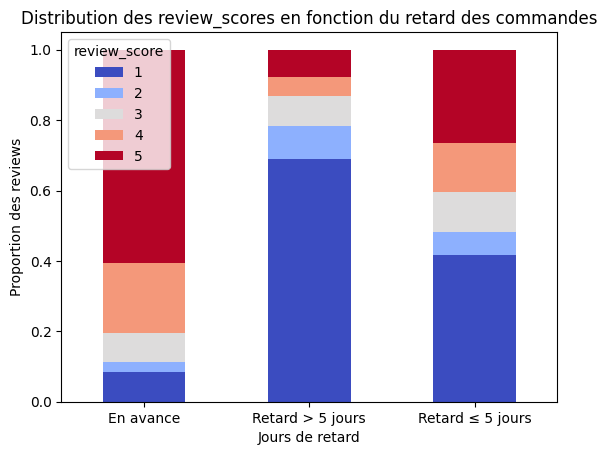

In [111]:
#Normaliser les proportions pour visualiser clairement la relation entre les jours de retards et le review_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_test=df_final_merged_6.copy()
# Grouper par retard et review_score
df_test['late_category'] = df_test['Number_of_days_of_delay'].apply(lambda x: 'En avance' if x < 0 else ('Retard > 5 jours' if x > 5 else 'Retard ≤ 5 jours'))
review_counts = df_test.groupby(['late_category', 'review_score']).size().unstack()

# Normalisation des proportions
review_counts = review_counts.div(review_counts.sum(axis=1), axis=0)

# Visualisation
review_counts.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title("Distribution des review_scores en fonction du retard des commandes")
plt.xlabel("Jours de retard")

plt.ylabel("Proportion des reviews")
plt.xticks(rotation=0)  # Les étiquettes de l'axe y sont maintenant horizontales par défaut

plt.show()

**Pire vendeur (avec les scores de reviews les moins bons)**

In [112]:
# df_vendeur = df_final_merged_6.groupby('seller_id')['review_score'].mean()
# df_sort=df_vendeur.sort_values(ascending=True)
# df_sort.head()

In [113]:
# sns.histplot(df_sort, bins=2, discrete=True)

<Axes: xlabel='review_score', ylabel='Count'>

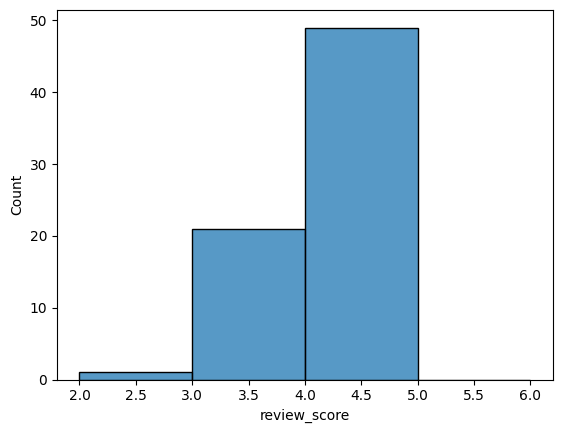

In [114]:
df_category_product = df_final_merged_6.groupby('Catégorie de produit')['review_score'].mean()
sns.histplot(df_category_product, bins=2, discrete=True)

In [115]:
# Get the 10 worst and 10 best categories
worst_categories = df_category_product.nsmallest(10).index
best_categories = df_category_product.nlargest(10).index
display(worst_categories)
display(best_categories)
# # Create histograms
# fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# sns.histplot(df_final_merged_6[df_final_merged_6['Catégorie de produit'].isin(worst_categories)]['review_score'], ax=axes[0], bins=5)
# axes[0].set_title('10 Worst Product Categories by Review Score')

# sns.histplot(df_final_merged_6[df_final_merged_6['Catégorie de produit'].isin(best_categories)]['review_score'], ax=axes[1], bins=5)
# axes[1].set_title('10 Best Product Categories by Review Score')

# plt.tight_layout()
# plt.show()

Index(['security_and_services', 'diapers_and_hygiene', 'office_furniture',
       'home_comfort_2', 'fashion_male_clothing', 'fixed_telephony',
       'party_supplies', 'fashio_female_clothing',
       'furniture_mattress_and_upholstery', 'audio'],
      dtype='object', name='Catégorie de produit')

Index(['cds_dvds_musicals', 'fashion_childrens_clothes',
       'books_general_interest', 'costruction_tools_tools', 'flowers',
       'books_imported', 'books_technical', 'food_drink',
       'luggage_accessories', 'small_appliances_home_oven_and_coffee'],
      dtype='object', name='Catégorie de produit')

In [116]:
df_category_reset=df_category_product.sort_values().reset_index()
display(df_category_reset)

Catégorie de produit  review_score
0       security_and_services      2.500000
1         diapers_and_hygiene      3.256410
2            office_furniture      3.493183
3              home_comfort_2      3.629630
4       fashion_male_clothing      3.641221
..                        ...           ...
66                    flowers      4.419355
67    costruction_tools_tools      4.444444
68     books_general_interest      4.446266
69  fashion_childrens_clothes      4.500000
70          cds_dvds_musicals      4.642857

[71 rows x 2 columns]

In [117]:
# Select the last 10 categories
last_10_categories = df_category_reset.head(10)
display(last_10_categories)


Catégorie de produit  review_score
0              security_and_services      2.500000
1                diapers_and_hygiene      3.256410
2                   office_furniture      3.493183
3                     home_comfort_2      3.629630
4              fashion_male_clothing      3.641221
5                    fixed_telephony      3.683206
6                     party_supplies      3.767442
7             fashio_female_clothing      3.780000
8  furniture_mattress_and_upholstery      3.815789
9                              audio      3.825485

<Axes: xlabel='review_score', ylabel='Catégorie de produit'>

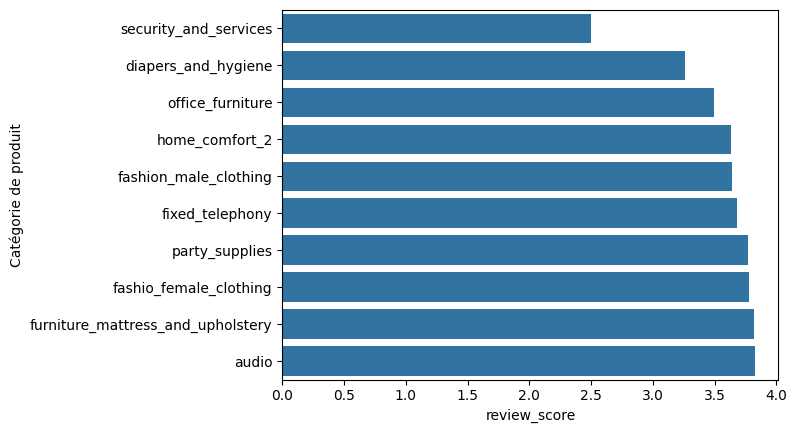

In [118]:
sns.barplot(x='review_score', y='Catégorie de produit', data=last_10_categories)


In [119]:
# Select the last 10 categories
top_10_categories = df_category_reset.tail(10)
display(top_10_categories)

Catégorie de produit  review_score
61  small_appliances_home_oven_and_coffee      4.302632
62                    luggage_accessories      4.315257
63                             food_drink      4.315412
64                        books_technical      4.368421
65                         books_imported      4.400000
66                                flowers      4.419355
67                costruction_tools_tools      4.444444
68                 books_general_interest      4.446266
69              fashion_childrens_clothes      4.500000
70                      cds_dvds_musicals      4.642857

<Axes: xlabel='review_score', ylabel='Catégorie de produit'>

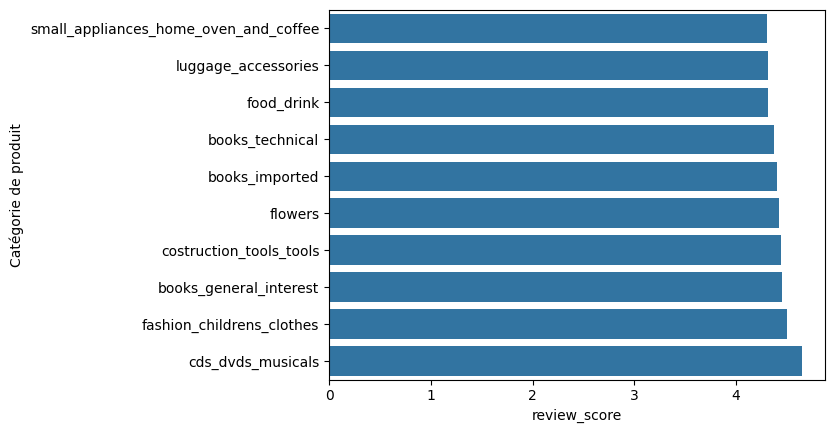

In [120]:
sns.barplot(x='review_score', y='Catégorie de produit', data=top_10_categories)


In [121]:
df_category_acheteur = df_final_merged_6.groupby('Category 2')['review_score'].mean()
display(df_category_acheteur)

Category 2
Champions                               4.039150
Clients en hibernation                  4.238504
Clients fidèles                         3.854257
Clients perdus                          4.144850
Clients potentiellement fidèles         4.062271
Clients prometteurs                     3.957606
Clients que vous ne devez pas perdre    3.935444
Clients qui méritent une attention      3.989469
Clients récents                         4.294979
Clients sur le point de s’endormir      4.084430
Clients à risque                        4.110955
Name: review_score, dtype: float64

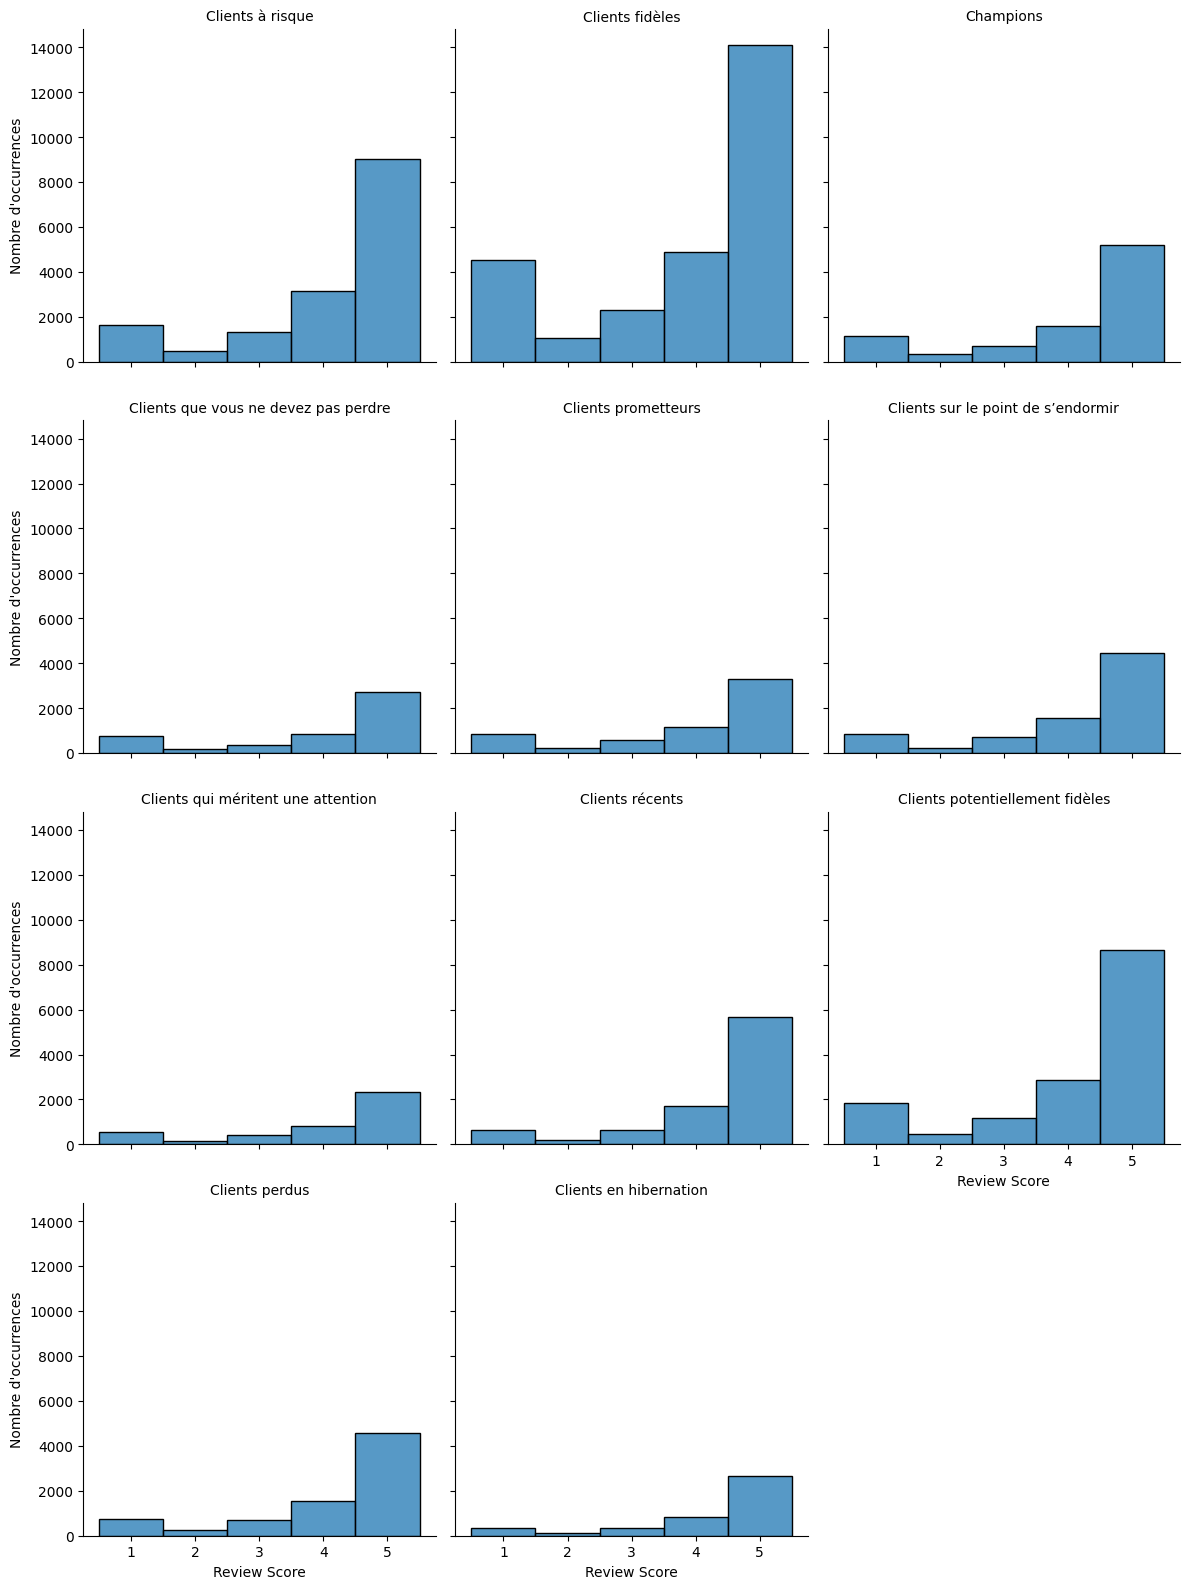

In [122]:
#Nombre de review_score par catégorie de client

g = sns.FacetGrid(df_final_merged_6, col="Category 2", col_wrap=3, sharex=True, sharey=True, height=4)
g.map(sns.histplot, "review_score", discrete=True)

g.set_titles(col_template="{col_name}")  # Affiche le nom de chaque catégorie
g.set_axis_labels("Review Score", "Nombre d'occurrences")

plt.show()

## Élaboration d'un modèle de clustering

### KMeans

### Premier Test

Première approche

In [123]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Supposons que votre DataFrame est nommé df_final_merged_4
# et qu'il contient les colonnes mentionnées.

# 1. Sélectionner les colonnes pour le clustering
X = df_final_merged_4[['Somme des achats', 'days_diff', 'Nombre achats effectués']]

# 2. Mettre à l'échelle les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Créer un modèle KMeans
# (vous devrez peut-être expérimenter avec le nombre de clusters - n_clusters)
kmeans = KMeans(n_clusters=4, random_state=0)

# 4. Ajuster le modèle aux données mises à l'échelle
kmeans.fit(X_scaled)

# 5. Obtenir les étiquettes de cluster
labels = kmeans.labels_

# 6. Ajouter les étiquettes de cluster au DataFrame original
df_final_merged_4['cluster'] = labels

In [124]:
df_final_merged_4[['Somme des achats', 'days_diff', 'Nombre achats effectués','cluster','Fréquence et Montant']]

Somme des achats  days_diff  Nombre achats effectués  cluster  \
0                 124.99        474                        1        1   
1                 289.00        233                        1        0   
2                 139.94        106                        1        0   
3                 149.94        173                        1        0   
4                 230.00         35                        1        0   
...                  ...        ...                      ...      ...   
112645             74.90        148                        1        0   
112646            114.90        152                        1        0   
112647             37.00        147                        1        0   
112648            689.00        303                        1        1   
112649             13.99        257                        1        0   

        Fréquence et Montant  
0                        3.0  
1                        4.5  
2                        3.5  
3                        3.5  
4                        4.0  
...                      ...  
112645                   2.0  
112646                   3.0  
112647                   0.5  
112648                   4.5  
112649                   0.0  

[112650 rows x 5 columns]

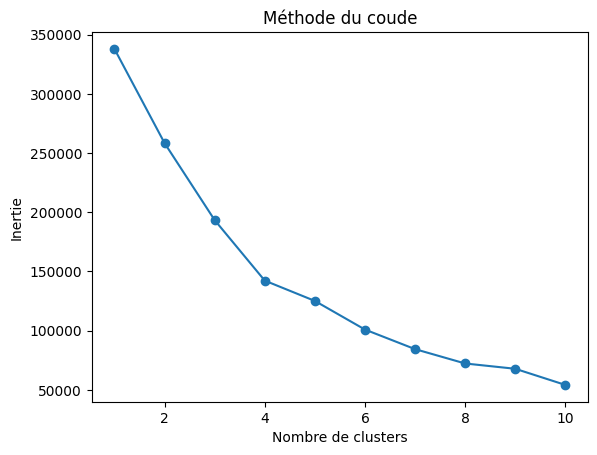

In [125]:
# Utiliser la méthode du coude pour trouver le nombre optimal de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du coude
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

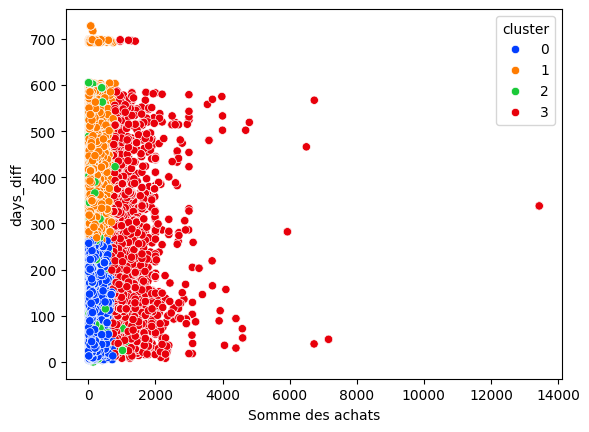

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer le scatterplot
sns.scatterplot(x='Somme des achats', y='days_diff', hue='cluster', data=df_final_merged_4, palette='bright')
plt.show()

In [127]:
df_final_merged_4['cluster'].value_counts()

cluster
0    59317
1    43171
2     7399
3     2763
Name: count, dtype: int64

**Avec LabelEncoder**

<ipython-input-128-3cba551e2e25>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-128-3cba551e2e25>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
<ipython-input-128-3cba551e2e25>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

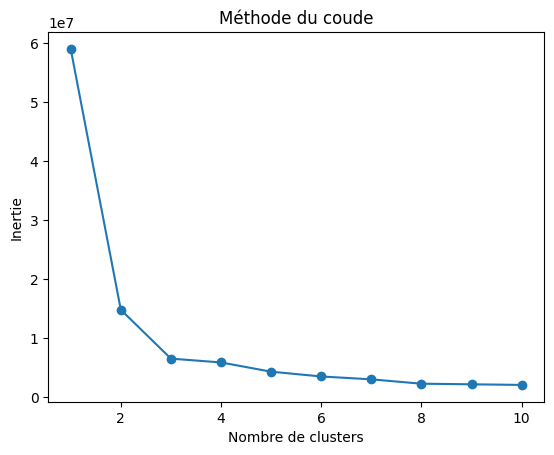

In [128]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Préparation des données

# Sélectionner les colonnes pertinentes
features = ['seller_city', 'seller_state', 'Catégorie de produit', 'Nombre achats effectués', 'price']
X = df_final_merged_6[features]
# 1. Sélectionner les colonnes pour le clustering
X = df_final_merged_6[['Somme des achats', 'days_diff', 'Nombre achats effectués','Catégorie de produit','seller_state']]

# Encoder les variables catégorielles
for col in ['seller_state', 'Catégorie de produit']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Standardiser les données numériques
scaler = StandardScaler()
X[['Somme des achats', 'days_diff', 'Nombre achats effectués']] = scaler.fit_transform(X[['Somme des achats', 'days_diff', 'Nombre achats effectués']])

# 2. Détermination du nombre optimal de clusters

# Utiliser la méthode du coude pour trouver le nombre optimal de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du coude
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

# 3. Application de KMeans avec le nombre optimal de clusters

# Instancier le modèle KMeans avec le nombre optimal de clusters (par exemple, k=3)
kmeans = KMeans(n_clusters=4, random_state=42)

# Entraîner le modèle sur les données
kmeans.fit(X)

# 4. Attribution des groupes de clients

# Ajouter la colonne 'Groupe_KMeans' au DataFrame
df_final_merged_6['Groupe_KMeans'] = kmeans.labels_

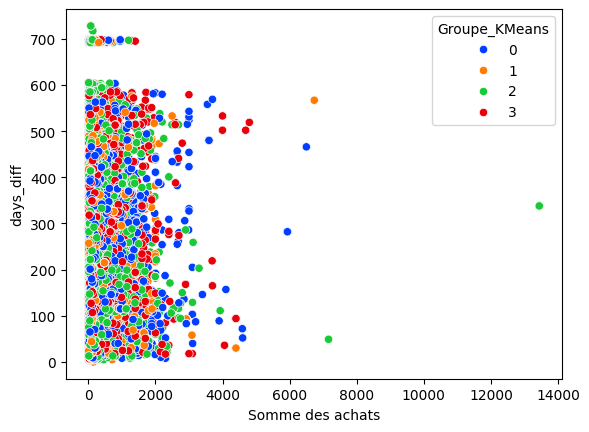

In [129]:
# Créer le scatterplot
sns.scatterplot(x='Somme des achats', y='days_diff', hue='Groupe_KMeans', data=df_final_merged_6, palette='bright')
plt.show()

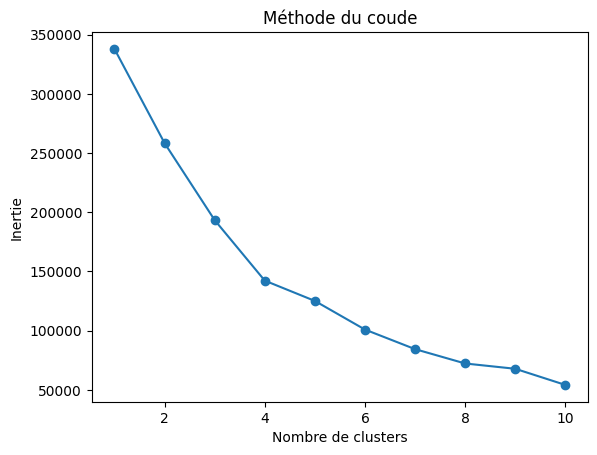

In [130]:
# Utiliser la méthode du coude pour trouver le nombre optimal de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du coude
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

In [131]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # 1. Préparation des données

# # 1. Sélectionner les colonnes pour le clustering
# X = df_final_merged_4[['Somme des achats', 'days_diff', 'Nombre achats effectués']]

# # 2. Mettre à l'échelle les données
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 3. Créer un modèle KMeans
# # (vous devrez peut-être expérimenter avec le nombre de clusters - n_clusters)
# kmeans = LabelEncoder(n_clusters=6, random_state=0)

# # 4. Ajuster le modèle aux données mises à l'échelle
# kmeans.fit(X_scaled)

# # 5. Obtenir les étiquettes de cluster
# labels = kmeans.labels_

# # 6. Ajouter les étiquettes de cluster au DataFrame original
# df_final_merged_4['cluster'] = labels

# # # 2. Détermination du nombre optimal de clusters

# # # Utiliser la méthode du coude pour trouver le nombre optimal de clusters
# # inertia = []
# # for i in range(1, 11):
# #     kmeans = KMeans(n_clusters=i, random_state=42)
# #     kmeans.fit(X)
# #     inertia.append(kmeans.inertia_)

# # # Tracer le graphique du coude
# # plt.plot(range(1, 11), inertia, marker='o')
# # plt.title('Méthode du coude')
# # plt.xlabel('Nombre de clusters')
# # plt.ylabel('Inertie')
# # plt.show()

# # # 3. Application de KMeans avec le nombre optimal de clusters

# # # Instancier le modèle KMeans avec le nombre optimal de clusters (par exemple, k=3)
# # kmeans = KMeans(n_clusters=3, random_state=42)

# # # Entraîner le modèle sur les données
# # kmeans.fit(X)

# # # 4. Attribution des groupes de clients

# # # Ajouter la colonne 'Groupe_KMeans' au DataFrame
# # df_final_merged_5['Groupe_KMeans'] = kmeans.labels_

In [132]:
# # Utiliser la méthode du coude pour trouver le nombre optimal de clusters
# inertia = []
# for i in range(1, 11):
#     LabelEncoder = LabelEncoder(n_clusters=i, random_state=42)
#     LabelEncoder.fit(X_scaled)
#     inertia.append(kmeans.inertia_)

# # Tracer le graphique du coude
# plt.plot(range(1, 11), inertia, marker='o')
# plt.title('Méthode du coude')
# plt.xlabel('Nombre de clusters')
# plt.ylabel('Inertie')
# plt.show()

<Axes: xlabel='decile_days_diff', ylabel='Fréquence et Montant'>

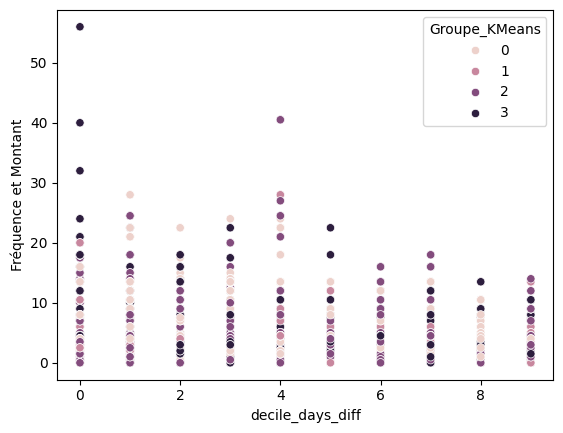

In [133]:
sns.scatterplot(x='decile_days_diff',y='Fréquence et Montant',data=df_final_merged_6,hue='Groupe_KMeans')

In [134]:
df_final_merged_6['Groupe_KMeans'].value_counts()

Groupe_KMeans
2    37533
0    35783
3    26475
1    10959
Name: count, dtype: int64

In [135]:
# df_final_merged_5.loc[:,['decile_days_diff','Fréquence et Montant','Groupe_KMeans']]

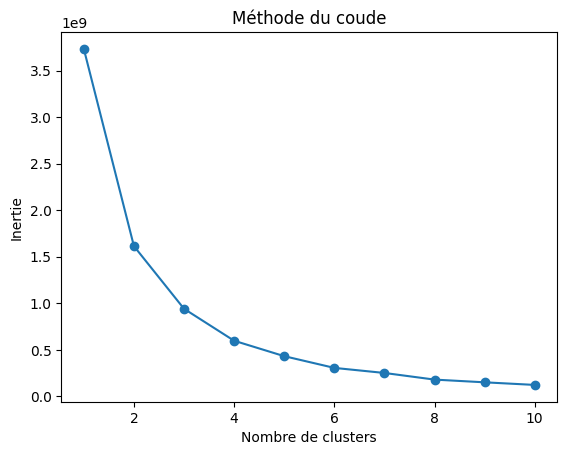

In [136]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Préparation des données

# Sélectionner les colonnes pertinentes
features = ['Nombre achats effectués', 'price']
X = df_final_merged_5[features]

# # Encoder les variables catégorielles
# for col in ['seller_city', 'seller_state', 'Catégorie de produit']:
#     le = LabelEncoder()
#     X[col] = le.fit_transform(X[col])

# # Standardiser les données numériques
# scaler = StandardScaler()
# X[['Nombre achats effectués', 'price']] = scaler.fit_transform(X[['Nombre achats effectués', 'price']])

# 2. Détermination du nombre optimal de clusters

# Utiliser la méthode du coude pour trouver le nombre optimal de clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Tracer le graphique du coude
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

# 3. Application de KMeans avec le nombre optimal de clusters

# Instancier le modèle KMeans avec le nombre optimal de clusters (par exemple, k=3)
kmeans = KMeans(n_clusters=9, random_state=42)

# Entraîner le modèle sur les données
kmeans.fit(X)

# 4. Attribution des groupes de clients

# Ajouter la colonne 'Groupe_KMeans' au DataFrame
df_final_merged_5['Groupe_KMeans'] = kmeans.labels_

In [137]:
df_final_merged_5.loc[:,['Nombre achats effectués', 'price','Groupe_KMeans']]

Nombre achats effectués   price  Groupe_KMeans
0                             1  124.99              7
1                             1  289.00              2
2                             1  139.94              4
3                             1  149.94              4
4                             1  230.00              4
...                         ...     ...            ...
111018                        1   74.90              7
111019                        1  114.90              7
111020                        1   37.00              0
111021                        1  689.00              1
111022                        1   13.99              0

[111023 rows x 3 columns]

<Axes: xlabel='decile_days_diff', ylabel='Fréquence et Montant'>

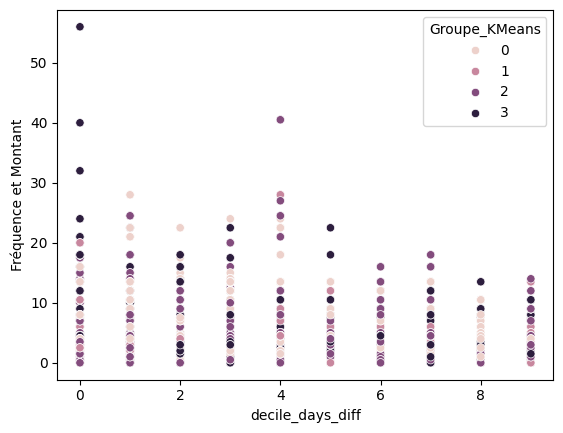

In [138]:
sns.scatterplot(x='decile_days_diff',y='Fréquence et Montant',data=df_final_merged_6,hue='Groupe_KMeans')

In [139]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Supposons que votre DataFrame s'appelle 'data'

# # Boucle pour chaque groupe de valeurs dans la colonne 'KMeans'
# for cluster in df_final_merged_5['Groupe_KMeans'].unique():
#   # Filtrer les données pour le cluster actuel
#   cluster_data = df_final_merged_5[df_final_merged_5['Groupe_KMeans'] == cluster]

#   # Créer une figure avec deux sous-plots
#   fig, axes = plt.subplots(1, 2, figsize=(8, 4))

#   # Boxplot pour 'decile_days_diff'
#   sns.boxplot(x='Groupe_KMeans', y='decile_days_diff', data=cluster_data, ax=axes[0])
#   axes[0].set_title(f'Boxplot de decile_days_diff pour le cluster {cluster}',fontsize=7)

#   # Boxplot pour 'Fréquence et Montant'
#   sns.boxplot(x='Groupe_KMeans', y='Fréquence et Montant', data=cluster_data, ax=axes[1])
#   axes[1].set_title(f'Boxplot de Fréquence et Montant pour le cluster {cluster}',fontsize=7)

#   # Afficher la figure
#   plt.show()

**///////////**

**Nombre de clusters = 3**

**///////////**

**Avec OneHotEncoder**

In [140]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # 1. Préparation des données

# # Sélectionner les colonnes pertinentes
# features = ['seller_city', 'seller_state', 'Catégorie de produit', 'Nombre achats effectués', 'price']
# X = df_final_merged_5[features]

# # Encoder les variables catégorielles avec OneHotEncoder
# categorical_features = ['seller_city', 'seller_state', 'Catégorie de produit']
# numerical_features = ['Nombre achats effectués', 'price']

# # Créer un transformateur pour encoder les variables catégorielles
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),  # Standardiser les numériques
#         ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)  # Encoder les catégorielles
#     ])

# # Appliquer le transformateur aux données
# X = preprocessor.fit_transform(df_final_merged_5[features])

# # 2. Détermination du nombre optimal de clusters

# # Utiliser la méthode du coude pour trouver le nombre optimal de clusters
# inertia = []
# for i in range(1, 11):
#     kmeans = KMeans(n_clusters=i, random_state=42)
#     kmeans.fit(X)
#     inertia.append(kmeans.inertia_)

# # Tracer le graphique du coude
# plt.plot(range(1, 11), inertia, marker='o')
# plt.title('Méthode du coude')
# plt.xlabel('Nombre de clusters')
# plt.ylabel('Inertie')
# plt.show()

# # 3. Application de KMeans avec le nombre optimal de clusters

# # Instancier le modèle KMeans avec le nombre optimal de clusters (par exemple, k=3)
# kmeans = KMeans(n_clusters=3, random_state=42)

# # Entraîner le modèle sur les données
# kmeans.fit(X)

# # 4. Attribution des groupes de clients

# # Ajouter la colonne 'Groupe_KMeans' au DataFrame
# df_final_merged_5['Groupe_KMeans'] = kmeans.labels_

In [141]:
# df_final_merged_5['Groupe_KMeans'].value_counts()

In [142]:
# df_final_merged_5.head()

**///////////**

**Nombre de clusters = 6**

**///////////**

### Deuxième Test

En utilisant la Standardisation et 8 variables

In [143]:
#Ajout du dataframe 'df_order_payment' pour la variable 'Number of installments'
df_final_merged_7=pd.merge(df_final_merged_6,df_order_payment,on='order_id')
df_final_merged_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    115609 non-null  object        
 1   customer_unique_id             115609 non-null  object        
 2   customer_zip_code_prefix       115609 non-null  int64         
 3   customer_city                  115609 non-null  object        
 4   customer_state                 115609 non-null  object        
 5   order_id                       115609 non-null  object        
 6   order_status                   115609 non-null  object        
 7   order_purchase_timestamp       115609 non-null  datetime64[ns]
 8   order_approved_at              115595 non-null  datetime64[ns]
 9   order_delivered_carrier_date   114414 non-null  datetime64[ns]
 10  order_delivered_customer_date  113209 non-null  datetime64[ns]
 11  

**Visualisations des distributions**

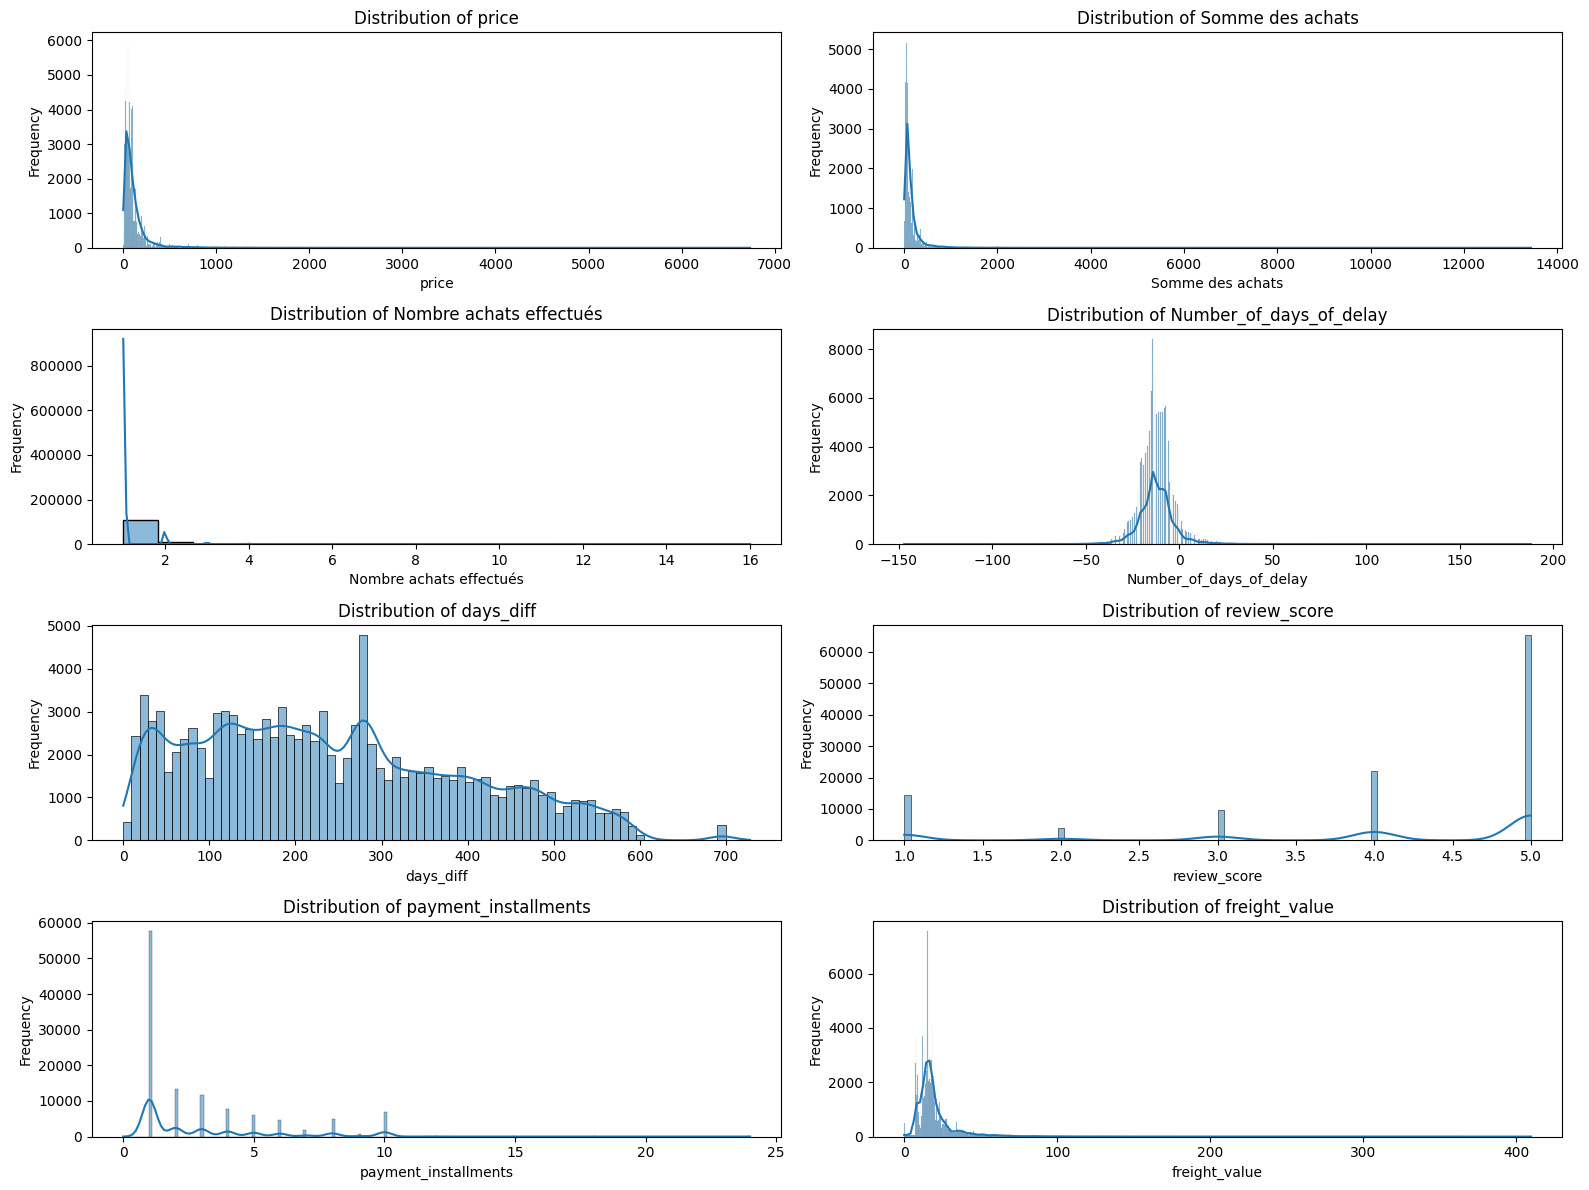

In [144]:
variables = ['price','Somme des achats','Nombre achats effectués', 'Number_of_days_of_delay',
             'days_diff','review_score','payment_installments','freight_value']

plt.figure(figsize=(16, 12))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df_final_merged_7[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [144]:
import numpy as np

df_log = df_final_merged_7.copy()
columns_to_log = ['price', 'Somme des achats', 'Nombre achats effectués']

for column in columns_to_log:
    if column in df_log.columns:
        df_log[column] = np.log10(df_log[column])

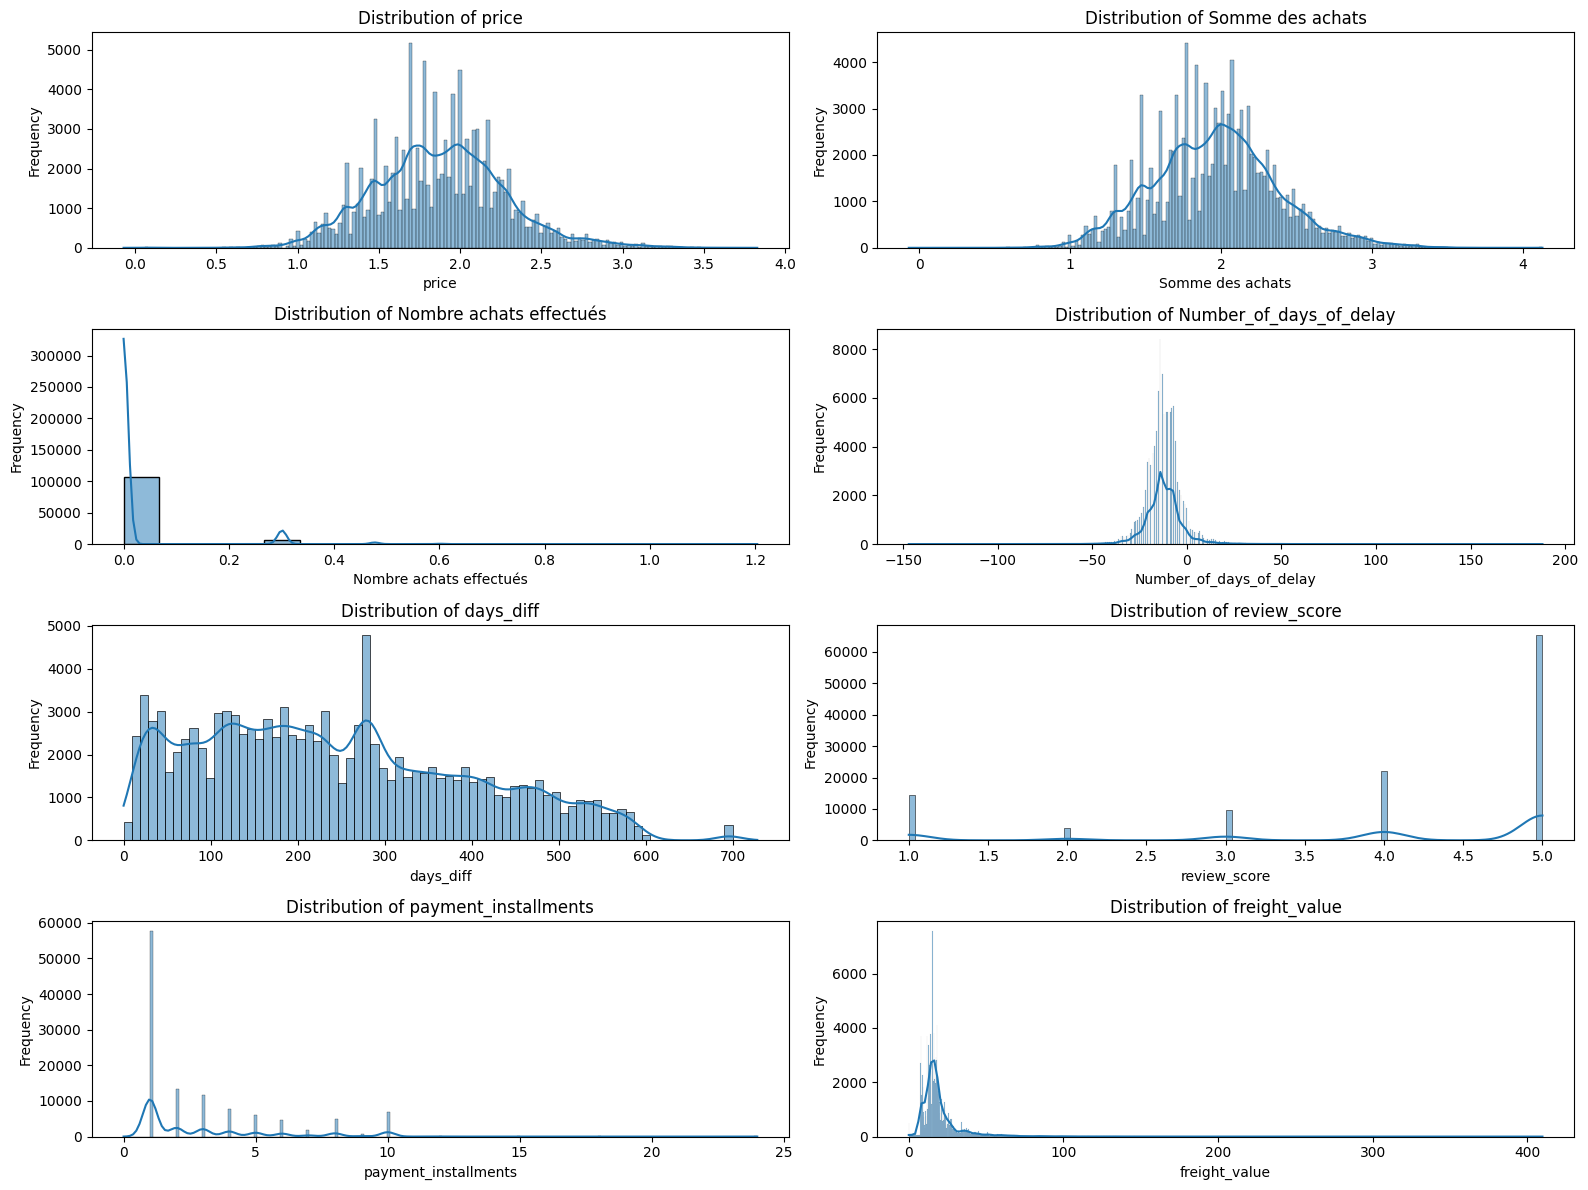

In [146]:
plt.figure(figsize=(16, 12))
for i, var in enumerate(variables, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df_log[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [147]:
df_final_merged_7.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  \
0                     14409                 franca             SP   
1                      9790  sao bernardo do campo             SP   
2                      1151              sao paulo             SP   
3                      8775        mogi das cruzes             SP   
4                     13056               campinas             SP   

                           order_id order_status order_purchase_timestamp  \
0  00e7ee1b050b8499577073aeb2a297a1    delivered      2017-05-16 15:05:35   
1  29150127e6685892b6eab3eec79f59c7    delivered      2018-01-12 20:48:24   
2  b2059ed67ce144a36e2aa97d2c9e9ad2    delivered      2018-05-19 16:07:45   
3  951670f92359f4fe4a63112aa7306eba    delivered      2018-03-13 16:06:38   
4  6b7d50bd145f6fc7f33cebabd7e49d0f    delivered      2018-07-29 09:51:30   

    order_approved_at order_delivered_carrier_date  ... review_score  \
0 2017-05-16 15:22:12          2017-05-23 10:47:57  ...            4   
1 2018-01-12 20:58:32          2018-01-15 17:14:59  ...            5   
2 2018-05-20 16:19:10          2018-06-11 14:31:00  ...            5   
3 2018-03-13 17:29:19          2018-03-27 23:22:42  ...            5   
4 2018-07-29 10:10:09          2018-07-30 15:16:00  ...            5   

  review_comment_title                         review_comment_message  \
0                  NaN                                            NaN   
1                  NaN                                            NaN   
2                  NaN                                            NaN   
3                  NaN                                            NaN   
4        a melhor nota  O baratheon è esxelente Amo adoro o baratheon   

  review_creation_date review_answer_timestamp Groupe_KMeans  \
0  2017-05-26 00:00:00     2017-05-30 22:34:40             1   
1  2018-01-30 00:00:00     2018-02-10 22:43:29             2   
2  2018-06-15 00:00:00     2018-06-15 12:10:59             1   
3  2018-03-29 00:00:00     2018-04-02 18:36:47             1   
4  2018-08-10 00:00:00     2018-08-17 01:59:52             2   

   payment_sequential  payment_type  payment_installments payment_value  
0                   1   credit_card                     2        146.87  
1                   1   credit_card                     8        335.48  
2                   1   credit_card                     7        157.73  
3                   1   credit_card                     1        173.30  
4                   1   credit_card                     8        252.25  

[5 rows x 44 columns]

In [148]:
df_log.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'Somme des achats', 'decile_client', 'Somme des ventes',
       'decile_vendeur', 'date_dernier_achat', 'days_diff', 'decile_days_diff',
       'Nombre achats effectués', 'Number_of_days_of_delay',
       'Fréquence et Montant', 'Category 2', 'Catégorie de produit',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'Groupe_KMeans', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'

In [145]:
df_log_filtered=df_log.loc[:,['customer_unique_id','price', 'freight_value','Somme des achats','Nombre achats effectués','days_diff',
                              'Number_of_days_of_delay','review_score','payment_installments']]
df_log_filtered.head()

customer_unique_id     price  freight_value  \
0  861eff4711a542e4b93843c6dd7febb0  2.096875          21.88   
1  290c77bc529b7ac935b93aa66c333dc3  2.460898          46.48   
2  060e732b5b29e8181a18229c7b0b2b5e  2.145942          17.79   
3  259dac757896d24d7702b9acbbff3f3c  2.175918          23.36   
4  345ecd01c38d18a9036ed96c73b8d066  2.361728          22.25   

   Somme des achats  Nombre achats effectués  days_diff  \
0          2.096875                      0.0        474   
1          2.460898                      0.0        233   
2          2.145942                      0.0        106   
3          2.175918                      0.0        173   
4          2.361728                      0.0         35   

   Number_of_days_of_delay  review_score  payment_installments  
0                    -11.0             4                     2  
1                     -8.0             5                     8  
2                      1.0             5                     7  
3                    -13.0             5                     1  
4                     -6.0             5                     8

In [146]:
from sklearn.preprocessing import StandardScaler

df_log_bis=df_log_filtered.copy()
scaler = StandardScaler()
df_log_bis.set_index("customer_unique_id", inplace=True)

df_log_bis.info()
df_log_bis.head()

<class 'pandas.core.frame.DataFrame'>
Index: 115609 entries, 861eff4711a542e4b93843c6dd7febb0 to 84732c5050c01db9b23e19ba39899398
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    115609 non-null  float64
 1   freight_value            115609 non-null  float64
 2   Somme des achats         115609 non-null  float64
 3   Nombre achats effectués  115609 non-null  float64
 4   days_diff                115609 non-null  int64  
 5   Number_of_days_of_delay  113209 non-null  float64
 6   review_score             115609 non-null  int64  
 7   payment_installments     115609 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 7.9+ MB


price  freight_value  Somme des achats  \
customer_unique_id                                                            
861eff4711a542e4b93843c6dd7febb0  2.096875          21.88          2.096875   
290c77bc529b7ac935b93aa66c333dc3  2.460898          46.48          2.460898   
060e732b5b29e8181a18229c7b0b2b5e  2.145942          17.79          2.145942   
259dac757896d24d7702b9acbbff3f3c  2.175918          23.36          2.175918   
345ecd01c38d18a9036ed96c73b8d066  2.361728          22.25          2.361728   

                                  Nombre achats effectués  days_diff  \
customer_unique_id                                                     
861eff4711a542e4b93843c6dd7febb0                      0.0        474   
290c77bc529b7ac935b93aa66c333dc3                      0.0        233   
060e732b5b29e8181a18229c7b0b2b5e                      0.0        106   
259dac757896d24d7702b9acbbff3f3c                      0.0        173   
345ecd01c38d18a9036ed96c73b8d066                      0.0         35   

                                  Number_of_days_of_delay  review_score  \
customer_unique_id                                                        
861eff4711a542e4b93843c6dd7febb0                    -11.0             4   
290c77bc529b7ac935b93aa66c333dc3                     -8.0             5   
060e732b5b29e8181a18229c7b0b2b5e                      1.0             5   
259dac757896d24d7702b9acbbff3f3c                    -13.0             5   
345ecd01c38d18a9036ed96c73b8d066                     -6.0             5   

                                  payment_installments  
customer_unique_id                                      
861eff4711a542e4b93843c6dd7febb0                     2  
290c77bc529b7ac935b93aa66c333dc3                     8  
060e732b5b29e8181a18229c7b0b2b5e                     7  
259dac757896d24d7702b9acbbff3f3c                     1  
345ecd01c38d18a9036ed96c73b8d066                     8

In [147]:
df_log_scaled = pd.DataFrame(scaler.fit_transform(df_log_bis), columns=df_log_bis.columns)


In [148]:
df_std_final = df_log_scaled.copy()
df_std_final = df_std_final.dropna(subset=['Number_of_days_of_delay'])
df_std_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113209 entries, 0 to 115608
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    113209 non-null  float64
 1   freight_value            113209 non-null  float64
 2   Somme des achats         113209 non-null  float64
 3   Nombre achats effectués  113209 non-null  float64
 4   days_diff                113209 non-null  float64
 5   Number_of_days_of_delay  113209 non-null  float64
 6   review_score             113209 non-null  float64
 7   payment_installments     113209 non-null  float64
dtypes: float64(8)
memory usage: 7.8 MB


In [136]:
from IPython.display import display

# Afficher toutes les colonnes
pd.set_option('display.max_columns', None)

display(df_final_merged_6.loc[df_final_merged_6['order_id']=='5a3b1c29a49756e75f1ef513383c0c12'])

customer_id                customer_unique_id  \
20263  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20264  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20265  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20266  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20267  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20268  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20269  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20270  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20271  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20272  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20273  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20274  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20275  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20276  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20277  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20278  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20279  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20280  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20281  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20282  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20283  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   
20284  be1c4e52bb71e0c54b11a26b8e8d59f2  d97b3cfb22b0d6b25ac9ed4e9c2d481b   

       customer_zip_code_prefix customer_city customer_state  \
20263                      8072     sao paulo             SP   
20264                      8072     sao paulo             SP   
20265                      8072     sao paulo             SP   
20266                      8072     sao paulo             SP   
20267                      8072     sao paulo             SP   
20268                      8072     sao paulo             SP   
20269                      8072     sao paulo             SP   
20270                      8072     sao paulo             SP   
20271                      8072     sao paulo             SP   
20272                      8072     sao paulo             SP   
20273                      8072     sao paulo             SP   
20274                      8072     sao paulo             SP   
20275                      8072     sao paulo             SP   
20276                      8072     sao paulo             SP   
20277                      8072     sao paulo             SP   
20278                      8072     sao paulo             SP   
20279                      8072     sao paulo             SP   
20280                      8072     sao paulo             SP   
20281                      8072     sao paulo             SP   
20282                      8072     sao paulo             SP   
20283                      8072     sao paulo             SP   
20284                      8072     sao paulo             SP   

                               order_id order_status order_purchase_timestamp  \
20263  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20264  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20265  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20266  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20267  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20268  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20269  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20270  5a3b1c29a49756e75f1ef513383c0c12    delivered      2017-10-17 13:06:29   
20271  5a3b1c29a49756e75f1ef513383c0c12    delivered  

In [154]:
# df_final_merged_7['customer_unique_id'].value_counts()

variables = ['price','Somme des achats','Nombre achats effectués', 'Number_of_days_of_delay',
             'days_diff','review_score','payment_installments','freight_value']

**>>>>>**






**Détermination du nombre de clusters**







**<<<<<<<**


In [155]:
df_std_final.describe()

price  freight_value  Somme des achats  \
count  113209.000000  113209.000000     113209.000000   
mean       -0.003533      -0.003433         -0.002728   
std         0.996866       0.992090          0.997436   
min        -4.843242      -1.266528         -4.904073   
25%        -0.681692      -0.440568         -0.658303   
50%        -0.000756      -0.235972         -0.021606   
75%         0.620083       0.071553          0.602945   
max         4.863622      24.603452          5.220949   

       Nombre achats effectués      days_diff  Number_of_days_of_delay  \
count            113209.000000  113209.000000             1.132090e+05   
mean                  0.000657      -0.007109            -2.887135e-17   
std                   1.001243       0.996240             1.000004e+00   
min                  -0.266884      -1.557140            -1.336941e+01   
25%                  -0.266884      -0.812711            -4.863502e-01   
50%                  -0.266884      -0.133582            -8.994840e-02   
75%                  -0.266884       0.695739             5.046544e-01   
max                  13.076566       2.981270             1.982924e+01   

        review_score  payment_installments  
count  113209.000000         113209.000000  
mean        0.034742             -0.000988  
std         0.971343              0.999309  
min        -2.189996             -1.059386  
25%        -0.024834             -0.699813  
50%         0.696887             -0.340240  
75%         0.696887              0.378907  
max         0.696887              7.570370

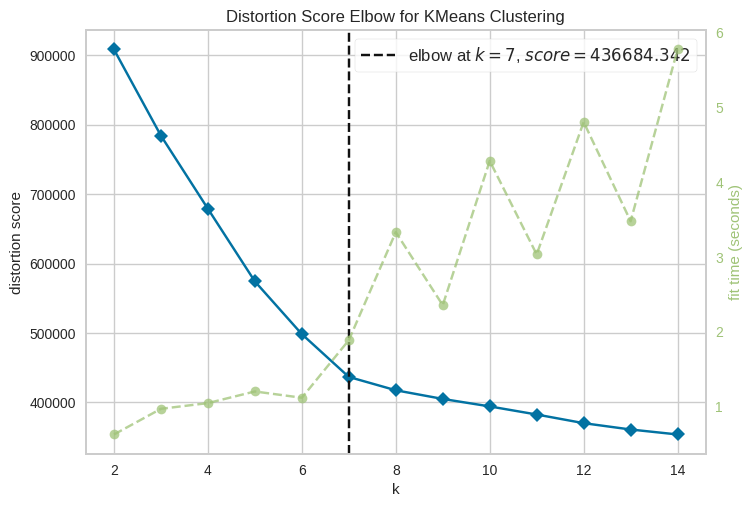

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [153]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


kmeans_model = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans_model, k=(2,15))

elbow.fit(df_std_final)
elbow.poof()

**>>> Nombre de clusters optimal est de 7 >>>**

In [152]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_samples, silhouette_score


In [158]:
df_std_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113209 entries, 0 to 115608
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    113209 non-null  float64
 1   freight_value            113209 non-null  float64
 2   Somme des achats         113209 non-null  float64
 3   Nombre achats effectués  113209 non-null  float64
 4   days_diff                113209 non-null  float64
 5   Number_of_days_of_delay  113209 non-null  float64
 6   review_score             113209 non-null  float64
 7   payment_installments     113209 non-null  float64
dtypes: float64(8)
memory usage: 7.8 MB


In [149]:
kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_7.fit(df_std_final)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [150]:
df_std_final['cluster_7']= kmeans_7.labels_
df_std_final.head()

price  freight_value  Somme des achats  Nombre achats effectués  \
0  0.552922       0.115124          0.322325                -0.266884   
1  1.459203       1.668535          1.200094                -0.266884   
2  0.675079      -0.143146          0.440639                -0.266884   
3  0.749707       0.208581          0.512920                -0.266884   
4  1.212306       0.138489          0.960965                -0.266884   

   days_diff  Number_of_days_of_delay  review_score  payment_installments  \
0   1.512000                 0.108253     -0.024834             -0.340240   
1  -0.061751                 0.405554      0.696887              1.817199   
2  -0.891072                 1.297458      0.696887              1.457626   
3  -0.453556                -0.089948      0.696887             -0.699813   
4  -1.354708                 0.603755      0.696887              1.817199   

   cluster_7  
0          2  
1          0  
2          0  
3          5  
4          0

- Test 0 avec toutes les variables présentes au sein du dataframe df_std_final

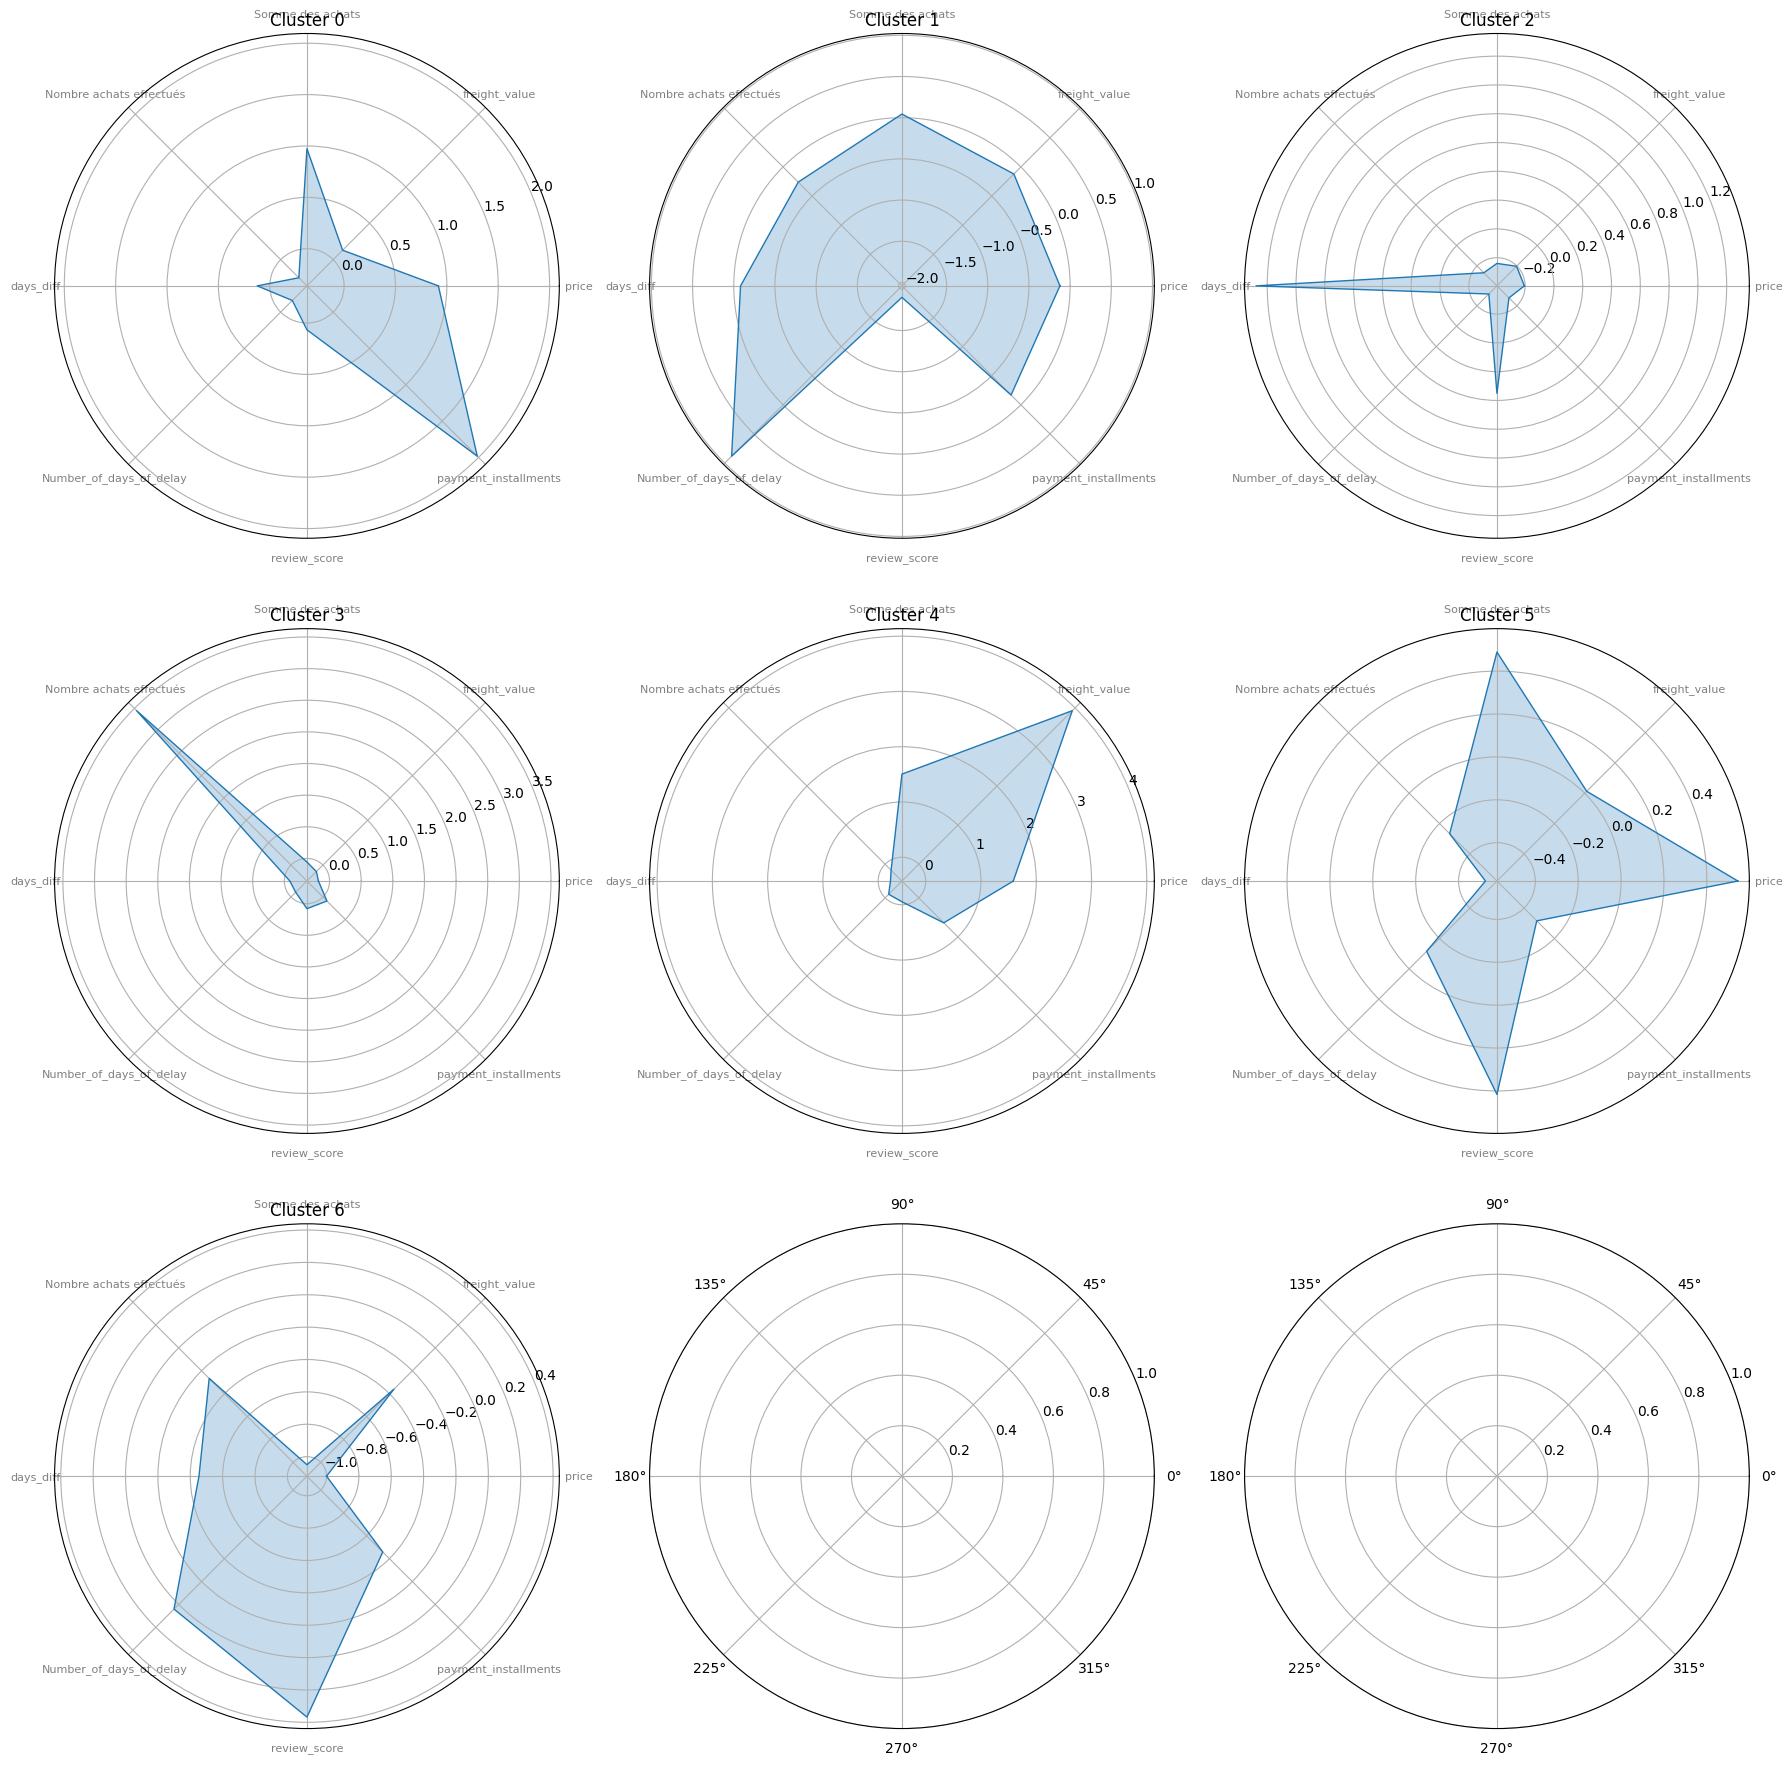

In [151]:
from math import pi

variables = ['price', 'freight_value','Somme des achats',
             'Nombre achats effectués','days_diff',
            'Number_of_days_of_delay','review_score','payment_installments']

cluster_means = df_std_final.groupby('cluster_7')[variables].mean().reset_index()

num_clusters = len(cluster_means)

def create_radar_charts(cluster_means, variables):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, axs = plt.subplots(3, 3, figsize=(18, 18), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster_7').values.flatten().tolist()
        values += values[:1]

        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)
        axs[i].set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

create_radar_charts(cluster_means, variables)

**>>>>>>>>>>>>>>>**

- Test 1 : Colonnes Récence/Fréquence/Montant ('Somme des achats','Nombre achats effectués','days_diff' )

**>>>>>>>>>>>>>>>**

In [154]:
df_test_1 = df_std_final.loc[:,['Somme des achats','Nombre achats effectués','days_diff']]
display(df_test_1.head())

elbow.fit(df_test_1)
elbow.poof()

Somme des achats  Nombre achats effectués  days_diff
0          0.322325                -0.266884   1.512000
1          1.200094                -0.266884  -0.061751
2          0.440639                -0.266884  -0.891072
3          0.512920                -0.266884  -0.453556
4          0.960965                -0.266884  -1.354708

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

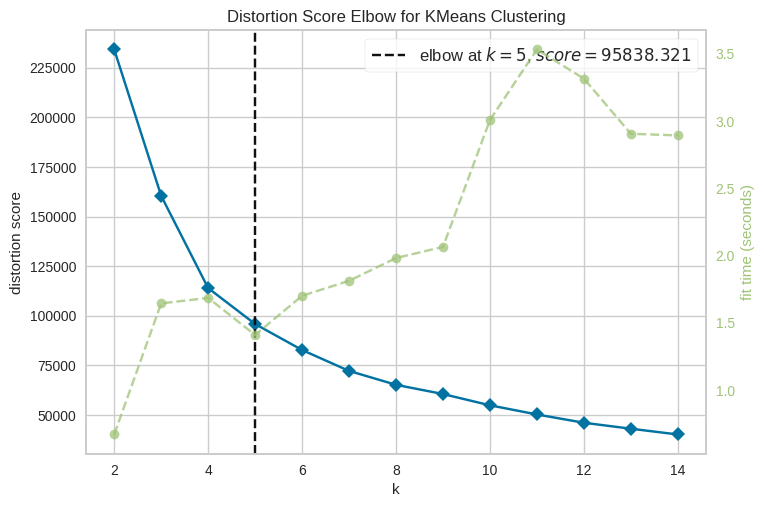

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [155]:
kmeans_model = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans_model, k=(2,15))

elbow.fit(df_test_1)
elbow.poof()

In [156]:
kmeans_test_1 = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_test_1.fit(df_test_1)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [157]:
df_test_1['cluster_5']= kmeans_test_1.labels_
df_test_1.head()

Somme des achats  Nombre achats effectués  days_diff  cluster_5
0          0.322325                -0.266884   1.512000          0
1          1.200094                -0.266884  -0.061751          3
2          0.440639                -0.266884  -0.891072          3
3          0.512920                -0.266884  -0.453556          3
4          0.960965                -0.266884  -1.354708          3

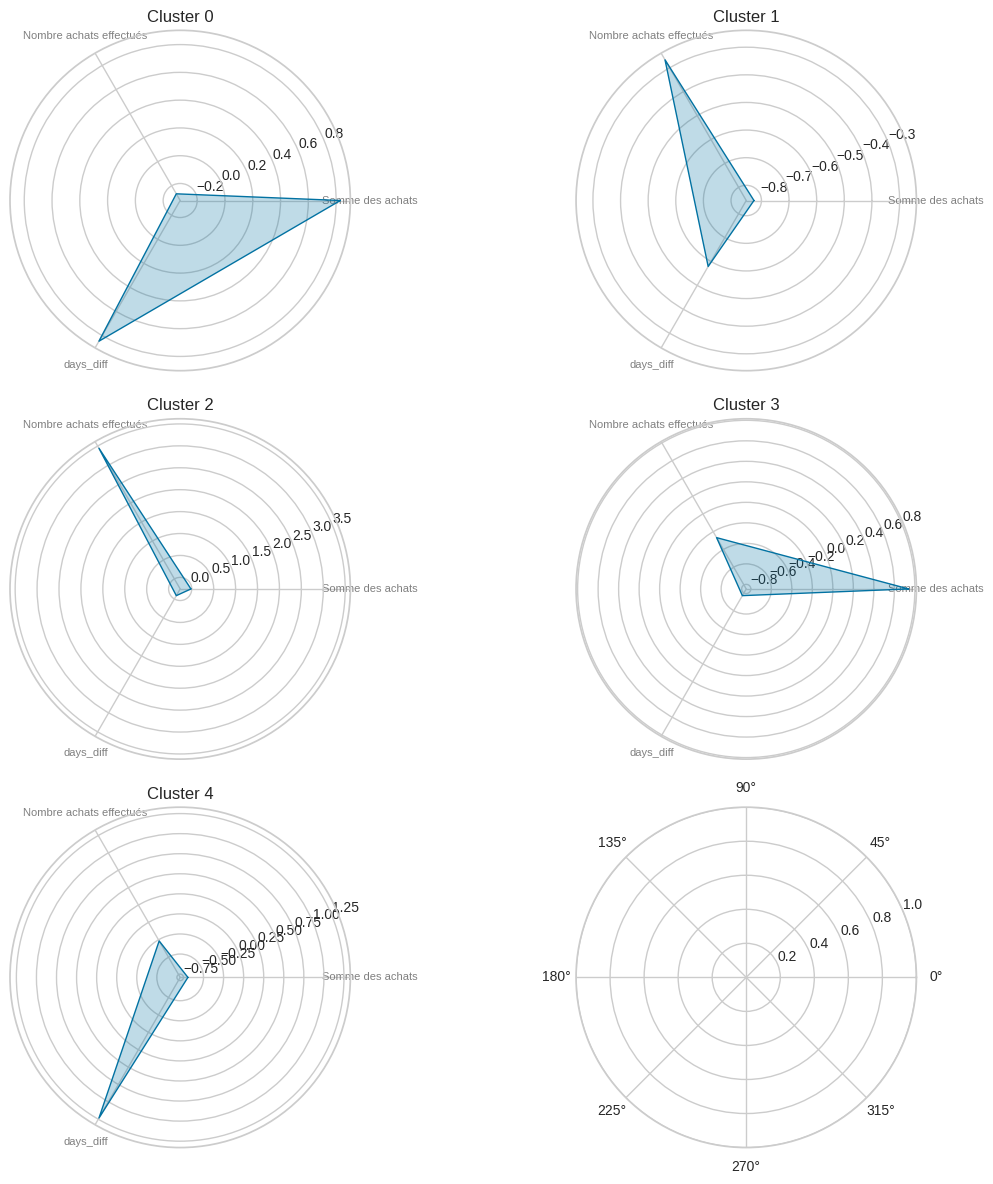

In [158]:
from math import pi

variables_test_1 = ['Somme des achats','Nombre achats effectués','days_diff']

cluster_means_test_1 = df_test_1.groupby('cluster_5')[variables_test_1].mean().reset_index()

num_clusters = len(cluster_means_test_1)

def create_radar_charts(cluster_means, variables):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, axs = plt.subplots(3, 2, figsize=(12, 12), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster_5').values.flatten().tolist()
        values += values[:1]

        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)
        axs[i].set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

create_radar_charts(cluster_means_test_1, variables_test_1)

**>>>>>>>>>>>>>>>>>><**

- Test 2 : Ajout de la colonne 'review_score'




**>>>>>>>>>>>>>>>>>**

In [159]:
df_test_2 = df_std_final.loc[:,['Somme des achats','Nombre achats effectués','days_diff','review_score']]
display(df_test_2.head())

elbow.fit(df_test_2)
elbow.poof()

Somme des achats  Nombre achats effectués  days_diff  review_score
0          0.322325                -0.266884   1.512000     -0.024834
1          1.200094                -0.266884  -0.061751      0.696887
2          0.440639                -0.266884  -0.891072      0.696887
3          0.512920                -0.266884  -0.453556      0.696887
4          0.960965                -0.266884  -1.354708      0.696887

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [160]:
df_test_2['review_score'].isnull().sum()


0

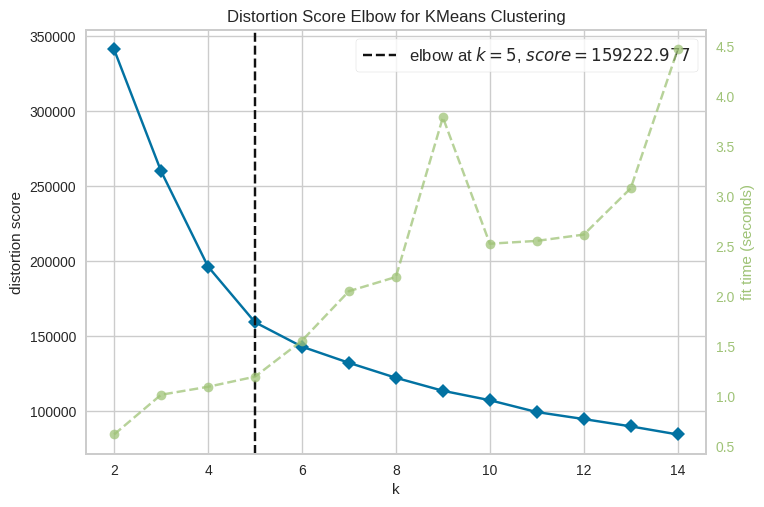

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [161]:
kmeans_test_2 = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans_test_2, k=(2,15))

elbow.fit(df_test_2)
elbow.poof()

In [162]:
kmeans_test_2 = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_test_2.fit(df_test_2)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [163]:
df_test_2['cluster_5']= kmeans_test_2.labels_
df_test_2.head()

Somme des achats  Nombre achats effectués  days_diff  review_score  \
0          0.322325                -0.266884   1.512000     -0.024834   
1          1.200094                -0.266884  -0.061751      0.696887   
2          0.440639                -0.266884  -0.891072      0.696887   
3          0.512920                -0.266884  -0.453556      0.696887   
4          0.960965                -0.266884  -1.354708      0.696887   

   cluster_5  
0          2  
1          1  
2          1  
3          1  
4          1

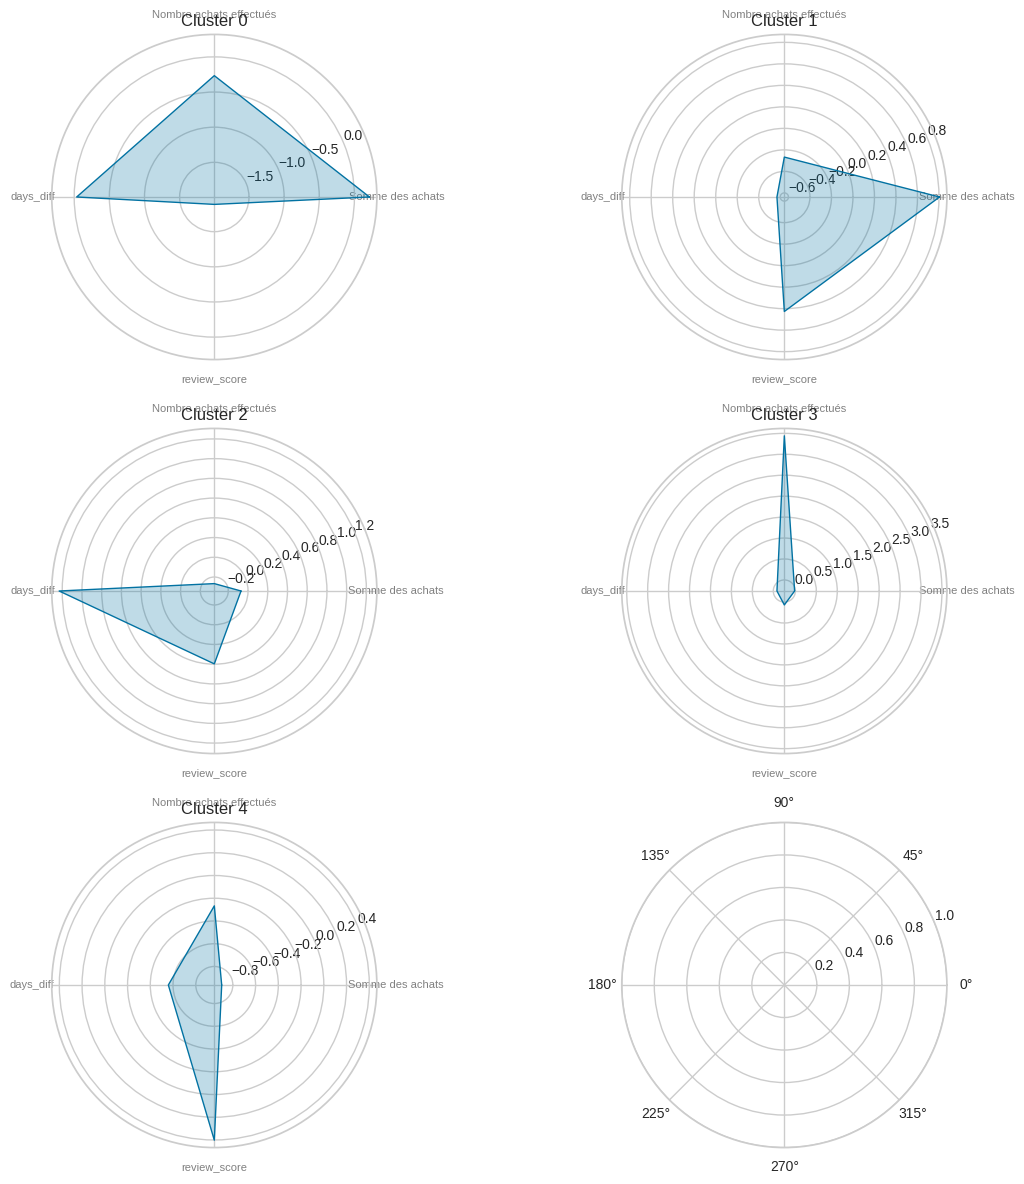

In [164]:
from math import pi

variables_test_2 = ['Somme des achats','Nombre achats effectués','days_diff','review_score']

cluster_means_test_2 = df_test_2.groupby('cluster_5')[variables_test_2].mean().reset_index()

num_clusters = len(cluster_means_test_2)

def create_radar_charts(cluster_means, variables):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, axs = plt.subplots(3, 2, figsize=(12, 12), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster_5').values.flatten().tolist()
        values += values[:1]

        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)
        axs[i].set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

create_radar_charts(cluster_means_test_2, variables_test_2)

**>>>>>>>>>>>>>**

- Test 3 : Ajout de la colonne 'Number_of_days_of_delay'

**>>>>>>>>>>>>**

In [165]:
df_test_3 = df_std_final.loc[:,['Somme des achats','Nombre achats effectués','days_diff','review_score','Number_of_days_of_delay']]
display(df_test_3.head())

elbow.fit(df_test_3)
elbow.poof()

Somme des achats  Nombre achats effectués  days_diff  review_score  \
0          0.322325                -0.266884   1.512000     -0.024834   
1          1.200094                -0.266884  -0.061751      0.696887   
2          0.440639                -0.266884  -0.891072      0.696887   
3          0.512920                -0.266884  -0.453556      0.696887   
4          0.960965                -0.266884  -1.354708      0.696887   

   Number_of_days_of_delay  
0                 0.108253  
1                 0.405554  
2                 1.297458  
3                -0.089948  
4                 0.603755

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

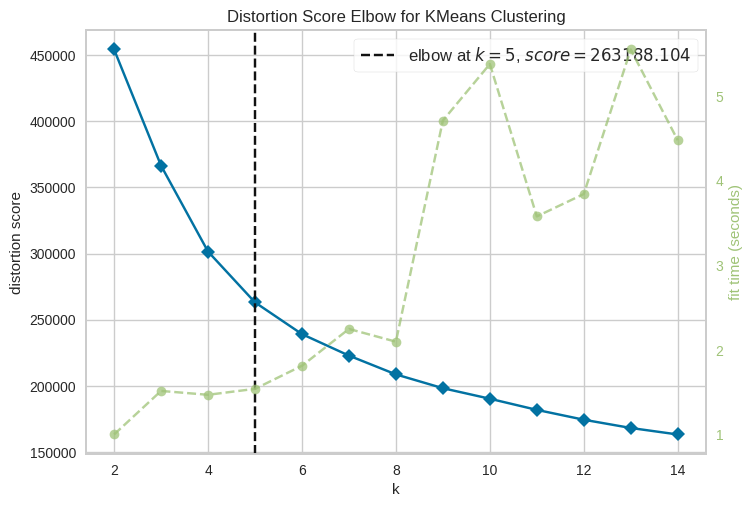

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [166]:
kmeans_test_3 = KMeans(random_state=42, n_init=10)
elbow = KElbowVisualizer(kmeans_test_3, k=(2,15))

elbow.fit(df_test_3)
elbow.poof()

In [167]:
kmeans_test_3 = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_test_3.fit(df_test_3)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [168]:
df_test_3['cluster_5']= kmeans_test_3.labels_
df_test_3.head()

Somme des achats  Nombre achats effectués  days_diff  review_score  \
0          0.322325                -0.266884   1.512000     -0.024834   
1          1.200094                -0.266884  -0.061751      0.696887   
2          0.440639                -0.266884  -0.891072      0.696887   
3          0.512920                -0.266884  -0.453556      0.696887   
4          0.960965                -0.266884  -1.354708      0.696887   

   Number_of_days_of_delay  cluster_5  
0                 0.108253          2  
1                 0.405554          1  
2                 1.297458          1  
3                -0.089948          1  
4                 0.603755          1

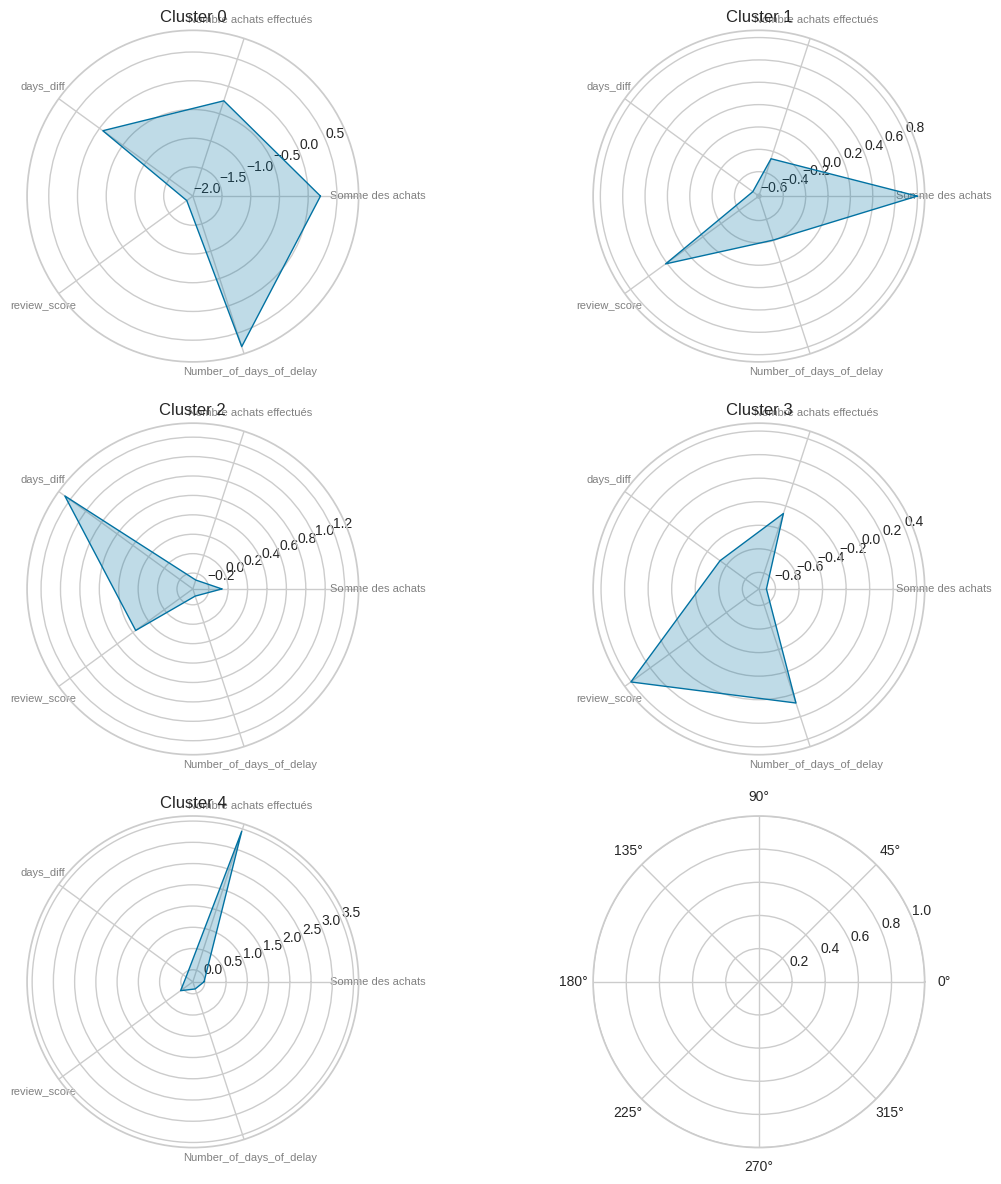

In [169]:
from math import pi

variables_test_3 = ['Somme des achats','Nombre achats effectués','days_diff','review_score','Number_of_days_of_delay']

cluster_means_test_3 = df_test_3.groupby('cluster_5')[variables_test_3].mean().reset_index()

num_clusters = len(cluster_means_test_3)

def create_radar_charts(cluster_means, variables):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, axs = plt.subplots(3, 2, figsize=(12, 12), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster_5').values.flatten().tolist()
        values += values[:1]

        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)
        axs[i].set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

create_radar_charts(cluster_means_test_3, variables_test_3)

**Compte par cluster **

In [171]:
df_test_3['cluster_5'].value_counts()

cluster_5
1    30849
3    30356
2    27055
0    16799
4     8150
Name: count, dtype: int64

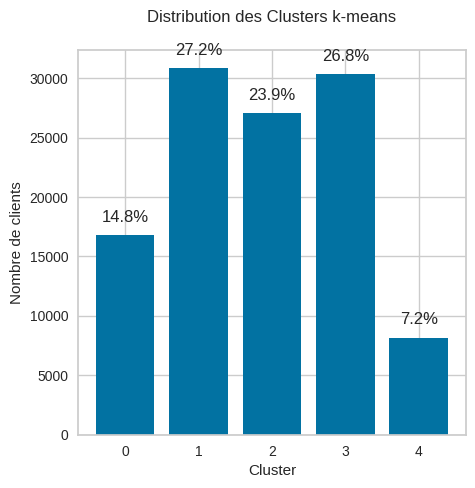

In [170]:
segment_counts = df_test_3['cluster_5'].value_counts()

# Sort segment_counts in descending order
segment_counts = segment_counts.sort_values(ascending=False)


plt.figure(figsize=(5,5))
plt.bar(segment_counts.index, segment_counts.values)

# Add percentages on top of the bars
total = segment_counts.sum()
for cluster, count in segment_counts.items():  # Iterate using items()
    percentage = '{:.1f}%'.format(100 * count / total)
    plt.text(cluster, count + 0.01 * total, percentage, ha='center')

plt.title('Distribution des Clusters k-means', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.show()

**CA par cluster**

In [171]:
clusters = df_test_3.copy()
clusters = clusters[['cluster_5']]

clusters = clusters.reset_index()
df_ca = df_final_merged_7.copy()
df_ca = df_ca.reset_index()

df_with_clusters = pd.merge(df_ca, clusters, left_index=True, right_index=True, how='inner')
# df_with_clusters = df_with_clusters.drop(columns=['index'])

df_with_clusters_ca = df_with_clusters.loc[:,['Somme des achats','cluster_5']]
df_with_clusters_ca

Somme des achats  cluster_5
0                 124.99          2
1                 289.00          1
2                 139.94          1
3                 149.94          1
4                 230.00          1
...                  ...        ...
113204            689.89          3
113205            155.06          1
113206             80.99          0
113207             65.00          1
113208            149.90          3

[113209 rows x 2 columns]

cluster_5
1    4678732.43
3    4612612.36
2    4134376.38
0    2582482.36
4    1215408.79
Name: Somme des achats, dtype: float64

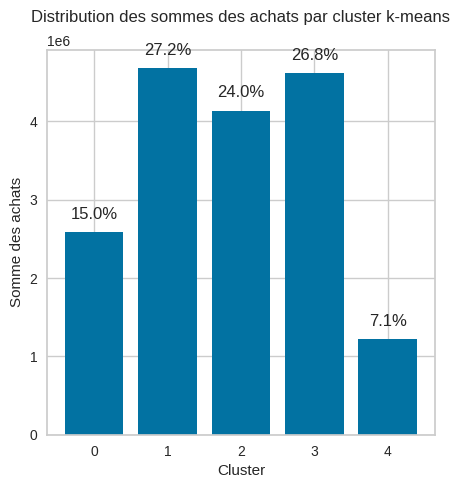

In [172]:
# Calculer la somme des achats pour chaque cluster
cluster_sums = df_with_clusters_ca.groupby('cluster_5')['Somme des achats'].sum()

# Trier cluster_sums par ordre décroissant
cluster_sums = cluster_sums.sort_values(ascending=False)
display(cluster_sums)

# Créer le graphique à barres
plt.figure(figsize=(5, 5))
plt.bar(cluster_sums.index, cluster_sums.values)

# Ajouter des pourcentages au-dessus des barres
total = cluster_sums.sum()
for cluster, total_achat in cluster_sums.items():
    percentage = '{:.1f}%'.format(100 * total_achat / total)
    plt.text(cluster, total_achat + 0.01 * total, percentage, ha='center')

# Ajouter un titre et des étiquettes d'axe
plt.title('Distribution des sommes des achats par cluster k-means', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Somme des achats')

# Afficher le graphique
plt.show()

>>>>>>>> PAS PERTINENT, ESSAI AVEC K = 6

In [173]:
df_test_3_bis=df_test_3.copy()
kmeans_test_3_bis = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans_test_3_bis.fit(df_test_3)

KMeans(n_clusters=6, n_init=10, random_state=42)

In [174]:
df_test_3_bis['cluster_6']= kmeans_test_3_bis.labels_
df_test_3_bis.head()

Somme des achats  Nombre achats effectués  days_diff  review_score  \
0          0.322325                -0.266884   1.512000     -0.024834   
1          1.200094                -0.266884  -0.061751      0.696887   
2          0.440639                -0.266884  -0.891072      0.696887   
3          0.512920                -0.266884  -0.453556      0.696887   
4          0.960965                -0.266884  -1.354708      0.696887   

   Number_of_days_of_delay  cluster_5  cluster_6  
0                 0.108253          2          3  
1                 0.405554          1          4  
2                 1.297458          1          4  
3                -0.089948          1          4  
4                 0.603755          1          4

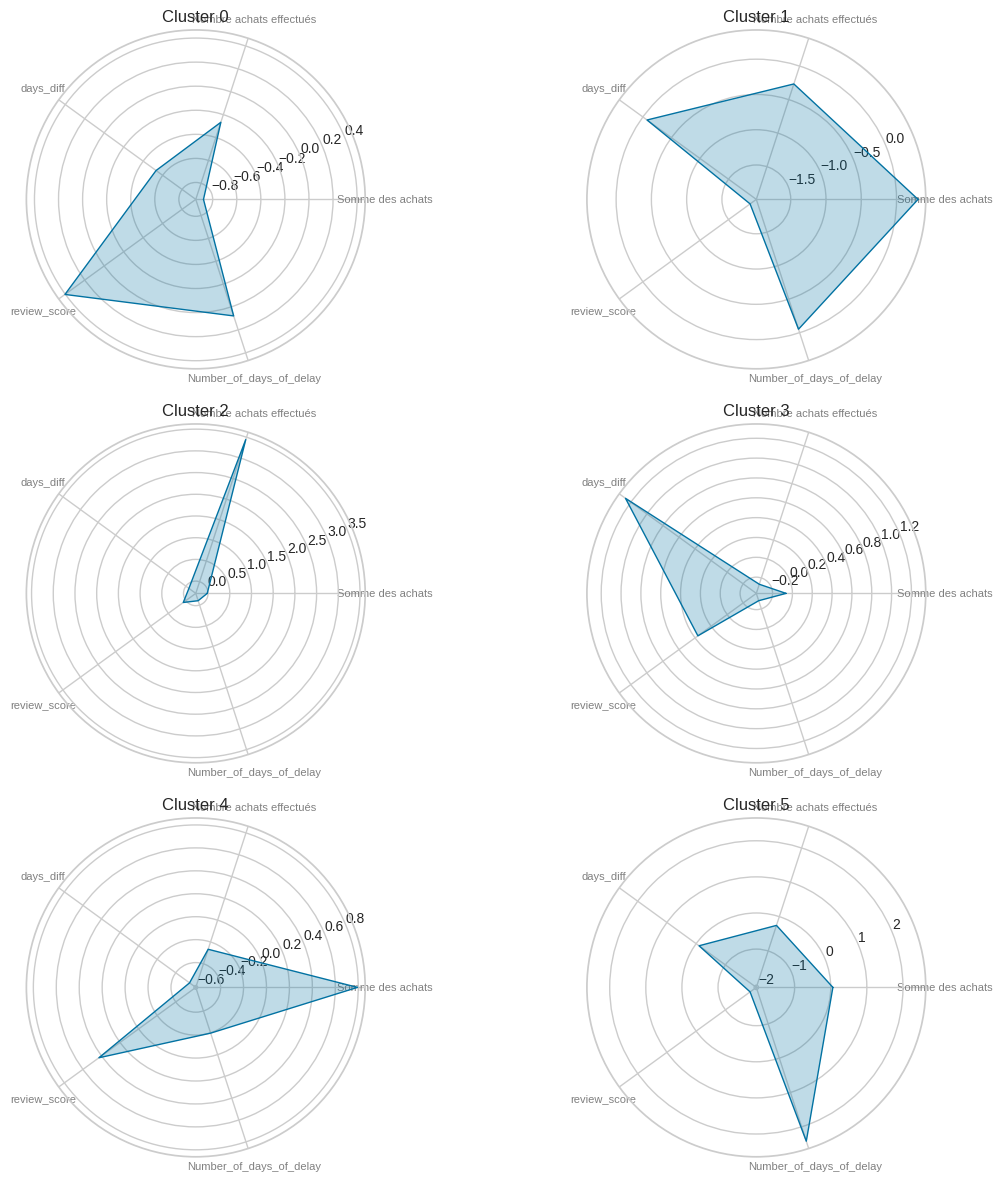

In [175]:
from math import pi

variables_test_3 = ['Somme des achats','Nombre achats effectués','days_diff','review_score','Number_of_days_of_delay']

cluster_means_test_3 = df_test_3_bis.groupby('cluster_6')[variables_test_3].mean().reset_index()

num_clusters = len(cluster_means_test_3)

def create_radar_charts(cluster_means, variables):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, axs = plt.subplots(3, 2, figsize=(12, 12), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster_6').values.flatten().tolist()
        values += values[:1]

        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)
        axs[i].set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

create_radar_charts(cluster_means_test_3, variables_test_3)

**Nombre de clients par cluster**

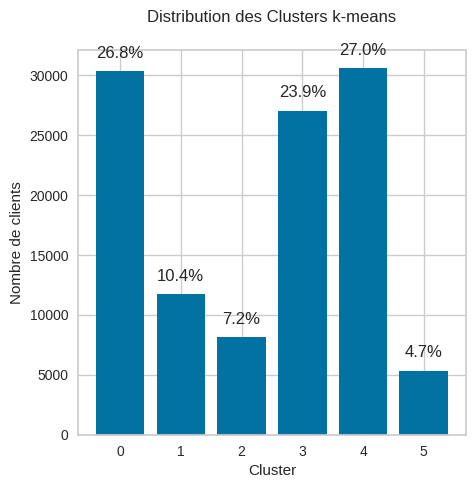

In [176]:
segment_counts_bis = df_test_3_bis['cluster_6'].value_counts()

# Sort segment_counts_bis in descending order
segment_counts_bis = segment_counts_bis.sort_values(ascending=False)


plt.figure(figsize=(5,5))
plt.bar(segment_counts_bis.index, segment_counts_bis.values)

# Add percentages on top of the bars
total = segment_counts_bis.sum()
for cluster, count in segment_counts_bis.items():  # Iterate using items()
    percentage = '{:.1f}%'.format(100 * count / total)
    plt.text(cluster, count + 0.01 * total, percentage, ha='center')

plt.title('Distribution des Clusters k-means', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.show()

**CA par cluster**

In [177]:
clusters_bis = df_test_3_bis.copy()
clusters_bis = clusters_bis[['cluster_6']]

clusters_bis = clusters_bis.reset_index()
df_ca_bis = df_final_merged_7.copy()
df_ca_bis = df_ca_bis.reset_index()

df_with_clusters_bis = pd.merge(df_ca_bis, clusters_bis, left_index=True, right_index=True, how='inner')
# df_with_clusters = df_with_clusters.drop(columns=['index'])

df_with_clusters_ca_bis = df_with_clusters_bis.loc[:,['Somme des achats','cluster_6']]
df_with_clusters_ca_bis

Somme des achats  cluster_6
0                 124.99          3
1                 289.00          4
2                 139.94          4
3                 149.94          4
4                 230.00          4
...                  ...        ...
113204            689.89          0
113205            155.06          4
113206             80.99          5
113207             65.00          4
113208            149.90          0

[113209 rows x 2 columns]

cluster_6
4    4644818.63
0    4612463.37
3    4133819.38
1    1820314.48
2    1215408.79
5     796787.67
Name: Somme des achats, dtype: float64

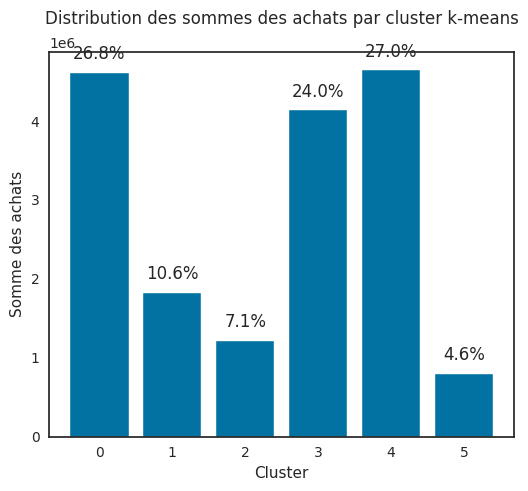

In [215]:
# Calculer la somme des achats pour chaque cluster
cluster_sums_bis = df_with_clusters_ca_bis.groupby('cluster_6')['Somme des achats'].sum()

# Trier cluster_sums par ordre décroissant
cluster_sums_bis = cluster_sums_bis.sort_values(ascending=False)
display(cluster_sums_bis)

# Créer le graphique à barres
plt.figure(figsize=(6, 5))
plt.bar(cluster_sums_bis.index, cluster_sums_bis.values)

# Ajouter des pourcentages au-dessus des barres
total = cluster_sums_bis.sum()
for cluster, total_achat in cluster_sums_bis.items():
    percentage = '{:.1f}%'.format(100 * total_achat / total)
    plt.text(cluster, total_achat + 0.01 * total, percentage, ha='center')

# Ajouter un titre et des étiquettes d'axe
plt.title('Distribution des sommes des achats par cluster k-means', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Somme des achats')

# Afficher le graphique
plt.show()

**>>>>>**

**Coefficients de silhouettes**

**<<<<<<**

**Dataframe de base**

In [182]:
# Calcul du coefficient de silhouette pour 7 clusters
kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_7 = kmeans_7.fit_predict(df_std_final)
silhouette_avg_7 = silhouette_score(df_std_final, clusters_7)
print(f"Coefficient de silhouette pour 7 clusters: {silhouette_avg_7}")

# # Calcul de l'indice de Davies-Bouldin pour 7 clusters
# kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
# clusters_7 = kmeans_7.fit_predict(df_std_final)
# davies_bouldin_7 = davies_bouldin_score(df_std_final, clusters_7)
# print(f"Indice de Davies-Bouldin pour 7 clusters: {davies_bouldin_7}")

# # Calcul de l'indice de Calinski-Harabasz pour 7 clusters
# kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
# clusters_7 = kmeans_7.fit_predict(df_std_final)
# calinski_harabasz_7 = calinski_harabasz_score(df_std_final, clusters_7)
# print(f"Indice de Calinski-Harabasz pour 7 clusters: {calinski_harabasz_7}")

Coefficient de silhouette pour 7 clusters: 0.3263834754033042


In [183]:
kmeans_7 = KMeans(n_clusters=7, random_state=42, n_init=10)
kmeans_7.fit(df_std_final)

KMeans(n_clusters=7, n_init=10, random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


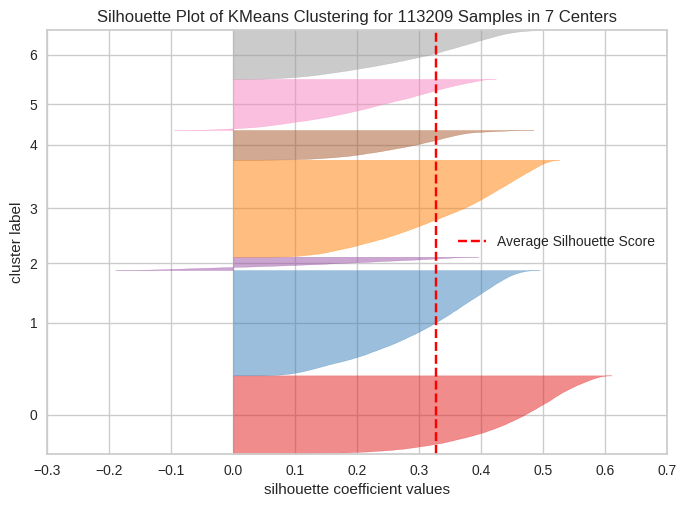

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 113209 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [184]:
visualizer = SilhouetteVisualizer(kmeans_7)

visualizer.fit(df_std_final)
visualizer.poof()

In [185]:
df_std_final['cluster_7']= kmeans_7.labels_
df_std_final.head()

price  freight_value  Somme des achats  Nombre achats effectués  \
0  0.552922       0.115124          0.322325                -0.266884   
1  1.459203       1.668535          1.200094                -0.266884   
2  0.675079      -0.143146          0.440639                -0.266884   
3  0.749707       0.208581          0.512920                -0.266884   
4  1.212306       0.138489          0.960965                -0.266884   

   days_diff  Number_of_days_of_delay  review_score  payment_installments  \
0   1.512000                 0.108253     -0.024834             -0.340240   
1  -0.061751                 0.405554      0.696887              1.817199   
2  -0.891072                 1.297458      0.696887              1.457626   
3  -0.453556                -0.089948      0.696887             -0.699813   
4  -1.354708                 0.603755      0.696887              1.817199   

   cluster_7  
0          0  
1          6  
2          6  
3          1  
4          6

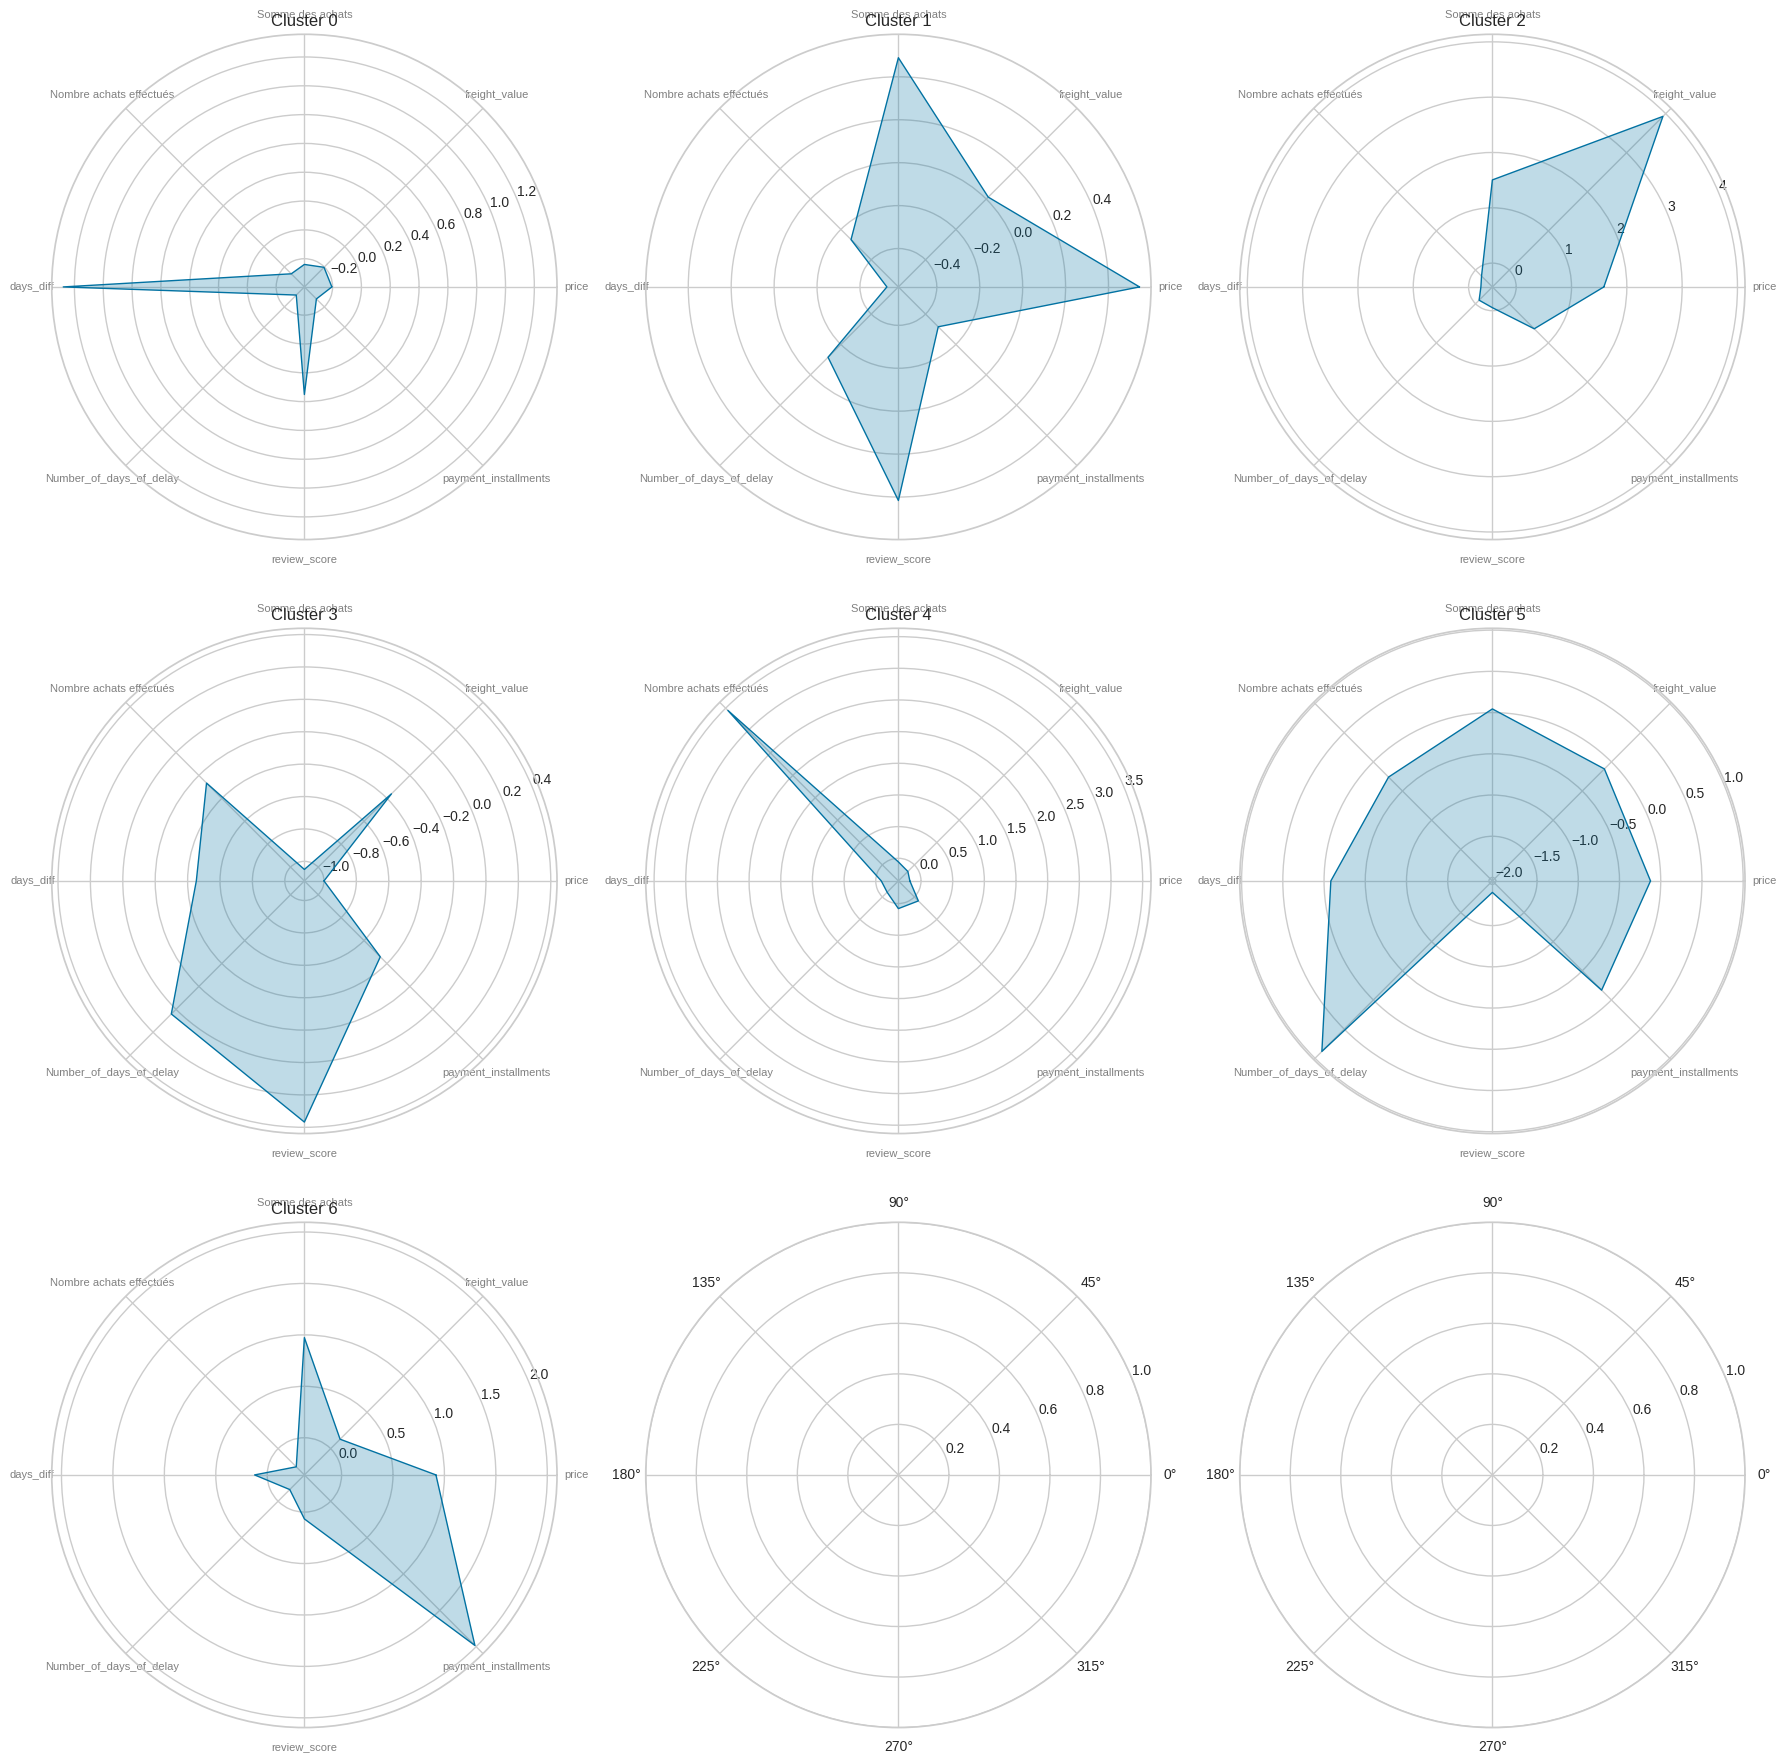

In [186]:
from math import pi

variables = ['price', 'freight_value','Somme des achats',
             'Nombre achats effectués','days_diff',
            'Number_of_days_of_delay','review_score','payment_installments']

cluster_means = df_std_final.groupby('cluster_7')[variables].mean().reset_index()

num_clusters = len(cluster_means)

def create_radar_charts(cluster_means, variables):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    fig, axs = plt.subplots(3, 3, figsize=(18, 18), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_clusters):
        values = cluster_means.loc[i].drop('cluster_7').values.flatten().tolist()
        values += values[:1]

        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i}')
        axs[i].fill(angles, values, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)
        axs[i].set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

create_radar_charts(cluster_means, variables)

**df_test_1**

In [187]:
kmeans_test_1=KMeans(n_clusters=5, random_state=42,n_init=10)
kmeans_test_1.fit(df_test_1)

KMeans(n_clusters=5, n_init=10, random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


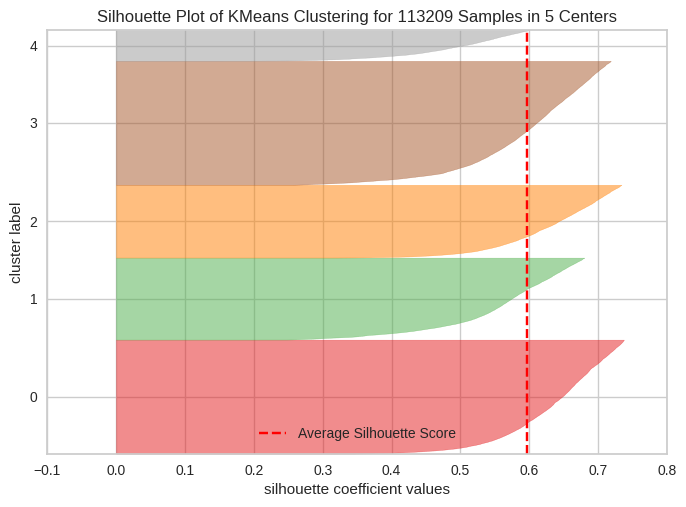

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 113209 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [188]:
visualizer = SilhouetteVisualizer(kmeans_test_1)

visualizer.fit(df_test_1)
visualizer.poof()

**df_test_2**

In [189]:
# kmeans_test_2=KMeans(n_clusters=5, random_state=42,n_init=10)
# kmeans_test_2.fit(df_test_2)

In [190]:
# visualizer = SilhouetteVisualizer(kmeans_test_2)

# visualizer.fit(df_test_2)
# visualizer.poof()

**df_test_3 : 5 clusters**

In [191]:
kmeans_test_3 =KMeans(n_clusters=5, random_state=42,n_init=10)
kmeans_test_3.fit(df_test_3)

KMeans(n_clusters=5, n_init=10, random_state=42)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


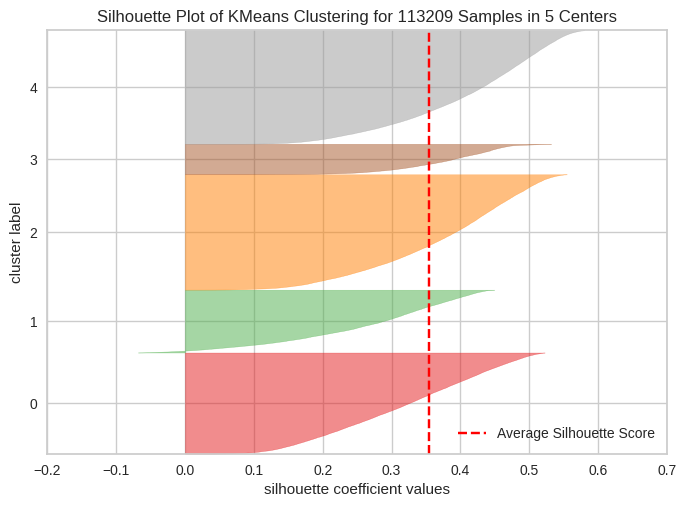

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 113209 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [192]:
visualizer = SilhouetteVisualizer(kmeans_test_3)

visualizer.fit(df_test_3)
visualizer.poof()

**Boxplots des distributions par clusters pour df_test_3 : 5 clusters **

In [179]:
df_test_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113209 entries, 0 to 115608
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Somme des achats         113209 non-null  float64
 1   Nombre achats effectués  113209 non-null  float64
 2   days_diff                113209 non-null  float64
 3   review_score             113209 non-null  float64
 4   Number_of_days_of_delay  113209 non-null  float64
 5   cluster_5                113209 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 5.6 MB


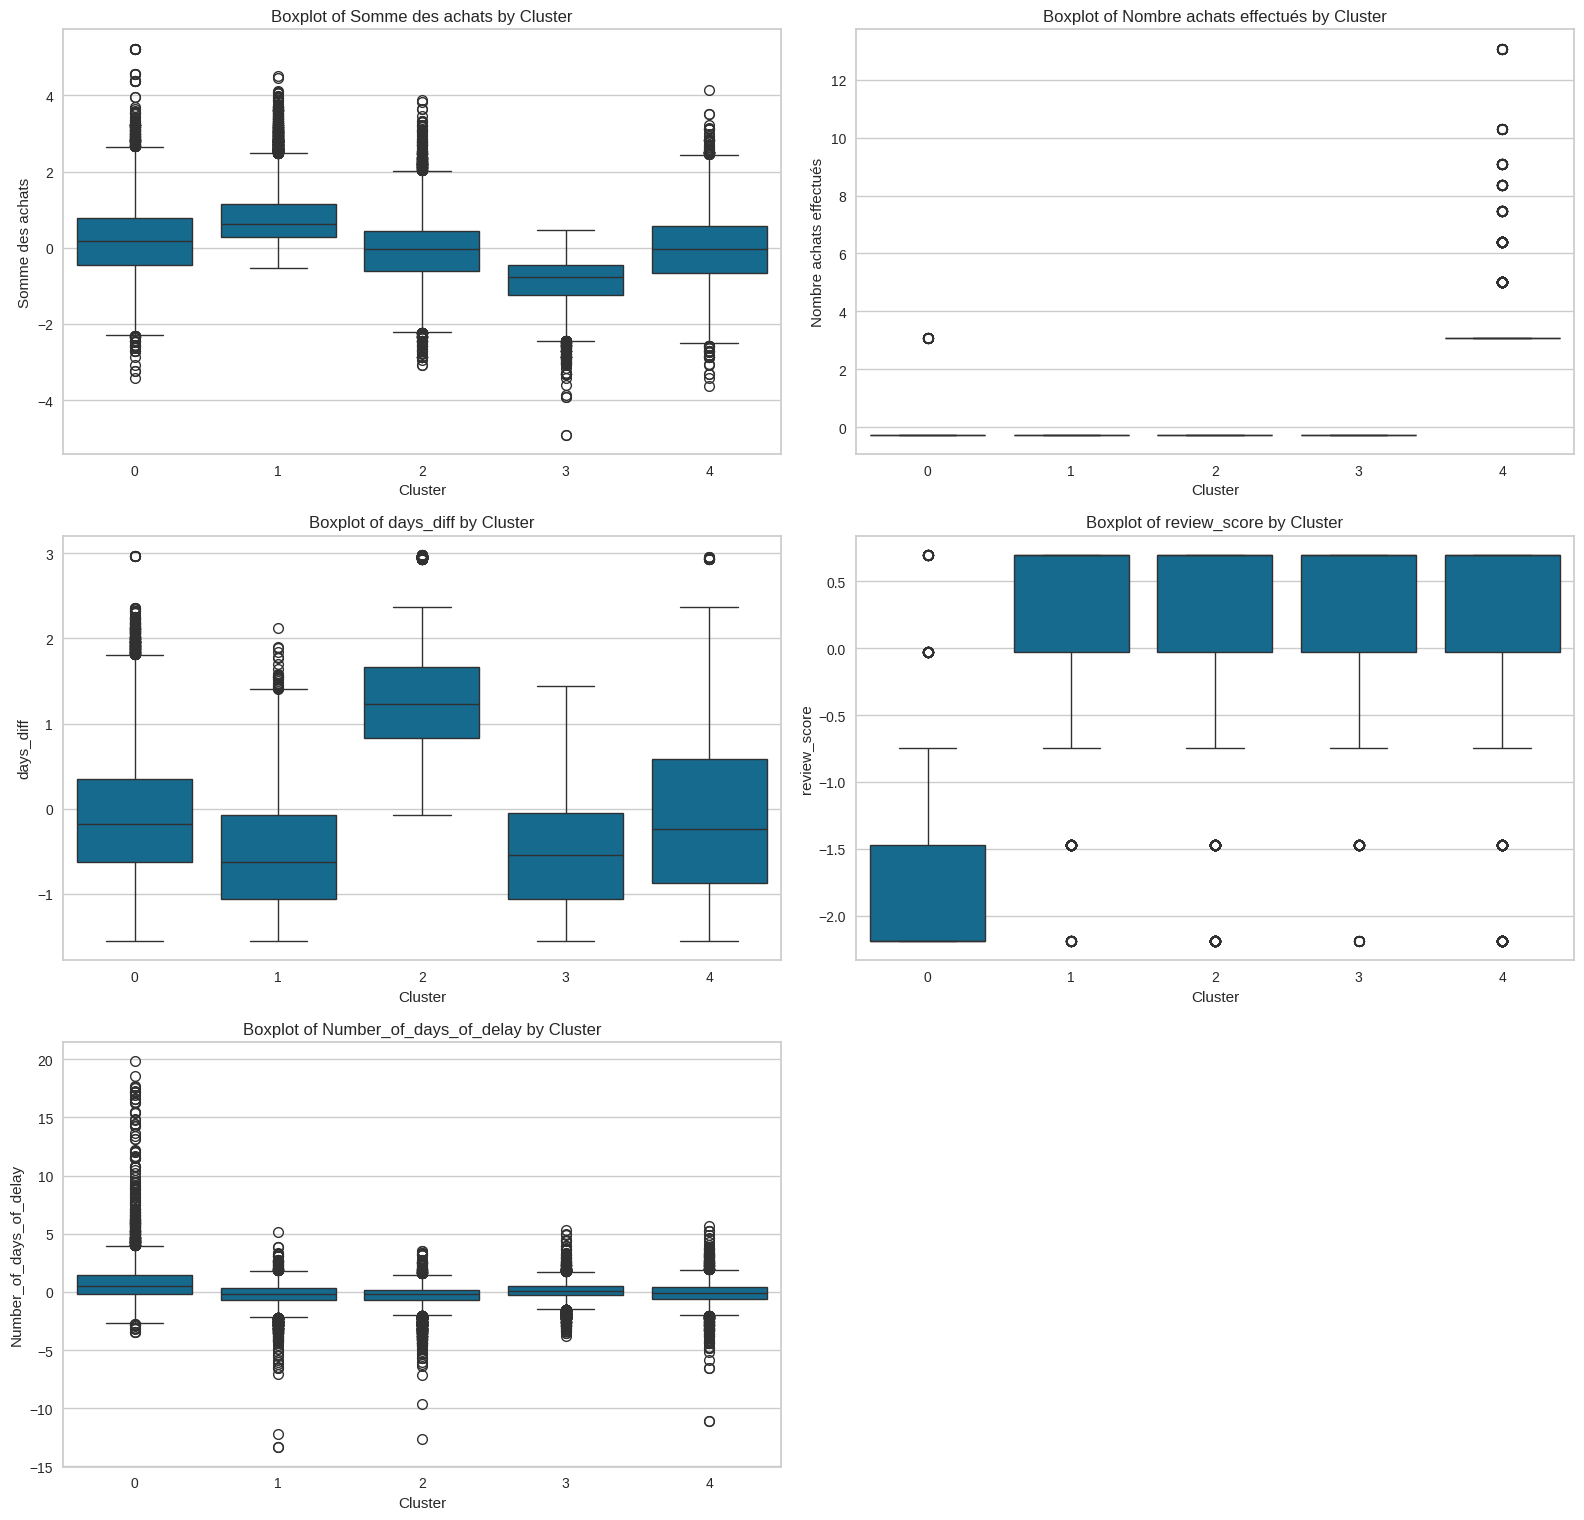

In [180]:
variables_test_3 = ['Somme des achats','Nombre achats effectués','days_diff','review_score','Number_of_days_of_delay']

plt.figure(figsize=(16, 20))
for i, var in enumerate(variables_test_3, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x='cluster_5', y=var, data=df_test_3)
    plt.title(f'Boxplot of {var} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

In [181]:
df_test_3['cluster_5'].value_counts().sort_values(ascending=False)

cluster_5
1    30849
3    30356
2    27055
0    16799
4     8150
Name: count, dtype: int64

**df_test_3 : 6 clusters**

In [216]:
k_means_test_3_bis =KMeans(n_clusters=6, random_state=42,n_init=10)
k_means_test_3_bis.fit(df_test_3_bis)

KMeans(n_clusters=6, n_init=10, random_state=42)

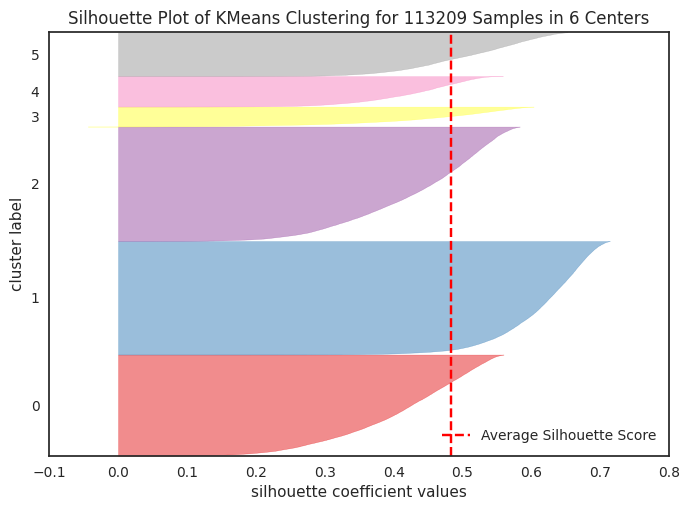

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 113209 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [217]:
visualizer=SilhouetteVisualizer(k_means_test_3_bis)

visualizer.fit(df_test_3_bis)
visualizer.poof()

**Compte du nombre de clients par cluster pour df_std_final**

In [193]:
# segment_counts = df_std_final['cluster_7'].value_counts()

# plt.figure(figsize=(10, 7))
# plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title('Distribution des Clusters k-means')
# plt.axis('equal')
# plt.show()

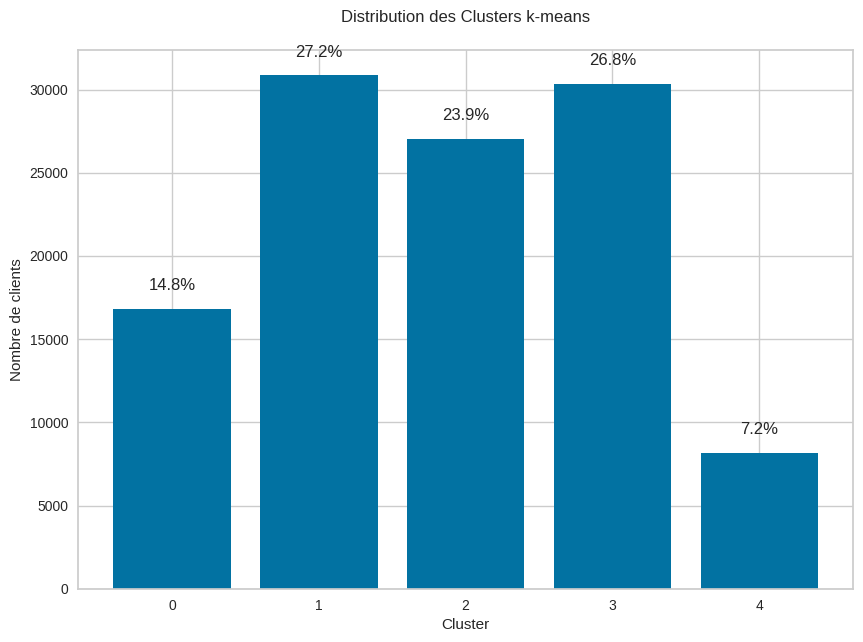

In [182]:
# Sort segment_counts in descending order
segment_counts = segment_counts.sort_values(ascending=False)


plt.figure(figsize=(10, 7))
plt.bar(segment_counts.index, segment_counts.values)

# Add percentages on top of the bars
total = segment_counts.sum()
for cluster, count in segment_counts.items():  # Iterate using items()
    percentage = '{:.1f}%'.format(100 * count / total)
    plt.text(cluster, count + 0.01 * total, percentage, ha='center')

plt.title('Distribution des Clusters k-means', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Nombre de clients')
plt.show()

In [183]:
# Sort segment_counts in descending order
segment_counts = segment_counts.sort_values(ascending=False)
segment_counts

cluster_5
1    30849
3    30356
2    27055
0    16799
4     8150
Name: count, dtype: int64

### DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est un algorithme de clustering non supervisé qui regroupe des points de données proches en fonction de leur densité et identifie les points isolés comme du bruit.

In [184]:
from sklearn.cluster import DBSCAN

# # Créer un modèle DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajustez les paramètres 'eps' et 'min_samples' selon vos besoins

# # Ajuster le modèle aux données
# dbscan.fit(X)

# # Obtenir les étiquettes de cluster
# labels = dbscan.labels_

# # Ajouter les étiquettes de cluster aux données
# df_final_merged_5['cluster'] = labels

# # Afficher les résultats
# print(df_final_merged_5.head())

In [185]:
# df_final_merged_5['cluster'].value_counts()

In [186]:
df_dbscan = df_std_final.copy()
df_dbscan_sampled = df_dbscan.sample(n=20000, random_state=0)

In [188]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score


param_grid = {'eps': [0.1, 0.5, 0.8, 1], 'min_samples': [5, 15, 25, 30]}

best_params = None
best_silhouette_score = -1

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    dbscan_labels = dbscan.fit_predict(df_dbscan_sampled)
    unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
    if len(unique_labels) > 1:  # Au moins un cluster autre que le bruit
        silhouette_avg = silhouette_score(df_dbscan_sampled, dbscan_labels)
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_params = params

print("Hyperparamètres sélectionnés:", best_params)

Hyperparamètres sélectionnés: {'eps': 1, 'min_samples': 25}


In [189]:
dbscan = DBSCAN(eps= 1, min_samples= 25)
dbscan.fit(df_dbscan_sampled)
cluster_labels = dbscan.labels_

In [190]:
unique_labels = np.unique(cluster_labels[cluster_labels != -1])
num_clusters = len(unique_labels)

print("Number of clusters obtained:", num_clusters)

Number of clusters obtained: 6


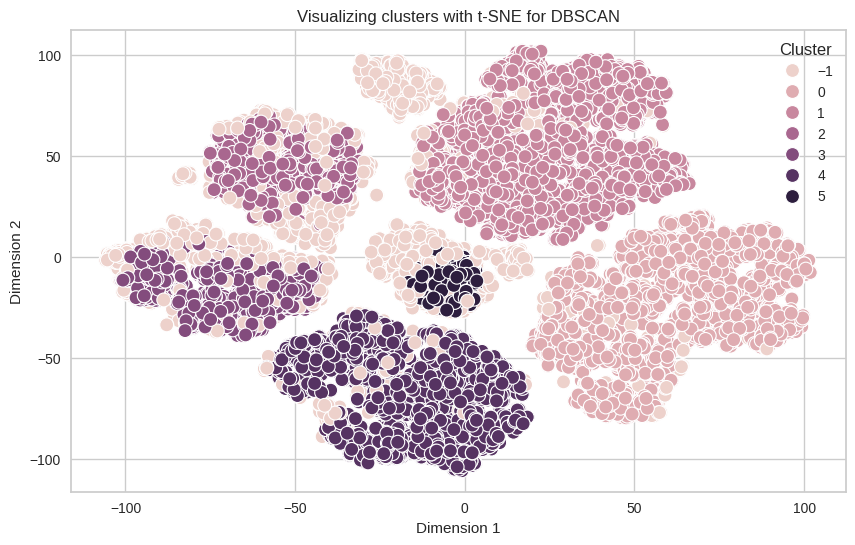

In [191]:
from sklearn.manifold import TSNE

dbscan = TSNE(n_components=2, random_state=0)
dbscan_data = dbscan.fit_transform(df_dbscan_sampled)
dbscan_df = pd.DataFrame({'Dimension 1': dbscan_data[:, 0], 'Dimension 2': dbscan_data[:, 1], 'Cluster': cluster_labels})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Cluster', data=dbscan_df, s=100)
plt.title('Visualizing clusters with t-SNE for DBSCAN')
plt.show()

In [192]:
n_noise_ = list(cluster_labels).count(-1)
print('Estimated number of noise points:', n_noise_)

Estimated number of noise points: 3713


In [193]:
dbscan_df['Cluster'].value_counts()

Cluster
 1    4658
 0    4399
-1    3713
 4    3435
 3    1689
 2    1524
 5     582
Name: count, dtype: int64

Ce graphique représente une visualisation des clusters formés par l'algorithme DBSCAN, réduits à deux dimensions à l'aide de t-SNE. On observe plusieurs clusters distincts, chacun étant bien séparé, ce qui indique que DBSCAN a réussi à identifier des groupes de points de données avec des densités similaires, tandis que les points marqués comme "-1" sont considérés comme du bruit ou des outliers.

### Classification Ascendante Hiérarchique

In [194]:
df_cah=df_final_merged_7.copy()
df_cah = df_cah.sample(n=20000, random_state=0)
df_cah=df_cah.set_index('customer_unique_id')
df_cah_bis=df_cah.loc[:,['price', 'freight_value','Somme des achats',
             'Nombre achats effectués','days_diff',
'review_score','payment_installments']]
df_cah_bis = df_cah_bis.apply(np.log1p) #SEULEMENT GARDER LES VALEURS NUMERIQUES UTILISES POUR LA CLASSIFICATION : recency	frequency	monetary	total_items	average_installments	freight	average_delivery_delay	average_revie
df_cah_bis.head(1)

price  freight_value  Somme des achats  \
customer_unique_id                                                            
ac3535b87084628fab1d655998d12eca  4.941642       2.912894          5.631212   

                                  Nombre achats effectués  days_diff  \
customer_unique_id                                                     
ac3535b87084628fab1d655998d12eca                 0.693147   5.446737   

                                  review_score  payment_installments  
customer_unique_id                                                    
ac3535b87084628fab1d655998d12eca      1.791759              0.693147

In [195]:
variables = df_cah_bis.values
variables

array([[4.94164242, 2.912894  , 5.63121178, ..., 5.44673737, 1.79175947,
        0.69314718],
       [2.98416564, 2.8786365 , 3.65169666, ..., 5.44241771, 1.79175947,
        2.07944154],
       [3.71332813, 2.83966309, 5.08115589, ..., 5.6347896 , 1.38629436,
        0.69314718],
       ...,
       [5.19295685, 3.00221124, 5.19295685, ..., 4.75359019, 0.69314718,
        1.09861229],
       [5.24702407, 3.18841662, 5.24702407, ..., 3.98898405, 1.79175947,
        2.39789527],
       [4.15543966, 2.72063732, 4.15543966, ..., 5.45958551, 1.79175947,
        0.69314718]])

In [196]:
df_cah_bis.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, ac3535b87084628fab1d655998d12eca to 57acaf1927be0d1f26e5fd136fede5d4
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    20000 non-null  float64
 1   freight_value            20000 non-null  float64
 2   Somme des achats         20000 non-null  float64
 3   Nombre achats effectués  20000 non-null  float64
 4   days_diff                20000 non-null  float64
 5   review_score             20000 non-null  float64
 6   payment_installments     20000 non-null  float64
dtypes: float64(7)
memory usage: 1.2+ MB


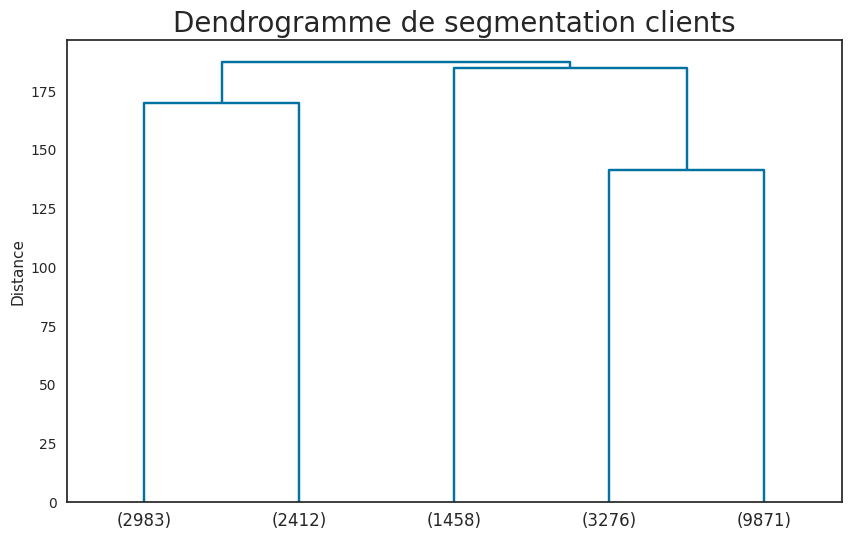

In [197]:
variables = df_cah_bis.values
liste_id = df_cah_bis.index

from sklearn import preprocessing

variables_standard = preprocessing.StandardScaler().fit(variables)
variables_echelle = variables_standard.transform(variables)

from scipy.cluster.hierarchy import linkage, fcluster

link_variables = linkage(variables_echelle, method = 'ward', metric='euclidean')

from scipy.cluster.hierarchy import dendrogram

fig =plt.figure(figsize=(10,6))
sns.set_style('white')
plt.title('Dendrogramme de segmentation clients', fontsize=20)
plt.ylabel('Distance')
dendrogram(link_variables, labels = df_cah_bis.index, p=5, truncate_mode='lastp', orientation='top')
plt.show()

In [198]:
classe = fcluster(link_variables, t=5, criterion='maxclust')
df_final_cah = pd.DataFrame({'customer_unique_id' : df_cah_bis.index.tolist(),
                             'classe' : classe})
df_final_cah = df_final_cah.sort_values(['classe', 'customer_unique_id'])

df_final_cah = pd.merge(df_cah_bis, df_final_cah, on='customer_unique_id')
df_final_cah.head(1)

customer_unique_id     price  freight_value  \
0  ac3535b87084628fab1d655998d12eca  4.941642       2.912894   

   Somme des achats  Nombre achats effectués  days_diff  review_score  \
0          5.631212                 0.693147   5.446737      1.791759   

   payment_installments  classe  
0              0.693147       5

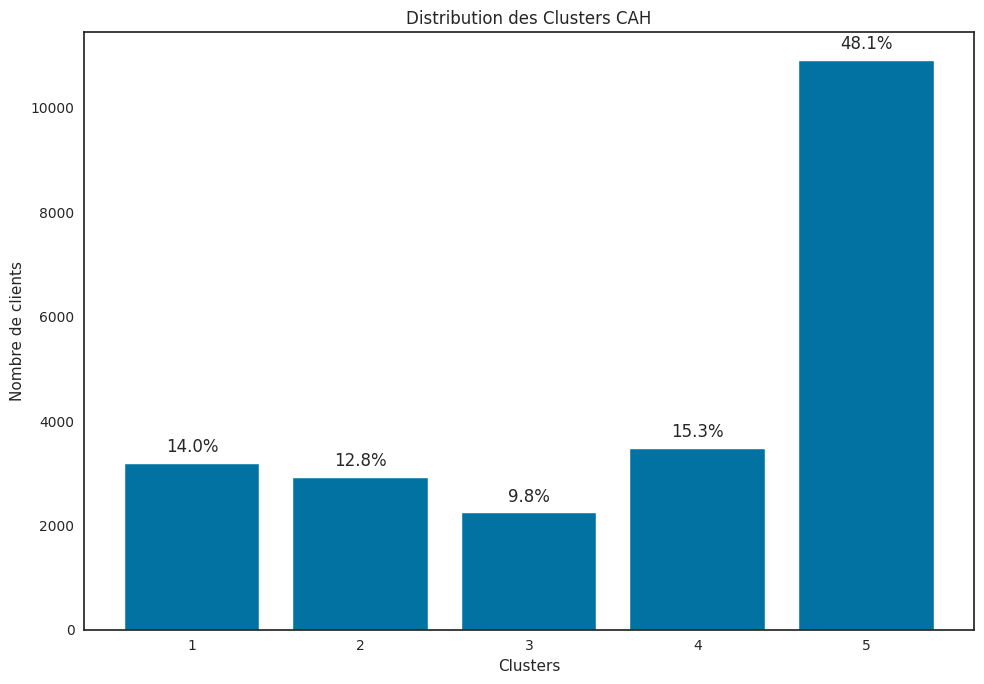

In [199]:
segment_counts = df_final_cah['classe'].value_counts()

plt.figure(figsize=(10, 7))
plt.bar(segment_counts.index, segment_counts.values)  # Create the bar chart

# Add percentages on top of the bars
total = segment_counts.sum()
for cluster, count in segment_counts.items():  # Iterate using items()
    percentage = '{:.1f}%'.format(100 * count / total)
    plt.text(cluster, count + 0.01 * total, percentage, ha='center')
plt.xlabel('Clusters')  # Label for the x-axis
plt.ylabel('Nombre de clients')  # Label for the y-axis
plt.title('Distribution des Clusters CAH')  # Title of the histogram
plt.tight_layout()



In [200]:
df_final_cah

customer_unique_id     price  freight_value  \
0      ac3535b87084628fab1d655998d12eca  4.941642       2.912894   
1      ac3535b87084628fab1d655998d12eca  4.941642       2.912894   
2      1ab7e5facf5738d97496473c68c21f35  2.984166       2.878637   
3      1c3d7c636328b67e04868833bc52122d  3.713328       2.839663   
4      1c3d7c636328b67e04868833bc52122d  3.713328       2.839663   
...                                 ...       ...            ...   
22673  d358a2a13cf7996abe26067ae5c43b3d  4.795791       2.867899   
22674  1ae3af034d2d5b9a30778b76193e8648  5.820053       3.185939   
22675  bdee14a4f9d04d3b78a69f7ba1e82425  5.192957       3.002211   
22676  9dc80712fe7b594cb2022882737397c2  5.247024       3.188417   
22677  57acaf1927be0d1f26e5fd136fede5d4  4.155440       2.720637   

       Somme des achats  Nombre achats effectués  days_diff  review_score  \
0              5.631212                 0.693147   5.446737      1.791759   
1              5.631212                 0.693147   5.446737      1.791759   
2              3.651697                 0.693147   5.442418      1.791759   
3              5.081156                 0.693147   5.634790      1.386294   
4              5.081156                 0.693147   5.634790      1.386294   
...                 ...                      ...        ...           ...   
22673          4.795791                 0.693147   5.613128      0.693147   
22674          5.820053                 0.693147   6.169611      1.791759   
22675          5.192957                 0.693147   4.753590      0.693147   
22676          5.247024                 0.693147   3.988984      1.791759   
22677          4.155440                 0.693147   5.459586      1.791759   

       payment_installments  classe  
0                  0.693147       5  
1                  0.693147       5  
2                  2.079442       5  
3                  0.693147       5  
4                  0.693147       5  
...                     ...     ...  
22673              0.693147       2  
22674              0.693147       5  
22675              1.098612       2  
22676              2.397895       4  
22677              0.693147       5  

[22678 rows x 9 columns]

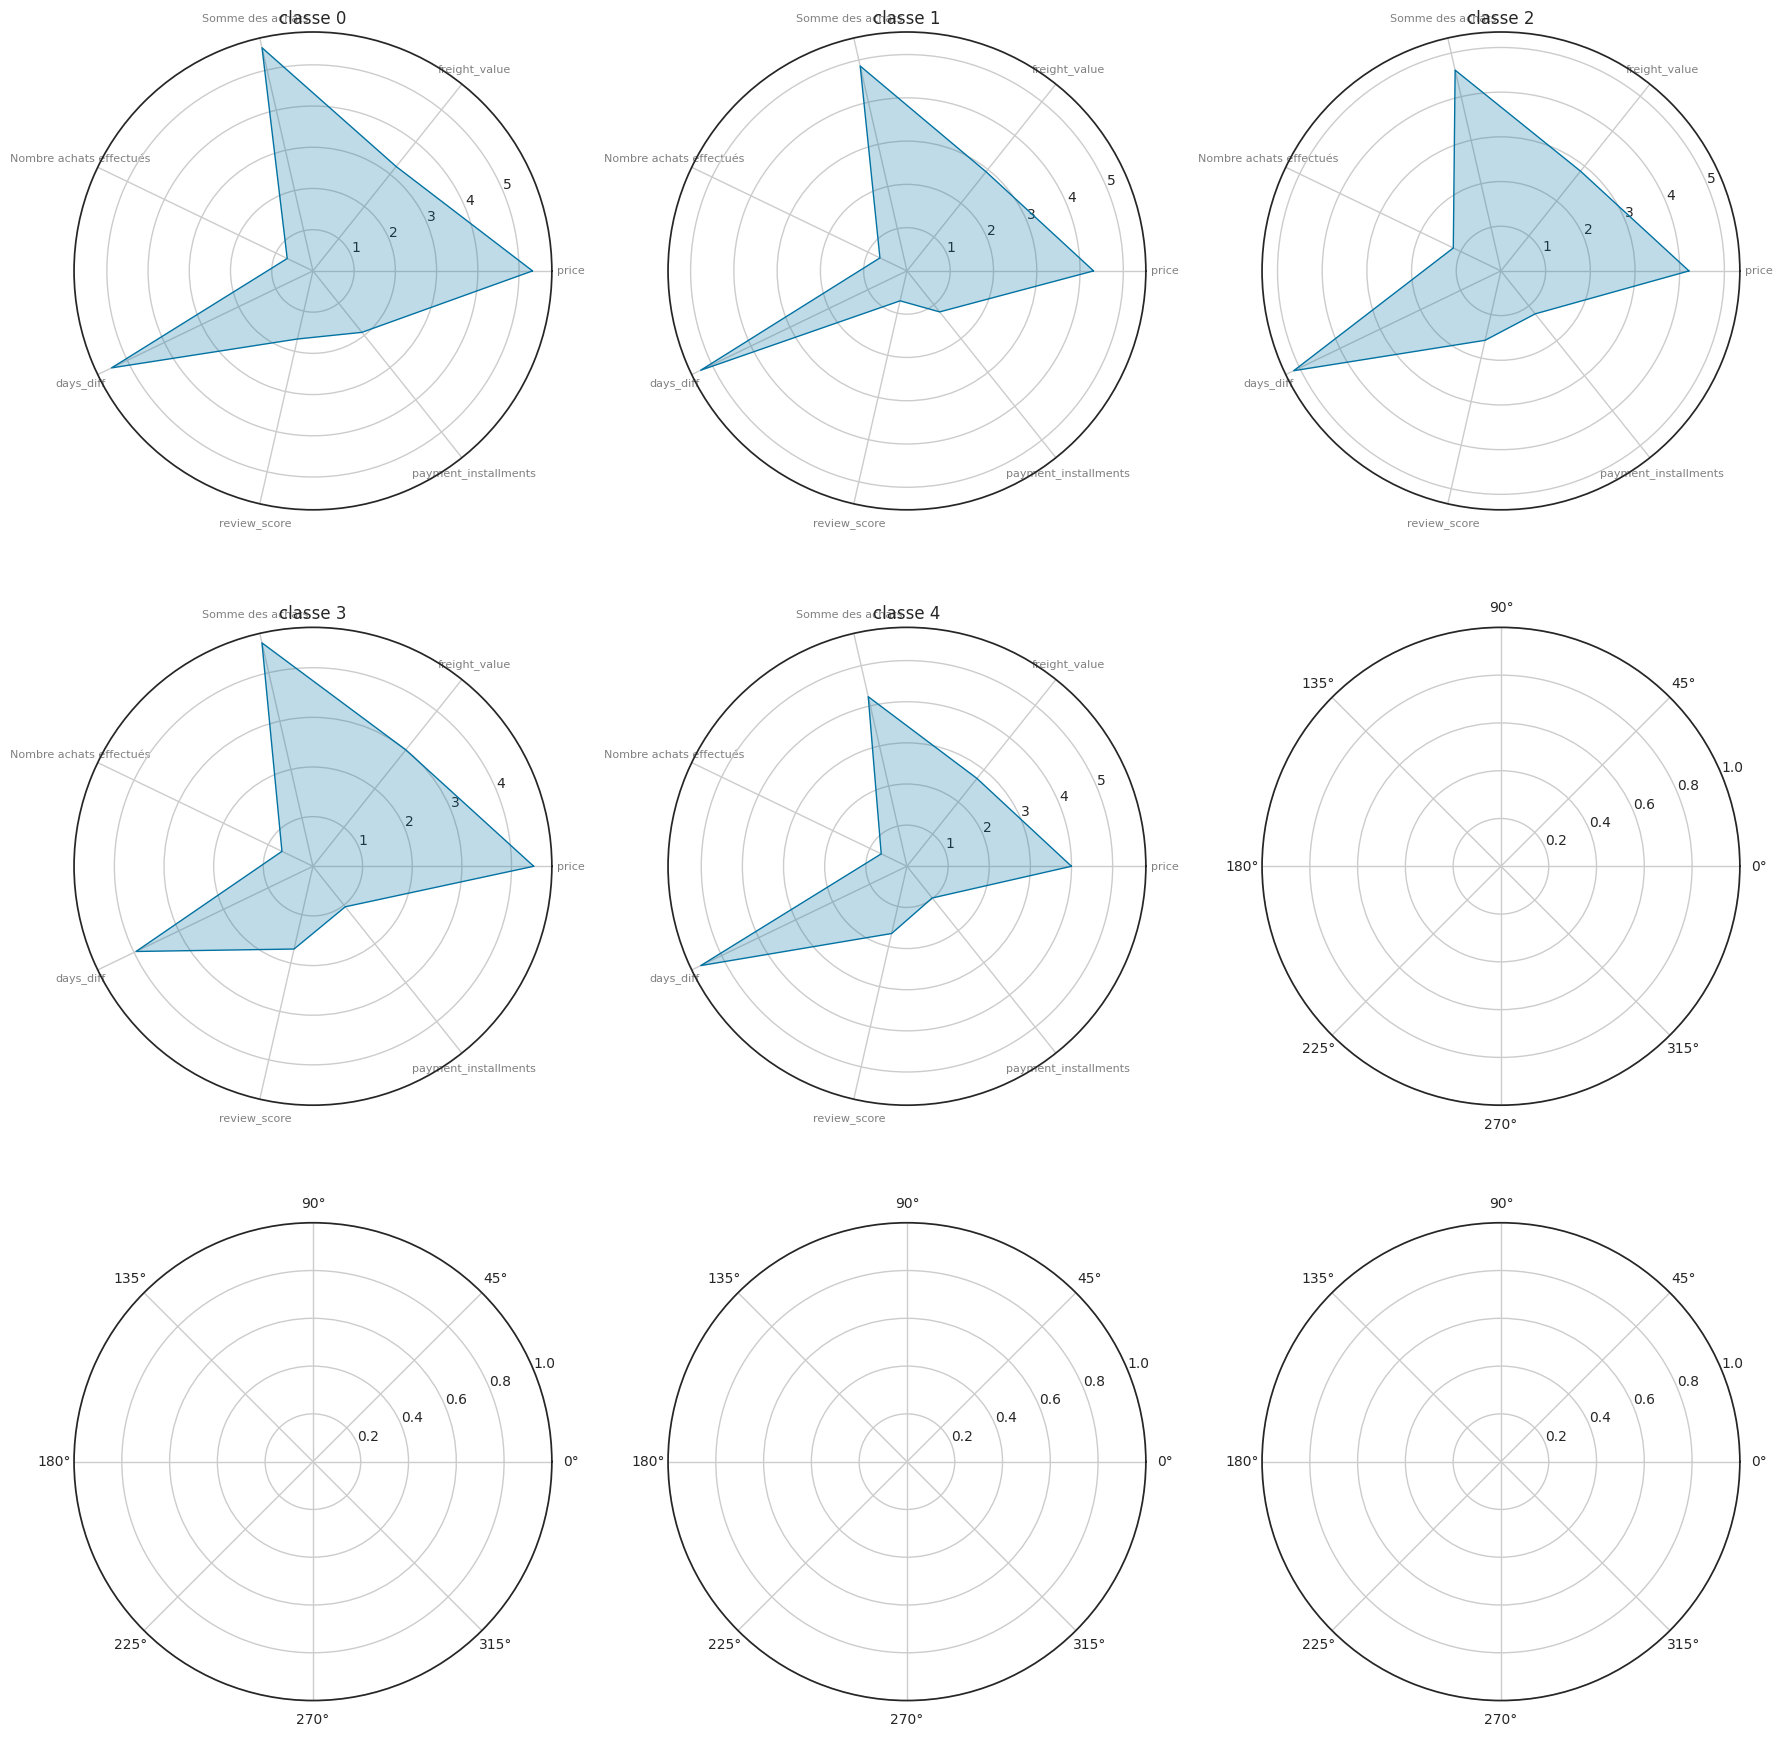

In [201]:
from math import pi

# Calculer les moyennes des variables par classe
variables = ['price', 'freight_value','Somme des achats',
             'Nombre achats effectués','days_diff',
'review_score','payment_installments']

classe_means = df_final_cah.groupby('classe')[variables].mean().reset_index()

# Nombre de classes
num_classes = len(classe_means)

# Créer un radar plot pour chaque classe
def create_radar_charts(classe_means, variables):
    # Nombre de variables
    num_vars = len(variables)

    # Angles pour chaque variable
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Initialiser le radar plot
    fig, axs = plt.subplots(3, 3, figsize=(18, 18), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for i in range(num_classes):
        values = classe_means.loc[i].drop('classe').values.flatten().tolist()
        values += values[:1]

        # Tracer les valeurs pour le classe
        axs[i].plot(angles, values, linewidth=1, linestyle='solid', label=f'classe {i}')
        axs[i].fill(angles, values, alpha=0.25)

        # Ajouter les labels pour chaque angle
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(variables, color='grey', size=8)

        # Ajouter un titre
        axs[i].set_title(f'classe {i}')

    # Ajuster l'affichage
    plt.tight_layout()
    plt.show()

# Créer et afficher les radar plots dans le même visuel
create_radar_charts(classe_means, variables)

## Contrat de Maintenance

In [202]:
df_final_merged_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115609 entries, 0 to 115608
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    115609 non-null  object        
 1   customer_unique_id             115609 non-null  object        
 2   customer_zip_code_prefix       115609 non-null  int64         
 3   customer_city                  115609 non-null  object        
 4   customer_state                 115609 non-null  object        
 5   order_id                       115609 non-null  object        
 6   order_status                   115609 non-null  object        
 7   order_purchase_timestamp       115609 non-null  datetime64[ns]
 8   order_approved_at              115595 non-null  datetime64[ns]
 9   order_delivered_carrier_date   114414 non-null  datetime64[ns]
 10  order_delivered_customer_date  113209 non-null  datetime64[ns]
 11  

In [203]:
df_maintenance = df_final_merged_7.copy()
df_orders_maintenance=df_maintenance.loc[:,['customer_unique_id','order_id','Somme des achats','days_diff','review_score','Number_of_days_of_delay','order_purchase_timestamp','Nombre achats effectués']]
df_orders_maintenance.head()
# df_orders_maintenance['review_score'] = df_orders_maintenance['review_score'].astype(int)
# df_orders_maintenance['payment_installments'] = df_orders_maintenance['payment_installments'].astype(int)
# df_orders_maintenance['order_item_number'] = df_orders_maintenance['order_item_number'].astype(int)

customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  290c77bc529b7ac935b93aa66c333dc3  29150127e6685892b6eab3eec79f59c7   
2  060e732b5b29e8181a18229c7b0b2b5e  b2059ed67ce144a36e2aa97d2c9e9ad2   
3  259dac757896d24d7702b9acbbff3f3c  951670f92359f4fe4a63112aa7306eba   
4  345ecd01c38d18a9036ed96c73b8d066  6b7d50bd145f6fc7f33cebabd7e49d0f   

   Somme des achats  days_diff  review_score  Number_of_days_of_delay  \
0            124.99        474             4                    -11.0   
1            289.00        233             5                     -8.0   
2            139.94        106             5                      1.0   
3            149.94        173             5                    -13.0   
4            230.00         35             5                     -6.0   

  order_purchase_timestamp  Nombre achats effectués  
0      2017-05-16 15:05:35                        1  
1      2018-01-12 20:48:24                        1  
2      2018-05-19 16:07:45                        1  
3      2018-03-13 16:06:38                        1  
4      2018-07-29 09:51:30                        1

In [204]:
df_orders_maintenance=df_orders_maintenance.dropna(subset=['Number_of_days_of_delay'])
df_orders_maintenance.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113209 entries, 0 to 115608
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_unique_id        113209 non-null  object        
 1   order_id                  113209 non-null  object        
 2   Somme des achats          113209 non-null  float64       
 3   days_diff                 113209 non-null  int64         
 4   review_score              113209 non-null  int64         
 5   Number_of_days_of_delay   113209 non-null  float64       
 6   order_purchase_timestamp  113209 non-null  datetime64[ns]
 7   Nombre achats effectués   113209 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 7.8+ MB


**Modélisation à t0**

In [205]:
from datetime import timedelta

def period_data(ti, orders):
    orders_i = orders.loc[orders['order_purchase_timestamp'] < ti, :]

    date_i = orders_i["order_purchase_timestamp"].dt\
        .date.sort_values().iloc[-1] + timedelta(days=1)
    orders_i['order_recency_days'] = orders_i[
        "order_purchase_timestamp"].dt.date.apply(
        lambda x: date_i - x).dt.days

    X_i = orders_i.groupby('customer_unique_id').agg(
        recency=("order_recency_days", 'min'),
        frequency=("order_id", 'count'),
        monetory=("Somme des achats", 'sum'),
        avis=("review_score", lambda x: round(x.mean())),
        nbr_jour_retard_livraison=("Number_of_days_of_delay",
                            lambda x: round(x.mean())),
        nbr_total_article=("Nombre achats effectués",
                           lambda x: round(x.sum())))
    return X_i

In [206]:
import datetime as dt

t0 = dt.datetime(2018, 3, 3)
X_0 = period_data(t0, df_orders_maintenance)
X_0.head()

<ipython-input-205-67b48145dff7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_i['order_recency_days'] = orders_i[


recency  frequency  monetory  avis  \
customer_unique_id                                                     
0000f46a3911fa3c0805444483337064      358          1     69.00     3   
0000f6ccb0745a6a4b88665a16c9f078      142          1     25.99     4   
0004aac84e0df4da2b147fca70cf8255      109          1    180.00     5   
00053a61a98854899e70ed204dd4bafe        3          2    764.00     1   
0005e1862207bf6ccc02e4228effd9a0      364          1    135.00     4   

                                  nbr_jour_retard_livraison  nbr_total_article  
customer_unique_id                                                              
0000f46a3911fa3c0805444483337064                         -2                  1  
0000f6ccb0745a6a4b88665a16c9f078                        -12                  1  
0004aac84e0df4da2b147fca70cf8255                         -8                  1  
00053a61a98854899e70ed204dd4bafe                        -10                  2  
0005e1862207bf6ccc02e4228effd9a0                        -28                  1

In [207]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


pca_0 = PCA(n_components=5).fit(X_0)
model_0 = Pipeline(steps=[('std', StandardScaler()),('kmeans', KMeans(init=pca_0.components_, n_clusters=5, n_init=1))])
model_0.fit(X_0)

Pipeline(steps=[('std', StandardScaler()),
                ('kmeans',
                 KMeans(init=array([[ 5.15903540e-04,  5.11603948e-04,  9.99999489e-01,
        -1.03025815e-04,  3.88016852e-06,  6.95142798e-04],
       [ 9.99810832e-01, -6.58599575e-06, -5.15496807e-04,
         7.84231766e-04, -1.94260785e-02, -2.15584427e-04],
       [ 1.94407834e-02, -1.77168367e-03, -1.41502105e-05,
        -3.71857919e-02,  9.99110235e-01, -3.85644211e-03],
       [ 2.86741785e-04,  3.77275582e-01, -8.41137649e-04,
        -4.97252054e-02,  2.38216473e-03,  9.24761631e-01],
       [-4.45762491e-05, -1.14355961e-02,  6.80383141e-05,
         9.97540644e-01,  3.73326387e-02,  5.82078887e-02]]),
                        n_clusters=5, n_init=1))])

### ARI pour vérifier les résultats et la stabilisation du modèle

In [208]:
import warnings

warnings.filterwarnings("ignore")

from sklearn.metrics import adjusted_rand_score

ari_score_ = []
for i in range(0, 20):
    ti = t0 + i*timedelta(days=7)
    X_i = period_data(ti, df_orders_maintenance)
    pca = PCA(n_components=5).fit(X_i)
    model = Pipeline(steps=[('std', StandardScaler()),('kmeans', KMeans(init=pca.components_,n_clusters=5,n_init=1))])
    model.fit(X_i)
    clusters = model.predict(X_i)
    clusters_0 = model_0.predict(X_i)
    ari = adjusted_rand_score(clusters_0, clusters)
    ari_score_.append([i, ari])

ari_score = pd.DataFrame(ari_score_, columns=["period", "ari_score"])
ari_score

period  ari_score
0        0   1.000000
1        1   0.977262
2        2   0.952931
3        3   0.926572
4        4   0.891213
5        5   0.865957
6        6   0.866066
7        7   0.874854
8        8   0.878676
9        9   0.865700
10      10   0.851873
11      11   0.834766
12      12   0.799724
13      13   0.758879
14      14   0.707650
15      15   0.671829
16      16   0.646708
17      17   0.627966
18      18   0.612051
19      19   0.589829

In [209]:
from shapely.geometry import LineString


def ari_plot(seuil, ari_score):
    x = ari_score.period.values
    y1 = ari_score.ari_score.values
    line_1 = LineString(np.column_stack((x, y1)))
    y2 = seuil*np.ones(len(x))
    line_2 = LineString(np.column_stack((x, y2)))
    intersection = line_1.intersection(line_2)
    x_intersection, y_intersection = intersection.xy
    x_intersection = x_intersection[0]
    y_intersection = y_intersection[0]
    week_maintenance = round(x_intersection)

    print('Mise à jour du modèle :'
          + '{} semaines))'
          .format(week_maintenance))

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=ari_score,
                 x="period",
                 y="ari_score")
    plt.xlabel("Semaine")
    plt.ylabel("Score ARI")
    plt.title("Evolution de la stabilité du modèle K-Means")

    plt.xlim(0, 20)
    plt.ylim(0, 1)
    plt.plot(x_intersection, y_intersection)

    plt.axhline(y=seuil,
                xmin=0,
                xmax=0.57,
                color='red')
    plt.axvline(x=x_intersection,
                ymin=0,
                ymax=seuil,
                alpha=0.6,
                color='red')
    plt.grid(visible=True)
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.xticks(np.arange(20))
    plt.show()
    return week_maintenance

Mise à jour du modèle :12 semaines))


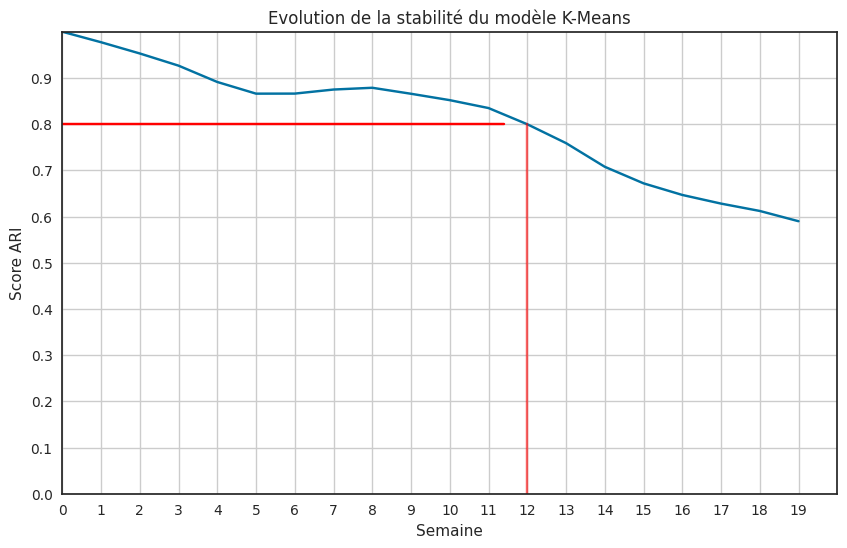

In [210]:
week_maintenance = ari_plot(seuil=0.8, ari_score=ari_score)


L'évolution de l'ARI-score (Adjusted Rand Index) au fil du temps pour un modèle K-means, mesuré sur une période de 20 semaines. Nous observons une diminution progressive de l'ARI-score, indiquant une dégradation de la stabilité du modèle K-means au fil des semaines. Notamment, à la 12ème semaine, marquée par un point rouge, l'ARI-score descend en dessous d'un seuil critique de 0.8. Cela suggère que le modèle commence à perdre significativement en performance à partir de cette période, soulignant la nécessité d'une réévaluation ou d'une mise à jour du modèle pour maintenir son efficacité.

## Archives

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Convertir la colonne 'order_purchase_timestamp' en datetime
df_merged_3['order_purchase_timestamp'] = pd.to_datetime(df_merged_3['order_purchase_timestamp'])

# Calculer la date il y a 3 mois
three_months_ago = df_merged_3['order_purchase_timestamp'].max() - relativedelta(months=3)


In [ ]:
df_merged_3['order_purchase_timestamp'].max()

In [ ]:
three_months_ago

In [ ]:
df_frequence = df_merged_3[df_merged_3['order_purchase_timestamp'] >= three_months_ago]
df_frequence['order_purchase_timestamp'].min()

In [ ]:
df_freq = df_frequence.groupby(['seller_id'])['order_id'].nunique()
df_freq.sort_values()

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_freq,kde=True,binwidth=10)
plt.title('Distribution du nombre de ventes totales par vendeur')
plt.xlabel('Nombre de ventes')
plt.ylabel('Nombre de vendeurs')
plt.show()

In [ ]:
df_freq_2 = df_merged_3.groupby(['customer_unique_id'])['order_id'].nunique()
df_freq_2.sort_values()

In [ ]:
import pandas as pd


# Calculer la date d'achat maximale
max_purchase_date = df_merged_3['order_purchase_timestamp'].max()

# Grouper par 'customer_id' et obtenir la date du dernier achat
last_purchase_dates = df_merged_3.groupby('customer_id')['order_purchase_timestamp'].max()

# Créer une fonction pour calculer la différence en jours
def days_since_last_purchase(last_purchase_date):
    return (max_purchase_date - last_purchase_date).days

# Appliquer la fonction pour créer la nouvelle colonne
last_purchase_dates['days_since_last_purchase'] = last_purchase_dates.apply(days_since_last_purchase)


In [ ]:
last_purchase_dates

In [ ]:
# Fusionner la nouvelle colonne avec le DataFrame original
df_merged_3_bis = pd.merge(df_merged_3, last_purchase_dates[['days_since_last_purchase']], on='customer_id', how='left')

# Afficher le DataFrame avec la nouvelle colonne
display(df_merged_3_bis.loc[df_merged_3_bis['customer_id']=='06b8999e2fba1a1fbc88172c00ba8bc7'])

In [ ]:
df_merged_3['seller_id'].nunique()

In [ ]:
# Filtrer les vendeurs avec plus de 30 commandes
sellers_over_30 = df_freq[df_freq > 30].index
sellers_over_30

In [ ]:
# print(df_customer.info())
# print(df_geo.info())
# print(df_order_item.info())

In [ ]:
# # Set-up
# %load_ext sql
# %sql sqlite://

In [ ]:
# import sqlite3
# conn = sqlite3.connect(':memory:')  # Creates an in-memory database


In [ ]:
!pip install pandasql

In [ ]:
from pandasql import sqldf

# Define a query
query = "SELECT * FROM df_customer WHERE customer_city = 'franca'"

# Execute the query
result = sqldf(query, locals())

# Display the result
print(result)

Requête numéro 1 : En excluant les commandes annulées, quelles sont les commandes récentes de moins de 3 mois que les clients ont reçues avec au moins 3 jours de retard ?

In [ ]:
query_test = """
  SELECT order_status,STRFTIME('%m', order_purchase_timestamp) as month_purchase
from df_orders where order_status != 'canceled'

"""

# Execute the query
resulttest = sqldf(query_test, locals())

# Display the result
print(resulttest)

In [ ]:
from pandasql import sqldf
query_test = """
SELECT
        order_id,
        (STRFTIME('%Y', order_delivered_customer_date) - STRFTIME('%Y', order_purchase_timestamp)) * 12 + (STRFTIME('%m', order_delivered_customer_date) - STRFTIME('%m', order_purchase_timestamp)) AS months_difference
    FROM df_orders
   where order_status != 'canceled'
   AND months_difference < 3;
   """
result_test = sqldf(query_test, locals())
print(result_test)

In [ ]:
query_test = """
SELECT MAX(order_delivered_customer_date), MAX(order_purchase_timestamp)

    FROM df_orders
   where order_status != 'canceled'

   """
result_test = sqldf(query_test, locals())
print(result_test)

In [ ]:
query_test = """
SELECT JULIANDAY(MAX(order_delivered_customer_date)) - 90
    FROM df_orders
WHERE order_status != 'canceled'

   """
result_test = sqldf(query_test, locals())
print(result_test)

In [ ]:
query_test = """
SELECT *
FROM df_orders
WHERE JULIANDAY(order_purchase_timestamp) >= (
    SELECT JULIANDAY(MAX(order_delivered_customer_date)) - 90
    FROM df_orders
)"""
result_test = sqldf(query_test, locals())
print(result_test)

In [ ]:
query_test = """
SELECT *, JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_estimated_delivery_date) AS delivery_delay
FROM df_orders
WHERE JULIANDAY(order_purchase_timestamp) >= (
    SELECT JULIANDAY(MAX(order_delivered_customer_date)) - 90
    FROM df_orders
)
AND delivery_delay >= 3
"""
result_test = sqldf(query_test, locals())
print(result_test)

In [ ]:
query2 = """SELECT o.order_id, c.customer_unique_id, o.order_purchase_timestamp, o.order_delivered_customer_date FROM df_orders o
JOIN df_customer c ON o.customer_id = c.customer_id
WHERE o.order_status != 'canceled'
  AND o.order_delivered_customer_date IS NOT NULL
  AND o.order_purchase_timestamp >= date('now', '-3 months')
  AND julianday(o.order_delivered_customer_date) - julianday(o.order_estimated_delivery_date) >= 3
ORDER BY o.order_purchase_timestamp DESC"""

# Execute the query
result2 = sqldf(query2, locals())

# Display the result
print(result2)